# PP Machine Learning Engineer Challenge

### 1. Introduction

This challenge aims to implement a cloud architecture that will feed our data lake with data from drinks, coming from the Punk API through data streams.

The purpose of this notebook is to generate analysis and present a machine learning model, disposed at the end of the presented pipeline, bringing together both engineering and data science efforts.

### 2. The Data Science Exploration Stage

From this point onwards, we start the data science process, which will be the usual cleaning and extracting info from the variables, fit the best model we can get, and enforce reproducibility practices. 

Nevertheless, it's important to add a disclaimer that this process will focus more on the software side, rather than the science side, since the objective isn't to bring out insights but to train a machine learning model for future predictions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics

from iac_exercise import aws_resources
from iac_exercise.mlflow_utils import TrainerRegressor
from iac_exercise.config import core



from feature_engine.imputation import (
    MeanMedianImputer
 )

import mlflow

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
df = pd.read_csv( "{}/drinks_data.csv".format(core.DATASET_DIR))

In [3]:
df

id                                 name  abv   ibu  target_fg  \
0      1                                 Buzz  4.5  60.0     1010.0   
1      2                        Trashy Blonde  4.1  41.5     1010.0   
2      3  Berliner Weisse With Yuzu - B-Sides  4.2   8.0     1007.0   
3      4                         Pilsen Lager  6.3  55.0     1012.0   
4      5                   Avery Brown Dredge  7.2  59.0     1027.0   
..   ...                                  ...  ...   ...        ...   
320  321                        Jinx Pale Ale  4.7  35.0     1008.0   
321  322                            Jet Trash  6.9  65.0     1008.0   
322  323             Interstate Vienna Lager.  5.0  25.0     1007.0   
323  324          Fools Gold Dortmunder Lager  5.6  32.0     1009.0   
324  325                              Zipcode  5.0  37.0     1006.0   

     target_og   ebc   srm   ph  
0       1044.0  20.0  10.0  4.4  
1       1041.7  15.0  15.0  4.4  
2       1040.0   8.0   4.0  3.2  
3       1060.0  30.0  15.0  4.4  
4       1069.0  10.0   5.0  4.4  
..         ...   ...   ...  ...  
320     1043.0  13.0   7.0  4.6  
321     1060.0  18.0   9.0  4.6  
322     1045.0  14.0   7.0  4.2  
323     1052.0  11.0   6.0  4.2  
324     1044.0   5.0   3.0  4.4  

[325 rows x 9 columns]

Here we make a little tweak: We split the data into df_train and new_data. The idea is that the df_train is the data we have exclusively for training and testing our dataframe. The new_data is all about the data we receive through our deployed application.

In [4]:
df_train = df.sample(frac=0.75, random_state=16)
new_data = df.drop(df_train.index)

data = df_train.copy()

In [5]:
data.describe()

id         abv          ibu    target_fg    target_og  \
count  244.000000  244.000000   241.000000   243.000000   243.000000   
mean   160.057377    7.790164    67.813278  1014.279835  1067.946091   
std     95.092833    4.119693   103.624303    12.013589    26.400435   
min      1.000000    0.500000     5.000000  1000.000000  1007.000000   
25%     75.500000    5.200000    35.000000  1010.000000  1048.750000   
50%    162.500000    7.150000    55.000000  1012.000000  1065.000000   
75%    243.500000    9.000000    70.000000  1015.000000  1080.000000   
max    325.000000   41.000000  1157.000000  1125.000000  1157.000000   

              ebc         srm          ph  
count  240.000000  240.000000  242.000000  
mean    71.741250   36.376458    4.732231  
std    100.494857   50.650042    4.807501  
min      2.000000    1.000000    3.200000  
25%     15.000000    8.000000    4.400000  
50%     30.000000   15.000000    4.400000  
75%     79.250000   40.000000    4.400000  
max    600.000000  305.000000   79.000000

#### 2.1 Hands on, Data & Problem Understanding

This is the data we must work with. It represents basic information about a number of artisanal beers as their names, ph, abv, and so on. With a quick glance on the internet, we can uncover the meaning of each variable. This is important because, with this knowledge, we can assert if any variable is behaving properly. 

- **id**: The Beer's id.
- **name**: The Beer's name.
- **abv**: The Beer's _alcohol by volume_.THe higher the abv, the more alcohol that beer contains.
- **ibu**: The Beer's _international bittering unit_. Measures the bitterness levels in beer.
- **target_fg**: The Beer's _final gravity_. Measures how much sugar is left over when fermentation is done.
- **target_og**: The Beer's _original gravity_. Measures how much sugar is present in the wort before it is fermented.
- **ebc**: A modern brew system to specify beer color, using it's own scale and methodology.
- **srm**: Likewise the **ebc**, it's measure the beer color using it's own scale and methodology.
- **ph**: The Beer's ph. Measure how acidic/basic the beer is.

All of this information is important for data integrity. For example, a pH scale goes from 0 to 14. However, the variable's distribution shows a beer with 79.
Even though this could be interpreted as an outlier, given we didn't have the right definition of it, we can help but wonder if the data coming to the model in prod, receives an input like that.

**Defining Upper Bound Limits**

- Ph should be within 0 - 14
- SRM should have a max value of 40
- EBC should have a max value of 81

#### 2.2 Missing Values Imputation

We can infer the features' type from the dataframe:

- **float**: abv. ibu, ebc, ph, srm
- **int**: target_og, target_fg

As most of the variables present outliers/wrong inputs, the imputation will be through their median for it's being a robust statistic.

Even though the missing values disappear after future filters and data cleaning, we can't expect this behavior won't happen again in production. For this very reason, the pipeline will include missing value imputation for each variable.

In [6]:
pd.DataFrame(data.isna().sum(), columns=["Missing Values"])

Missing Values
id                      0
name                    0
abv                     0
ibu                     3
target_fg               1
target_og               1
ebc                     4
srm                     4
ph                      2

In [7]:
data = data[data["ph"]<=14]
data = data[data["srm"]<=40]
data = data[data["ebc"]<=80]

#### About the Target Variable

Our target variable in this exercise is the **ibu**. Since its definition lies in the domain of the real numbers, we got a regression problem. Since there are some beers that lack **ibu**, these will be deleted from the dataframe.

Even though the IBU' scale is measured from 0 to infinity basically, "Almost all the beer you're ever going to drink will have an IBU rating between 5 and 120" (Ref.:https://www.thebrewenthusiast.com/ibus).
With this, we can narrow our variable which shows very elevated numbers. 

**Defining Upper Bound Limits**
- IBU should be within 5 to 120.

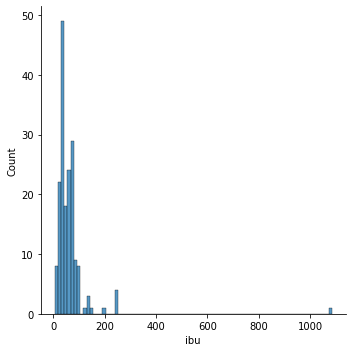

In [8]:
# A very asymmetric distribution, influencied by outliers.
sns.displot(data["ibu"])

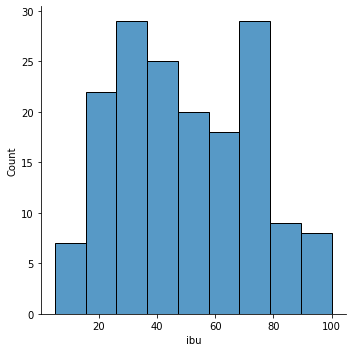

In [9]:
data = data[data["ibu"]<=120]
sns.displot(data["ibu"])

#### 2.3 Feature Engineering

In this quick step, we can generate new variables from the original ones.

For example, we can:

- Take the difference between the original and final gravity.
- ph is a variable with almost no variability (it's std = 0.37 and it's value for 25%, 50% and 75% quartile are equal). We could drop this variable, however, only for the sake of reproducibility (applied later), we can apply the exponential function to it and then, divide by the "target_og". 

Again, this procedure can make no sense at all, either for the model or for the business. However, I  want to show how the pipeline can be configured to mirror all the data transformation applied to the train set using sklearn.

In [10]:
# dg stands for difference gravity
data["target_dg"] = data["target_fg"] - data["target_og"]
data["fake_var"] = np.exp(data["ph"])/data["target_og"]

In [11]:
# Glimpse of the final dataframe
data

id                             name  abv   ibu  target_fg  target_og  \
265  266  Small Batch: Lemon Meringue Pie  6.5   5.0     1015.0     1066.0   
30    31                      Nanny State  0.5  55.0     1005.0     1007.0   
88    89                            Citra  7.5  70.0     1013.0     1068.0   
59    60                            Dogma  7.5  30.0     1023.0     1080.0   
105  106          Punk IPA 2010 - Current  5.6  40.0     1011.0     1055.0   
..   ...                              ...  ...   ...        ...        ...   
293  294                      Opaque Jake  7.2  20.0     1009.0     1065.0   
76    77                         Hobo Pop  4.2  50.0     1010.0     1042.0   
162  163                  This. Is. Lager  4.7  37.0     1007.0     1043.0   
190  191                     Interstellar  6.5  55.0     1011.0     1059.0   
153  154                         No Label  4.5  25.0     1009.0     1043.0   

      ebc   srm   ph  target_dg   fake_var  
265   7.0   4.0  4.0      -51.0  -1.070552  
30   30.0  15.0  4.4       -2.0 -40.725434  
88   30.0  15.0  4.4      -55.0  -1.480925  
59   46.0  23.0  4.5      -57.0  -1.579248  
105  15.0   7.6  4.4      -44.0  -1.851156  
..    ...   ...  ...        ...        ...  
293  20.0  10.0  4.4      -56.0  -1.454480  
76   30.0  15.0  4.4      -32.0  -2.545340  
162  10.0   6.0  4.2      -36.0  -1.852398  
190  50.0  25.0  4.4      -48.0  -1.696893  
153  10.0   5.0  4.2      -34.0  -1.961363  

[167 rows x 11 columns]

In [12]:
# A few list por parametrizing later functions

# List of variables for missing imputer
imputer_varibles = [
    "abv",
    "target_fg",
    "target_og",
    "ebc",
    "srm",
    "ph"
]

# List of unwanted variables for machine learning model
to_drop_train = [
    "id",
    "name",
    "ibu"
]

### 3. The Data Science Model Stage

The machine learning stages have a lot of steps for outputting the best method for predict incoming data. Reproducibility is sacred as a mantra, so we need to keep records of which value a variable had its missing value imputed with, apply the very same transformation that features had passed through the dev environment to production and other methods a data scientist infer to its data to generate ammo for better results.

In this step, we export a custom object that uses mlflow for experiment tracking with two models and some collection of hyperparameters for tunning. The process will record the best model, with its metrics and hyperparameters chosen from grid search's cross-validation to the mlflow ui. The artifacts generated will be able to help developers to recreate the same environment for production, for reproducibility.

In [13]:
df_train = df_train[df_train["ph"]<=14]
df_train = df_train[df_train["srm"]<=40]
df_train = df_train[df_train["ebc"]<=80]
df_train = df_train[df_train["ibu"]<=120]

X = df_train.drop(to_drop_train, axis=1)
y = df_train["ibu"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=16)

In [14]:
# Dicts for Model' GridSearch
cat_parameters = {
    'iterations': [300, 450, 700], 
    'learning_rate': [1, 0.1, 0.01], 
    'max_depth': [2,3,4]
}

rfr_parameters = {
    'n_estimators': [300, 450, 700], 
    'max_depth': [1, 3, 7]
}

# Our target variable.
target = "ibu"

The models used are CatBoost Regressor and the Random Forest Regressor. A number of other models could be used here as well. To grasp the TrainerRegressor functionality, check the **mlflow_utils.py** file.

In [15]:
cat_model_opt = TrainerRegressor(CatBoostRegressor)
cat_model_opt.train_test_split(X=X, y=y)
cat_model_opt.gridsearch_tuning(dict_params=cat_parameters, kfold_num=10)
cat_model_opt.mlflow_run(model_name="catboost_regressor", optimal_param=True)

0:	learn: 18.5022542	total: 46.7ms	remaining: 14s
1:	learn: 16.3497559	total: 48.4ms	remaining: 7.22s
2:	learn: 15.7415631	total: 48.6ms	remaining: 4.81s
3:	learn: 14.0065263	total: 48.7ms	remaining: 3.6s
4:	learn: 12.5854898	total: 48.7ms	remaining: 2.88s
5:	learn: 12.0699513	total: 48.8ms	remaining: 2.39s
6:	learn: 9.9047093	total: 49ms	remaining: 2.05s
7:	learn: 9.4647488	total: 49.1ms	remaining: 1.79s
8:	learn: 8.7113757	total: 49.1ms	remaining: 1.59s
9:	learn: 8.3725251	total: 49.2ms	remaining: 1.43s
10:	learn: 7.8503103	total: 49.3ms	remaining: 1.29s
11:	learn: 7.3459638	total: 49.3ms	remaining: 1.18s
12:	learn: 7.1917734	total: 49.4ms	remaining: 1.09s
13:	learn: 6.4626433	total: 49.5ms	remaining: 1.01s
14:	learn: 6.2256091	total: 49.6ms	remaining: 942ms
15:	learn: 5.8739926	total: 49.7ms	remaining: 882ms
16:	learn: 5.5025422	total: 49.8ms	remaining: 830ms
17:	learn: 5.0863144	total: 50ms	remaining: 783ms
18:	learn: 4.8418556	total: 50ms	remaining: 740ms
19:	learn: 4.6303423	tota

33:	learn: 2.1390218	total: 11ms	remaining: 86.1ms
34:	learn: 2.0162714	total: 11.4ms	remaining: 86.2ms
35:	learn: 1.9536306	total: 11.5ms	remaining: 84.4ms
36:	learn: 1.8246158	total: 11.6ms	remaining: 82.5ms
37:	learn: 1.7829280	total: 11.7ms	remaining: 80.8ms
38:	learn: 1.7152963	total: 11.8ms	remaining: 79.2ms
39:	learn: 1.6399255	total: 12ms	remaining: 77.7ms
40:	learn: 1.5866997	total: 12.1ms	remaining: 76.3ms
41:	learn: 1.5438438	total: 12.2ms	remaining: 75.1ms
42:	learn: 1.4900382	total: 12.4ms	remaining: 74.2ms
43:	learn: 1.4444748	total: 12.6ms	remaining: 73.1ms
44:	learn: 1.3938866	total: 12.7ms	remaining: 71.8ms
45:	learn: 1.3286364	total: 12.8ms	remaining: 71ms
46:	learn: 1.2886055	total: 16.8ms	remaining: 90.7ms
47:	learn: 1.2125880	total: 17.1ms	remaining: 89.6ms
48:	learn: 1.1904993	total: 17.2ms	remaining: 88.3ms
49:	learn: 1.1139486	total: 17.4ms	remaining: 87ms
50:	learn: 1.0793108	total: 17.5ms	remaining: 85.5ms
51:	learn: 1.0414323	total: 17.7ms	remaining: 84.3ms
5

4:	learn: 11.4617778	total: 1.1ms	remaining: 64.8ms
5:	learn: 10.5616125	total: 1.27ms	remaining: 62.3ms
6:	learn: 9.5758341	total: 1.37ms	remaining: 57.5ms
7:	learn: 8.6540684	total: 1.49ms	remaining: 54.4ms
8:	learn: 8.2227234	total: 1.6ms	remaining: 51.9ms
9:	learn: 7.8112202	total: 1.74ms	remaining: 50.6ms
10:	learn: 7.1580804	total: 1.86ms	remaining: 48.8ms
11:	learn: 7.0309848	total: 1.96ms	remaining: 47.1ms
12:	learn: 6.6714534	total: 2.07ms	remaining: 45.6ms
13:	learn: 6.5096896	total: 2.18ms	remaining: 44.6ms
14:	learn: 6.1897841	total: 2.41ms	remaining: 45.9ms
15:	learn: 5.7713021	total: 2.54ms	remaining: 45ms
16:	learn: 5.4655579	total: 2.67ms	remaining: 44.4ms
17:	learn: 5.0698509	total: 2.79ms	remaining: 43.7ms
18:	learn: 4.9651566	total: 2.85ms	remaining: 42.2ms
19:	learn: 4.7412467	total: 2.98ms	remaining: 41.8ms
20:	learn: 4.6022502	total: 3.08ms	remaining: 40.9ms
21:	learn: 4.4121122	total: 3.2ms	remaining: 40.5ms
22:	learn: 4.2623880	total: 3.33ms	remaining: 40.2ms
23

0:	learn: 17.9550751	total: 120us	remaining: 36.2ms
1:	learn: 16.0915754	total: 493us	remaining: 73.5ms
2:	learn: 14.9364059	total: 616us	remaining: 61ms
3:	learn: 13.4499205	total: 734us	remaining: 54.4ms
4:	learn: 11.5356163	total: 849us	remaining: 50.1ms
5:	learn: 10.2092161	total: 958us	remaining: 47ms
6:	learn: 9.6940330	total: 1.09ms	remaining: 45.8ms
7:	learn: 9.2245979	total: 1.33ms	remaining: 48.5ms
8:	learn: 8.3893984	total: 1.45ms	remaining: 46.9ms
9:	learn: 7.5264890	total: 1.56ms	remaining: 45.2ms
10:	learn: 7.1513186	total: 1.67ms	remaining: 43.8ms
11:	learn: 6.6812813	total: 1.79ms	remaining: 43ms
12:	learn: 6.2955262	total: 1.85ms	remaining: 40.9ms
13:	learn: 6.0963605	total: 1.96ms	remaining: 40.1ms
14:	learn: 5.7093580	total: 2.08ms	remaining: 39.5ms
15:	learn: 5.5513104	total: 2.14ms	remaining: 38ms
16:	learn: 5.3773199	total: 2.25ms	remaining: 37.6ms
17:	learn: 5.0733933	total: 2.37ms	remaining: 37.1ms
18:	learn: 4.8704930	total: 2.45ms	remaining: 36.2ms
19:	learn: 

162:	learn: 0.0001211	total: 21ms	remaining: 17.7ms
163:	learn: 0.0001148	total: 21.4ms	remaining: 17.7ms
164:	learn: 0.0001122	total: 21.6ms	remaining: 17.7ms
165:	learn: 0.0001050	total: 21.8ms	remaining: 17.6ms
166:	learn: 0.0000958	total: 21.9ms	remaining: 17.4ms
167:	learn: 0.0000897	total: 22ms	remaining: 17.3ms
168:	learn: 0.0000866	total: 22.2ms	remaining: 17.2ms
169:	learn: 0.0000848	total: 22.4ms	remaining: 17.1ms
170:	learn: 0.0000762	total: 22.5ms	remaining: 17ms
171:	learn: 0.0000731	total: 22.7ms	remaining: 16.9ms
172:	learn: 0.0000681	total: 22.8ms	remaining: 16.8ms
173:	learn: 0.0000626	total: 23ms	remaining: 16.6ms
174:	learn: 0.0000591	total: 23.1ms	remaining: 16.5ms
175:	learn: 0.0000576	total: 24.6ms	remaining: 17.3ms
176:	learn: 0.0000520	total: 24.8ms	remaining: 17.2ms
177:	learn: 0.0000489	total: 24.9ms	remaining: 17.1ms
178:	learn: 0.0000458	total: 25.1ms	remaining: 17ms
179:	learn: 0.0000442	total: 25.2ms	remaining: 16.8ms
180:	learn: 0.0000417	total: 25.4ms	re

179:	learn: 0.0001591	total: 27.8ms	remaining: 18.5ms
180:	learn: 0.0001496	total: 28.1ms	remaining: 18.5ms
181:	learn: 0.0001431	total: 28.2ms	remaining: 18.3ms
182:	learn: 0.0001396	total: 28.3ms	remaining: 18.1ms
183:	learn: 0.0001328	total: 28.4ms	remaining: 17.9ms
184:	learn: 0.0001256	total: 28.5ms	remaining: 17.7ms
185:	learn: 0.0001129	total: 28.6ms	remaining: 17.5ms
186:	learn: 0.0001083	total: 28.7ms	remaining: 17.3ms
187:	learn: 0.0001022	total: 29ms	remaining: 17.3ms
188:	learn: 0.0000949	total: 29.1ms	remaining: 17.1ms
189:	learn: 0.0000877	total: 29.3ms	remaining: 17ms
190:	learn: 0.0000817	total: 29.5ms	remaining: 16.8ms
191:	learn: 0.0000773	total: 29.5ms	remaining: 16.6ms
192:	learn: 0.0000696	total: 29.7ms	remaining: 16.4ms
193:	learn: 0.0000671	total: 29.8ms	remaining: 16.3ms
194:	learn: 0.0000630	total: 29.8ms	remaining: 16.1ms
195:	learn: 0.0000589	total: 29.9ms	remaining: 15.9ms
196:	learn: 0.0000527	total: 30ms	remaining: 15.7ms
197:	learn: 0.0000504	total: 30.1m

71:	learn: 0.1237200	total: 41.3ms	remaining: 131ms
72:	learn: 0.1157210	total: 42.2ms	remaining: 131ms
73:	learn: 0.1082771	total: 42.8ms	remaining: 131ms
74:	learn: 0.1026004	total: 43.4ms	remaining: 130ms
75:	learn: 0.0969033	total: 43.9ms	remaining: 129ms
76:	learn: 0.0934831	total: 44.4ms	remaining: 129ms
77:	learn: 0.0885540	total: 44.8ms	remaining: 128ms
78:	learn: 0.0835340	total: 45.3ms	remaining: 127ms
79:	learn: 0.0793149	total: 45.8ms	remaining: 126ms
80:	learn: 0.0727564	total: 46.1ms	remaining: 125ms
81:	learn: 0.0705982	total: 46.5ms	remaining: 124ms
82:	learn: 0.0694725	total: 47.2ms	remaining: 123ms
83:	learn: 0.0647543	total: 47.8ms	remaining: 123ms
84:	learn: 0.0588183	total: 48.4ms	remaining: 123ms
85:	learn: 0.0568185	total: 49.4ms	remaining: 123ms
86:	learn: 0.0536301	total: 50.3ms	remaining: 123ms
87:	learn: 0.0516524	total: 50.9ms	remaining: 123ms
88:	learn: 0.0470637	total: 51.5ms	remaining: 122ms
89:	learn: 0.0439279	total: 52.2ms	remaining: 122ms
90:	learn: 0

0:	learn: 15.0791768	total: 526us	remaining: 157ms
1:	learn: 12.0982114	total: 1.7ms	remaining: 253ms
2:	learn: 11.1342872	total: 2.38ms	remaining: 236ms
3:	learn: 9.5042981	total: 2.98ms	remaining: 221ms
4:	learn: 8.6190416	total: 3.83ms	remaining: 226ms
5:	learn: 7.5063925	total: 4.66ms	remaining: 228ms
6:	learn: 6.3939662	total: 11.3ms	remaining: 475ms
7:	learn: 5.6415773	total: 11.9ms	remaining: 433ms
8:	learn: 4.5421277	total: 12.3ms	remaining: 398ms
9:	learn: 4.2234718	total: 12.8ms	remaining: 370ms
10:	learn: 3.9457934	total: 13.2ms	remaining: 347ms
11:	learn: 3.2097719	total: 13.6ms	remaining: 327ms
12:	learn: 2.7654532	total: 14.1ms	remaining: 311ms
13:	learn: 2.5796885	total: 14.5ms	remaining: 296ms
14:	learn: 2.3198810	total: 14.8ms	remaining: 282ms
15:	learn: 2.2357781	total: 15.2ms	remaining: 269ms
16:	learn: 2.0526353	total: 15.5ms	remaining: 259ms
17:	learn: 1.8504183	total: 15.8ms	remaining: 248ms
18:	learn: 1.6676075	total: 16.2ms	remaining: 240ms
19:	learn: 1.5453676	

81:	learn: 0.0547176	total: 12.5ms	remaining: 33.2ms
82:	learn: 0.0498209	total: 14.9ms	remaining: 38.9ms
83:	learn: 0.0468013	total: 15.1ms	remaining: 38.8ms
84:	learn: 0.0444674	total: 15.3ms	remaining: 38.6ms
85:	learn: 0.0408643	total: 15.4ms	remaining: 38.3ms
86:	learn: 0.0392050	total: 15.5ms	remaining: 38ms
87:	learn: 0.0380472	total: 15.7ms	remaining: 37.7ms
88:	learn: 0.0352538	total: 15.8ms	remaining: 37.4ms
89:	learn: 0.0344146	total: 15.9ms	remaining: 37ms
90:	learn: 0.0318353	total: 16ms	remaining: 36.7ms
91:	learn: 0.0286389	total: 16.1ms	remaining: 36.4ms
92:	learn: 0.0270043	total: 16.2ms	remaining: 36.1ms
93:	learn: 0.0249813	total: 16.4ms	remaining: 35.9ms
94:	learn: 0.0234420	total: 16.5ms	remaining: 35.6ms
95:	learn: 0.0218931	total: 16.6ms	remaining: 35.4ms
96:	learn: 0.0212291	total: 16.8ms	remaining: 35.1ms
97:	learn: 0.0203750	total: 16.9ms	remaining: 34.9ms
98:	learn: 0.0186439	total: 17.1ms	remaining: 34.6ms
99:	learn: 0.0175005	total: 17.2ms	remaining: 34.4ms

212:	learn: 0.0000002	total: 97.1ms	remaining: 39.7ms
213:	learn: 0.0000002	total: 97.5ms	remaining: 39.2ms
214:	learn: 0.0000001	total: 97.7ms	remaining: 38.6ms
215:	learn: 0.0000001	total: 98ms	remaining: 38.1ms
216:	learn: 0.0000001	total: 98.2ms	remaining: 37.6ms
217:	learn: 0.0000001	total: 98.5ms	remaining: 37ms
218:	learn: 0.0000001	total: 98.7ms	remaining: 36.5ms
219:	learn: 0.0000001	total: 99ms	remaining: 36ms
220:	learn: 0.0000001	total: 99.2ms	remaining: 35.5ms
221:	learn: 0.0000001	total: 99.5ms	remaining: 35ms
222:	learn: 0.0000001	total: 99.7ms	remaining: 34.4ms
223:	learn: 0.0000001	total: 99.9ms	remaining: 33.9ms
224:	learn: 0.0000001	total: 100ms	remaining: 33.4ms
225:	learn: 0.0000001	total: 100ms	remaining: 32.9ms
226:	learn: 0.0000001	total: 101ms	remaining: 32.4ms
227:	learn: 0.0000001	total: 101ms	remaining: 31.8ms
228:	learn: 0.0000001	total: 101ms	remaining: 31.3ms
229:	learn: 0.0000000	total: 101ms	remaining: 30.8ms
230:	learn: 0.0000000	total: 102ms	remaining

252:	learn: 0.0000000	total: 40.8ms	remaining: 7.58ms
253:	learn: 0.0000000	total: 41.2ms	remaining: 7.45ms
254:	learn: 0.0000000	total: 41.5ms	remaining: 7.32ms
255:	learn: 0.0000000	total: 41.8ms	remaining: 7.19ms
256:	learn: 0.0000000	total: 42ms	remaining: 7.03ms
257:	learn: 0.0000000	total: 42.2ms	remaining: 6.88ms
258:	learn: 0.0000000	total: 42.4ms	remaining: 6.71ms
259:	learn: 0.0000000	total: 42.6ms	remaining: 6.55ms
260:	learn: 0.0000000	total: 42.7ms	remaining: 6.39ms
261:	learn: 0.0000000	total: 42.9ms	remaining: 6.22ms
262:	learn: 0.0000000	total: 43.1ms	remaining: 6.06ms
263:	learn: 0.0000000	total: 43.3ms	remaining: 5.9ms
264:	learn: 0.0000000	total: 43.4ms	remaining: 5.74ms
265:	learn: 0.0000000	total: 43.6ms	remaining: 5.57ms
266:	learn: 0.0000000	total: 43.7ms	remaining: 5.41ms
267:	learn: 0.0000000	total: 43.9ms	remaining: 5.24ms
268:	learn: 0.0000000	total: 44ms	remaining: 5.07ms
269:	learn: 0.0000000	total: 44.2ms	remaining: 4.91ms
270:	learn: 0.0000000	total: 44.3

262:	learn: 0.0000000	total: 51.9ms	remaining: 7.31ms
263:	learn: 0.0000000	total: 52.2ms	remaining: 7.12ms
264:	learn: 0.0000000	total: 52.3ms	remaining: 6.91ms
265:	learn: 0.0000000	total: 52.5ms	remaining: 6.71ms
266:	learn: 0.0000000	total: 52.6ms	remaining: 6.5ms
267:	learn: 0.0000000	total: 52.7ms	remaining: 6.29ms
268:	learn: 0.0000000	total: 52.8ms	remaining: 6.09ms
269:	learn: 0.0000000	total: 52.9ms	remaining: 5.88ms
270:	learn: 0.0000000	total: 53.1ms	remaining: 5.68ms
271:	learn: 0.0000000	total: 53.2ms	remaining: 5.48ms
272:	learn: 0.0000000	total: 53.3ms	remaining: 5.27ms
273:	learn: 0.0000000	total: 53.4ms	remaining: 5.07ms
274:	learn: 0.0000000	total: 53.6ms	remaining: 4.87ms
275:	learn: 0.0000000	total: 53.7ms	remaining: 4.67ms
276:	learn: 0.0000000	total: 53.8ms	remaining: 4.47ms
277:	learn: 0.0000000	total: 53.9ms	remaining: 4.27ms
278:	learn: 0.0000000	total: 54ms	remaining: 4.07ms
279:	learn: 0.0000000	total: 54.2ms	remaining: 3.87ms
280:	learn: 0.0000000	total: 55

47:	learn: 0.0429104	total: 7.26ms	remaining: 38.1ms
48:	learn: 0.0348387	total: 7.51ms	remaining: 38.5ms
49:	learn: 0.0303693	total: 7.66ms	remaining: 38.3ms
50:	learn: 0.0259776	total: 7.8ms	remaining: 38.1ms
51:	learn: 0.0249791	total: 7.96ms	remaining: 38ms
52:	learn: 0.0229999	total: 8.12ms	remaining: 37.8ms
53:	learn: 0.0205861	total: 8.27ms	remaining: 37.7ms
54:	learn: 0.0166820	total: 8.43ms	remaining: 37.5ms
55:	learn: 0.0155362	total: 8.57ms	remaining: 37.4ms
56:	learn: 0.0149357	total: 8.73ms	remaining: 37.2ms
57:	learn: 0.0138079	total: 8.89ms	remaining: 37.1ms
58:	learn: 0.0134502	total: 9.05ms	remaining: 37ms
59:	learn: 0.0126579	total: 9.19ms	remaining: 36.8ms
60:	learn: 0.0114105	total: 9.35ms	remaining: 36.6ms
61:	learn: 0.0105324	total: 9.5ms	remaining: 36.5ms
62:	learn: 0.0096570	total: 9.65ms	remaining: 36.3ms
63:	learn: 0.0081580	total: 9.82ms	remaining: 36.2ms
64:	learn: 0.0073297	total: 9.99ms	remaining: 36.1ms
65:	learn: 0.0069990	total: 10.2ms	remaining: 36ms
6

126:	learn: 0.0001364	total: 21.6ms	remaining: 29.4ms
127:	learn: 0.0001268	total: 21.8ms	remaining: 29.3ms
128:	learn: 0.0001190	total: 22ms	remaining: 29.1ms
129:	learn: 0.0000989	total: 22.1ms	remaining: 29ms
130:	learn: 0.0000841	total: 22.3ms	remaining: 28.8ms
131:	learn: 0.0000764	total: 22.5ms	remaining: 28.6ms
132:	learn: 0.0000694	total: 22.6ms	remaining: 28.4ms
133:	learn: 0.0000632	total: 22.8ms	remaining: 28.2ms
134:	learn: 0.0000595	total: 22.9ms	remaining: 28ms
135:	learn: 0.0000558	total: 23.1ms	remaining: 27.8ms
136:	learn: 0.0000471	total: 23.2ms	remaining: 27.6ms
137:	learn: 0.0000432	total: 23.4ms	remaining: 27.4ms
138:	learn: 0.0000390	total: 23.6ms	remaining: 27.3ms
139:	learn: 0.0000380	total: 25.9ms	remaining: 29.6ms
140:	learn: 0.0000341	total: 26.1ms	remaining: 29.5ms
141:	learn: 0.0000309	total: 26.3ms	remaining: 29.3ms
142:	learn: 0.0000282	total: 26.5ms	remaining: 29.1ms
143:	learn: 0.0000258	total: 26.6ms	remaining: 28.9ms
144:	learn: 0.0000238	total: 26.8m

128:	learn: 7.2879577	total: 12.4ms	remaining: 16.5ms
129:	learn: 7.2265520	total: 12.6ms	remaining: 16.5ms
130:	learn: 7.1821735	total: 12.7ms	remaining: 16.4ms
131:	learn: 7.1658240	total: 12.8ms	remaining: 16.3ms
132:	learn: 7.1510234	total: 12.9ms	remaining: 16.2ms
133:	learn: 7.1297857	total: 13ms	remaining: 16.1ms
134:	learn: 7.1064342	total: 13.1ms	remaining: 16ms
135:	learn: 7.0757167	total: 13.2ms	remaining: 16ms
136:	learn: 7.0566196	total: 13.3ms	remaining: 15.9ms
137:	learn: 7.0433959	total: 13.4ms	remaining: 15.8ms
138:	learn: 7.0306011	total: 13.5ms	remaining: 15.7ms
139:	learn: 7.0166551	total: 13.6ms	remaining: 15.6ms
140:	learn: 6.9994420	total: 13.9ms	remaining: 15.6ms
141:	learn: 6.9694566	total: 14ms	remaining: 15.6ms
142:	learn: 6.9209286	total: 14.2ms	remaining: 15.6ms
143:	learn: 6.8865698	total: 14.3ms	remaining: 15.5ms
144:	learn: 6.8583972	total: 14.4ms	remaining: 15.4ms
145:	learn: 6.8461305	total: 14.5ms	remaining: 15.3ms
146:	learn: 6.8255263	total: 14.6ms	

178:	learn: 5.6082499	total: 19.5ms	remaining: 13.2ms
179:	learn: 5.5905881	total: 19.8ms	remaining: 13.2ms
180:	learn: 5.5682662	total: 19.9ms	remaining: 13.1ms
181:	learn: 5.5486955	total: 20ms	remaining: 13ms
182:	learn: 5.5394136	total: 20.1ms	remaining: 12.9ms
183:	learn: 5.5116173	total: 20.2ms	remaining: 12.7ms
184:	learn: 5.4801838	total: 20.3ms	remaining: 12.6ms
185:	learn: 5.4483101	total: 20.5ms	remaining: 12.5ms
186:	learn: 5.4328484	total: 20.6ms	remaining: 12.4ms
187:	learn: 5.4114448	total: 20.7ms	remaining: 12.3ms
188:	learn: 5.3821853	total: 20.8ms	remaining: 12.2ms
189:	learn: 5.3675797	total: 21ms	remaining: 12.1ms
190:	learn: 5.3432111	total: 21.1ms	remaining: 12ms
191:	learn: 5.3297631	total: 21.2ms	remaining: 11.9ms
192:	learn: 5.3168885	total: 21.4ms	remaining: 11.8ms
193:	learn: 5.3057485	total: 21.5ms	remaining: 11.7ms
194:	learn: 5.2824890	total: 21.6ms	remaining: 11.6ms
195:	learn: 5.2619369	total: 21.7ms	remaining: 11.5ms
196:	learn: 5.2456260	total: 21.8ms	

198:	learn: 5.5789717	total: 20.7ms	remaining: 10.5ms
199:	learn: 5.5521779	total: 20.9ms	remaining: 10.4ms
200:	learn: 5.5218449	total: 20.9ms	remaining: 10.3ms
201:	learn: 5.5049598	total: 21ms	remaining: 10.2ms
202:	learn: 5.4886774	total: 21.1ms	remaining: 10.1ms
203:	learn: 5.4803764	total: 21.2ms	remaining: 9.97ms
204:	learn: 5.4648779	total: 21.3ms	remaining: 9.86ms
205:	learn: 5.4405063	total: 21.3ms	remaining: 9.74ms
206:	learn: 5.4255581	total: 21.4ms	remaining: 9.62ms
207:	learn: 5.4161165	total: 21.5ms	remaining: 9.5ms
208:	learn: 5.3952285	total: 21.6ms	remaining: 9.38ms
209:	learn: 5.3766632	total: 21.6ms	remaining: 9.26ms
210:	learn: 5.3590414	total: 21.7ms	remaining: 9.14ms
211:	learn: 5.3331903	total: 21.7ms	remaining: 9.02ms
212:	learn: 5.3252263	total: 21.8ms	remaining: 8.9ms
213:	learn: 5.3083006	total: 21.9ms	remaining: 8.78ms
214:	learn: 5.2940273	total: 21.9ms	remaining: 8.67ms
215:	learn: 5.2781425	total: 22ms	remaining: 8.55ms
216:	learn: 5.2644204	total: 22.1m

98:	learn: 6.9301718	total: 14ms	remaining: 28.4ms
99:	learn: 6.9037926	total: 14.3ms	remaining: 28.6ms
100:	learn: 6.8366768	total: 14.4ms	remaining: 28.3ms
101:	learn: 6.8115700	total: 14.5ms	remaining: 28.1ms
102:	learn: 6.7469943	total: 14.5ms	remaining: 27.8ms
103:	learn: 6.6969250	total: 14.6ms	remaining: 27.6ms
104:	learn: 6.6534439	total: 14.7ms	remaining: 27.3ms
105:	learn: 6.5826922	total: 14.8ms	remaining: 27.1ms
106:	learn: 6.5590401	total: 14.9ms	remaining: 26.8ms
107:	learn: 6.4754477	total: 14.9ms	remaining: 26.6ms
108:	learn: 6.4523887	total: 15ms	remaining: 26.3ms
109:	learn: 6.4226659	total: 15.1ms	remaining: 26.1ms
110:	learn: 6.3585278	total: 15.2ms	remaining: 25.8ms
111:	learn: 6.2825568	total: 15.3ms	remaining: 25.7ms
112:	learn: 6.2612208	total: 15.4ms	remaining: 25.4ms
113:	learn: 6.2296681	total: 15.5ms	remaining: 25.2ms
114:	learn: 6.1593503	total: 15.5ms	remaining: 25ms
115:	learn: 6.1386715	total: 15.7ms	remaining: 24.9ms
116:	learn: 6.1088783	total: 19.4ms	

15:	learn: 15.8348401	total: 2.44ms	remaining: 43.2ms
16:	learn: 15.6070430	total: 2.66ms	remaining: 44.2ms
17:	learn: 15.4219293	total: 2.77ms	remaining: 43.4ms
18:	learn: 15.2507218	total: 2.88ms	remaining: 42.6ms
19:	learn: 15.0953059	total: 3.03ms	remaining: 42.5ms
20:	learn: 14.9577227	total: 3.12ms	remaining: 41.4ms
21:	learn: 14.8570074	total: 3.26ms	remaining: 41.2ms
22:	learn: 14.7135236	total: 3.36ms	remaining: 40.5ms
23:	learn: 14.4703339	total: 3.48ms	remaining: 40.1ms
24:	learn: 14.1801724	total: 3.62ms	remaining: 39.8ms
25:	learn: 14.0666004	total: 3.73ms	remaining: 39.4ms
26:	learn: 13.9308073	total: 3.88ms	remaining: 39.3ms
27:	learn: 13.7286041	total: 4ms	remaining: 38.9ms
28:	learn: 13.5443055	total: 4.13ms	remaining: 38.6ms
29:	learn: 13.3831663	total: 4.2ms	remaining: 37.8ms
30:	learn: 13.2979513	total: 4.3ms	remaining: 37.3ms
31:	learn: 13.2276618	total: 4.4ms	remaining: 36.9ms
32:	learn: 13.0497884	total: 4.53ms	remaining: 36.7ms
33:	learn: 12.9204122	total: 4.64m

0:	learn: 21.2663313	total: 184us	remaining: 55.2ms
1:	learn: 20.7752352	total: 578us	remaining: 86.2ms
2:	learn: 20.3431734	total: 834us	remaining: 82.6ms
3:	learn: 19.7320369	total: 1.02ms	remaining: 75.9ms
4:	learn: 19.3585810	total: 1.2ms	remaining: 70.7ms
5:	learn: 19.0043916	total: 1.35ms	remaining: 66ms
6:	learn: 18.5566308	total: 1.49ms	remaining: 62.5ms
7:	learn: 18.2408311	total: 1.65ms	remaining: 60.3ms
8:	learn: 18.0011024	total: 1.79ms	remaining: 57.9ms
9:	learn: 17.6709178	total: 1.97ms	remaining: 57ms
10:	learn: 17.2753948	total: 2.28ms	remaining: 60ms
11:	learn: 17.0825444	total: 2.46ms	remaining: 59ms
12:	learn: 16.7652900	total: 2.64ms	remaining: 58.3ms
13:	learn: 16.5696061	total: 2.8ms	remaining: 57.2ms
14:	learn: 16.3906456	total: 2.9ms	remaining: 55.2ms
15:	learn: 16.1821704	total: 3.06ms	remaining: 54.4ms
16:	learn: 15.9109023	total: 3.22ms	remaining: 53.7ms
17:	learn: 15.6480996	total: 3.34ms	remaining: 52.3ms
18:	learn: 15.2958170	total: 3.51ms	remaining: 51.9m

0:	learn: 21.2219474	total: 951us	remaining: 285ms
1:	learn: 20.6784331	total: 1.23ms	remaining: 183ms
2:	learn: 20.1935314	total: 1.42ms	remaining: 141ms
3:	learn: 19.5085407	total: 1.6ms	remaining: 119ms
4:	learn: 19.1318352	total: 1.76ms	remaining: 104ms
5:	learn: 18.7596315	total: 1.96ms	remaining: 96.2ms
6:	learn: 18.4618073	total: 2.15ms	remaining: 90ms
7:	learn: 18.1470744	total: 2.27ms	remaining: 82.8ms
8:	learn: 17.8913617	total: 2.46ms	remaining: 79.4ms
9:	learn: 17.5826550	total: 2.64ms	remaining: 76.5ms
10:	learn: 17.1657687	total: 2.82ms	remaining: 74ms
11:	learn: 16.9106264	total: 2.96ms	remaining: 71.1ms
12:	learn: 16.6260815	total: 3.16ms	remaining: 69.8ms
13:	learn: 16.2534909	total: 3.38ms	remaining: 69.1ms
14:	learn: 15.9928254	total: 4.31ms	remaining: 81.9ms
15:	learn: 15.7723770	total: 4.54ms	remaining: 80.6ms
16:	learn: 15.5989961	total: 4.73ms	remaining: 78.7ms
17:	learn: 15.3415045	total: 4.89ms	remaining: 76.6ms
18:	learn: 15.1387412	total: 5.06ms	remaining: 74

146:	learn: 3.9574680	total: 20.6ms	remaining: 21.4ms
147:	learn: 3.9140724	total: 23ms	remaining: 23.6ms
148:	learn: 3.8561229	total: 23.2ms	remaining: 23.5ms
149:	learn: 3.8042542	total: 23.4ms	remaining: 23.4ms
150:	learn: 3.7572142	total: 23.5ms	remaining: 23.2ms
151:	learn: 3.7107556	total: 23.7ms	remaining: 23.1ms
152:	learn: 3.6730912	total: 23.9ms	remaining: 22.9ms
153:	learn: 3.6216335	total: 24ms	remaining: 22.8ms
154:	learn: 3.5906182	total: 24.1ms	remaining: 22.6ms
155:	learn: 3.5489347	total: 24.3ms	remaining: 22.4ms
156:	learn: 3.5194195	total: 24.4ms	remaining: 22.3ms
157:	learn: 3.4729791	total: 24.6ms	remaining: 22.1ms
158:	learn: 3.4521249	total: 24.7ms	remaining: 21.9ms
159:	learn: 3.4088590	total: 24.9ms	remaining: 21.8ms
160:	learn: 3.3889346	total: 25ms	remaining: 21.6ms
161:	learn: 3.3529737	total: 25.2ms	remaining: 21.4ms
162:	learn: 3.3288314	total: 25.3ms	remaining: 21.3ms
163:	learn: 3.2944644	total: 25.5ms	remaining: 21.1ms
164:	learn: 3.2566212	total: 25.6m

268:	learn: 1.5159567	total: 43.6ms	remaining: 5.02ms
269:	learn: 1.5035877	total: 43.8ms	remaining: 4.86ms
270:	learn: 1.4897435	total: 43.9ms	remaining: 4.7ms
271:	learn: 1.4827278	total: 44ms	remaining: 4.53ms
272:	learn: 1.4739770	total: 44.1ms	remaining: 4.37ms
273:	learn: 1.4617489	total: 44.2ms	remaining: 4.2ms
274:	learn: 1.4493033	total: 44.3ms	remaining: 4.03ms
275:	learn: 1.4408289	total: 44.4ms	remaining: 3.86ms
276:	learn: 1.4287693	total: 44.5ms	remaining: 3.7ms
277:	learn: 1.4154642	total: 44.6ms	remaining: 3.53ms
278:	learn: 1.4092865	total: 44.7ms	remaining: 3.37ms
279:	learn: 1.4034123	total: 44.8ms	remaining: 3.2ms
280:	learn: 1.3988868	total: 45ms	remaining: 3.04ms
281:	learn: 1.3893245	total: 45ms	remaining: 2.88ms
282:	learn: 1.3813431	total: 45.2ms	remaining: 2.71ms
283:	learn: 1.3739865	total: 45.3ms	remaining: 2.55ms
284:	learn: 1.3671993	total: 45.3ms	remaining: 2.39ms
285:	learn: 1.3540130	total: 45.4ms	remaining: 2.22ms
286:	learn: 1.3475735	total: 45.6ms	re

22:	learn: 13.1437072	total: 13.7ms	remaining: 165ms
23:	learn: 12.8193179	total: 14.5ms	remaining: 167ms
24:	learn: 12.6686881	total: 15.1ms	remaining: 166ms
25:	learn: 12.5073681	total: 15.6ms	remaining: 165ms
26:	learn: 12.4104107	total: 16.2ms	remaining: 163ms
27:	learn: 12.2873380	total: 16.8ms	remaining: 163ms
28:	learn: 12.0817240	total: 17.3ms	remaining: 162ms
29:	learn: 11.9187705	total: 17.9ms	remaining: 161ms
30:	learn: 11.8106642	total: 18.5ms	remaining: 161ms
31:	learn: 11.7108871	total: 19.1ms	remaining: 160ms
32:	learn: 11.4889768	total: 19.7ms	remaining: 159ms
33:	learn: 11.3404295	total: 20.1ms	remaining: 158ms
34:	learn: 11.2423663	total: 20.6ms	remaining: 156ms
35:	learn: 11.0856923	total: 21.1ms	remaining: 155ms
36:	learn: 10.9111543	total: 22ms	remaining: 156ms
37:	learn: 10.8113428	total: 22.5ms	remaining: 155ms
38:	learn: 10.6094429	total: 22.9ms	remaining: 153ms
39:	learn: 10.4304073	total: 23.4ms	remaining: 152ms
40:	learn: 10.3130644	total: 24ms	remaining: 152

0:	learn: 18.8194609	total: 158us	remaining: 47.3ms
1:	learn: 18.1537744	total: 453us	remaining: 67.6ms
2:	learn: 17.6246473	total: 599us	remaining: 59.4ms
3:	learn: 17.2088655	total: 700us	remaining: 51.9ms
4:	learn: 16.5968937	total: 843us	remaining: 49.7ms
5:	learn: 16.1557781	total: 1.09ms	remaining: 53.2ms
6:	learn: 15.8526945	total: 1.33ms	remaining: 55.6ms
7:	learn: 15.3048999	total: 1.58ms	remaining: 57.5ms
8:	learn: 14.8357351	total: 1.71ms	remaining: 55.3ms
9:	learn: 14.5915986	total: 1.97ms	remaining: 57.2ms
10:	learn: 14.0289562	total: 2.07ms	remaining: 54.5ms
11:	learn: 13.7600901	total: 2.23ms	remaining: 53.5ms
12:	learn: 13.4392874	total: 2.36ms	remaining: 52.2ms
13:	learn: 13.2411008	total: 2.5ms	remaining: 51ms
14:	learn: 12.7723506	total: 2.75ms	remaining: 52.3ms
15:	learn: 12.4620531	total: 2.86ms	remaining: 50.7ms
16:	learn: 12.1674175	total: 2.96ms	remaining: 49.3ms
17:	learn: 11.8779664	total: 3.09ms	remaining: 48.5ms
18:	learn: 11.6544852	total: 3.25ms	remaining:

218:	learn: 2.0671236	total: 33.6ms	remaining: 12.4ms
219:	learn: 2.0520771	total: 34ms	remaining: 12.4ms
220:	learn: 2.0441350	total: 34.2ms	remaining: 12.2ms
221:	learn: 2.0199365	total: 34.4ms	remaining: 12.1ms
222:	learn: 2.0092516	total: 34.6ms	remaining: 11.9ms
223:	learn: 1.9992649	total: 34.8ms	remaining: 11.8ms
224:	learn: 1.9798106	total: 35.1ms	remaining: 11.7ms
225:	learn: 1.9689471	total: 35.4ms	remaining: 11.6ms
226:	learn: 1.9474430	total: 35.6ms	remaining: 11.5ms
227:	learn: 1.9376965	total: 35.8ms	remaining: 11.3ms
228:	learn: 1.9285762	total: 36ms	remaining: 11.2ms
229:	learn: 1.9156771	total: 36.1ms	remaining: 11ms
230:	learn: 1.8984984	total: 36.3ms	remaining: 10.8ms
231:	learn: 1.8879647	total: 36.5ms	remaining: 10.7ms
232:	learn: 1.8739203	total: 36.7ms	remaining: 10.5ms
233:	learn: 1.8631524	total: 36.8ms	remaining: 10.4ms
234:	learn: 1.8565352	total: 37ms	remaining: 10.2ms
235:	learn: 1.8369890	total: 37.2ms	remaining: 10.1ms
236:	learn: 1.8133221	total: 37.3ms	

130:	learn: 16.1711677	total: 14.4ms	remaining: 18.6ms
131:	learn: 16.1440207	total: 14.5ms	remaining: 18.4ms
132:	learn: 16.1347578	total: 14.5ms	remaining: 18.3ms
133:	learn: 16.1242630	total: 14.6ms	remaining: 18.1ms
134:	learn: 16.0918684	total: 14.7ms	remaining: 17.9ms
135:	learn: 16.0799719	total: 14.7ms	remaining: 17.8ms
136:	learn: 16.0578219	total: 14.8ms	remaining: 17.6ms
137:	learn: 16.0533312	total: 14.9ms	remaining: 17.4ms
138:	learn: 16.0330348	total: 14.9ms	remaining: 17.3ms
139:	learn: 16.0234849	total: 15ms	remaining: 17.1ms
140:	learn: 15.9833186	total: 15.1ms	remaining: 17ms
141:	learn: 15.9709360	total: 15.6ms	remaining: 17.4ms
142:	learn: 15.9538555	total: 16.3ms	remaining: 17.9ms
143:	learn: 15.9347543	total: 16.4ms	remaining: 17.8ms
144:	learn: 15.9154879	total: 16.6ms	remaining: 17.7ms
145:	learn: 15.9021763	total: 16.7ms	remaining: 17.6ms
146:	learn: 15.8816598	total: 16.8ms	remaining: 17.5ms
147:	learn: 15.8651450	total: 17ms	remaining: 17.4ms
148:	learn: 15.8

169:	learn: 15.5107725	total: 20.3ms	remaining: 15.5ms
170:	learn: 15.4924467	total: 20.5ms	remaining: 15.5ms
171:	learn: 15.4727389	total: 20.6ms	remaining: 15.3ms
172:	learn: 15.4565092	total: 20.7ms	remaining: 15.2ms
173:	learn: 15.4465687	total: 20.7ms	remaining: 15ms
174:	learn: 15.4237314	total: 20.8ms	remaining: 14.8ms
175:	learn: 15.4094533	total: 20.8ms	remaining: 14.7ms
176:	learn: 15.3947360	total: 20.9ms	remaining: 14.5ms
177:	learn: 15.3823067	total: 20.9ms	remaining: 14.4ms
178:	learn: 15.3644081	total: 21ms	remaining: 14.2ms
179:	learn: 15.3529716	total: 21.1ms	remaining: 14ms
180:	learn: 15.3355794	total: 21.1ms	remaining: 13.9ms
181:	learn: 15.3155223	total: 21.2ms	remaining: 13.7ms
182:	learn: 15.3045927	total: 21.2ms	remaining: 13.6ms
183:	learn: 15.2944967	total: 21.3ms	remaining: 13.4ms
184:	learn: 15.2783221	total: 21.4ms	remaining: 13.3ms
185:	learn: 15.2682567	total: 21.4ms	remaining: 13.1ms
186:	learn: 15.2524504	total: 21.5ms	remaining: 13ms
187:	learn: 15.241

265:	learn: 13.3131670	total: 40.7ms	remaining: 5.2ms
266:	learn: 13.2890334	total: 41.1ms	remaining: 5.08ms
267:	learn: 13.2791504	total: 41.3ms	remaining: 4.93ms
268:	learn: 13.2708208	total: 41.4ms	remaining: 4.77ms
269:	learn: 13.2631406	total: 41.6ms	remaining: 4.62ms
270:	learn: 13.2363191	total: 41.8ms	remaining: 4.47ms
271:	learn: 13.2306431	total: 41.9ms	remaining: 4.31ms
272:	learn: 13.2255328	total: 42ms	remaining: 4.15ms
273:	learn: 13.2191889	total: 42.1ms	remaining: 4ms
274:	learn: 13.2144306	total: 42.3ms	remaining: 3.84ms
275:	learn: 13.2014931	total: 42.4ms	remaining: 3.69ms
276:	learn: 13.1883530	total: 42.6ms	remaining: 3.54ms
277:	learn: 13.1742562	total: 42.7ms	remaining: 3.38ms
278:	learn: 13.1603396	total: 42.9ms	remaining: 3.23ms
279:	learn: 13.1496166	total: 43ms	remaining: 3.07ms
280:	learn: 13.1339224	total: 43.2ms	remaining: 2.92ms
281:	learn: 13.1141526	total: 43.4ms	remaining: 2.77ms
282:	learn: 13.1021888	total: 43.5ms	remaining: 2.61ms
283:	learn: 13.082

251:	learn: 14.0780316	total: 34.8ms	remaining: 6.63ms
252:	learn: 14.0528121	total: 35.1ms	remaining: 6.53ms
253:	learn: 14.0349069	total: 35.3ms	remaining: 6.39ms
254:	learn: 14.0253454	total: 35.4ms	remaining: 6.25ms
255:	learn: 14.0123113	total: 35.6ms	remaining: 6.11ms
256:	learn: 13.9955735	total: 35.7ms	remaining: 5.98ms
257:	learn: 13.9765671	total: 35.9ms	remaining: 5.84ms
258:	learn: 13.9601450	total: 36.1ms	remaining: 5.72ms
259:	learn: 13.9488491	total: 36.3ms	remaining: 5.58ms
260:	learn: 13.9314541	total: 36.5ms	remaining: 5.45ms
261:	learn: 13.9216212	total: 36.6ms	remaining: 5.31ms
262:	learn: 13.9081035	total: 36.8ms	remaining: 5.18ms
263:	learn: 13.8949721	total: 37ms	remaining: 5.04ms
264:	learn: 13.8812575	total: 37.1ms	remaining: 4.9ms
265:	learn: 13.8652930	total: 37.3ms	remaining: 4.77ms
266:	learn: 13.8525217	total: 37.5ms	remaining: 4.63ms
267:	learn: 13.8395821	total: 37.6ms	remaining: 4.49ms
268:	learn: 13.8195003	total: 37.7ms	remaining: 4.35ms
269:	learn: 1

281:	learn: 12.5023808	total: 37.6ms	remaining: 2.4ms
282:	learn: 12.4901286	total: 37.8ms	remaining: 2.27ms
283:	learn: 12.4660836	total: 38ms	remaining: 2.14ms
284:	learn: 12.4529698	total: 38.1ms	remaining: 2.01ms
285:	learn: 12.4374094	total: 38.4ms	remaining: 1.88ms
286:	learn: 12.4217998	total: 38.5ms	remaining: 1.75ms
287:	learn: 12.4115141	total: 38.7ms	remaining: 1.61ms
288:	learn: 12.4003131	total: 38.8ms	remaining: 1.48ms
289:	learn: 12.3834189	total: 39ms	remaining: 1.34ms
290:	learn: 12.3696830	total: 39.1ms	remaining: 1.21ms
291:	learn: 12.3613636	total: 39.3ms	remaining: 1.07ms
292:	learn: 12.3537757	total: 39.4ms	remaining: 942us
293:	learn: 12.3226490	total: 39.6ms	remaining: 808us
294:	learn: 12.3089484	total: 39.8ms	remaining: 674us
295:	learn: 12.2895090	total: 39.9ms	remaining: 539us
296:	learn: 12.2794193	total: 40.1ms	remaining: 404us
297:	learn: 12.2676736	total: 40.3ms	remaining: 270us
298:	learn: 12.2553251	total: 40.4ms	remaining: 135us
299:	learn: 12.2382594

0:	learn: 21.1974844	total: 164us	remaining: 49.2ms
1:	learn: 21.1280970	total: 500us	remaining: 74.6ms
2:	learn: 21.0760253	total: 613us	remaining: 60.8ms
3:	learn: 20.9880632	total: 869us	remaining: 64.3ms
4:	learn: 20.9316364	total: 1.08ms	remaining: 63.7ms
5:	learn: 20.8629131	total: 1.45ms	remaining: 70.9ms
6:	learn: 20.8120708	total: 1.69ms	remaining: 70.9ms
7:	learn: 20.7533436	total: 1.92ms	remaining: 70.2ms
8:	learn: 20.6998393	total: 2.13ms	remaining: 69ms
9:	learn: 20.6400923	total: 2.33ms	remaining: 67.5ms
10:	learn: 20.5637803	total: 2.5ms	remaining: 65.7ms
11:	learn: 20.5015165	total: 2.58ms	remaining: 62ms
12:	learn: 20.4374071	total: 2.69ms	remaining: 59.4ms
13:	learn: 20.3670986	total: 2.78ms	remaining: 56.8ms
14:	learn: 20.3214268	total: 2.89ms	remaining: 54.9ms
15:	learn: 20.2564079	total: 3.01ms	remaining: 53.5ms
16:	learn: 20.1938751	total: 3.17ms	remaining: 52.7ms
17:	learn: 20.1266578	total: 3.3ms	remaining: 51.7ms
18:	learn: 20.0679380	total: 3.43ms	remaining: 5

70:	learn: 16.3444875	total: 16.3ms	remaining: 52.5ms
71:	learn: 16.3189377	total: 16.4ms	remaining: 52ms
72:	learn: 16.2943879	total: 16.5ms	remaining: 51.4ms
73:	learn: 16.2500304	total: 16.6ms	remaining: 50.7ms
74:	learn: 16.2221884	total: 16.7ms	remaining: 50.1ms
75:	learn: 16.1862540	total: 16.8ms	remaining: 49.4ms
76:	learn: 16.1422775	total: 16.9ms	remaining: 48.8ms
77:	learn: 16.1031423	total: 16.9ms	remaining: 48.2ms
78:	learn: 16.0712514	total: 17ms	remaining: 47.6ms
79:	learn: 16.0342949	total: 17.1ms	remaining: 47ms
80:	learn: 16.0102487	total: 17.2ms	remaining: 46.4ms
81:	learn: 15.9765042	total: 17.3ms	remaining: 45.9ms
82:	learn: 15.9491703	total: 17.3ms	remaining: 45.3ms
83:	learn: 15.9089583	total: 17.4ms	remaining: 44.8ms
84:	learn: 15.8687038	total: 17.5ms	remaining: 44.3ms
85:	learn: 15.8258604	total: 17.6ms	remaining: 43.7ms
86:	learn: 15.7907223	total: 17.7ms	remaining: 43.3ms
87:	learn: 15.7562781	total: 17.8ms	remaining: 42.8ms
88:	learn: 15.7122723	total: 17.8m

213:	learn: 15.0760126	total: 30.5ms	remaining: 12.3ms
214:	learn: 15.0621879	total: 30.9ms	remaining: 12.2ms
215:	learn: 15.0383650	total: 31ms	remaining: 12.1ms
216:	learn: 15.0188854	total: 31.1ms	remaining: 11.9ms
217:	learn: 14.9965667	total: 31.3ms	remaining: 11.8ms
218:	learn: 14.9890283	total: 31.4ms	remaining: 11.6ms
219:	learn: 14.9765758	total: 31.6ms	remaining: 11.5ms
220:	learn: 14.9563802	total: 31.7ms	remaining: 11.3ms
221:	learn: 14.9340181	total: 31.9ms	remaining: 11.2ms
222:	learn: 14.9193915	total: 32.1ms	remaining: 11.1ms
223:	learn: 14.9127180	total: 32.3ms	remaining: 10.9ms
224:	learn: 14.8926045	total: 32.4ms	remaining: 10.8ms
225:	learn: 14.8737910	total: 32.7ms	remaining: 10.7ms
226:	learn: 14.8549506	total: 32.8ms	remaining: 10.6ms
227:	learn: 14.8456511	total: 33ms	remaining: 10.4ms
228:	learn: 14.8316157	total: 33.1ms	remaining: 10.3ms
229:	learn: 14.8131206	total: 33.3ms	remaining: 10.1ms
230:	learn: 14.7885002	total: 33.4ms	remaining: 9.98ms
231:	learn: 14

9:	learn: 21.0513651	total: 9.54ms	remaining: 277ms
10:	learn: 21.0023478	total: 10.2ms	remaining: 269ms
11:	learn: 20.9574174	total: 10.5ms	remaining: 252ms
12:	learn: 20.9134771	total: 10.7ms	remaining: 236ms
13:	learn: 20.8504554	total: 10.9ms	remaining: 224ms
14:	learn: 20.7985471	total: 11.2ms	remaining: 214ms
15:	learn: 20.7366771	total: 11.5ms	remaining: 204ms
16:	learn: 20.6882579	total: 11.7ms	remaining: 194ms
17:	learn: 20.6286470	total: 11.8ms	remaining: 185ms
18:	learn: 20.5663002	total: 12ms	remaining: 177ms
19:	learn: 20.5043193	total: 12.2ms	remaining: 171ms
20:	learn: 20.4570667	total: 13.5ms	remaining: 179ms
21:	learn: 20.4145629	total: 13.7ms	remaining: 173ms
22:	learn: 20.3538652	total: 14.2ms	remaining: 171ms
23:	learn: 20.3030494	total: 14.5ms	remaining: 167ms
24:	learn: 20.2509510	total: 14.8ms	remaining: 162ms
25:	learn: 20.2030391	total: 15ms	remaining: 158ms
26:	learn: 20.1578999	total: 15.2ms	remaining: 154ms
27:	learn: 20.0982688	total: 15.5ms	remaining: 150m

76:	learn: 17.6959094	total: 13.5ms	remaining: 39.2ms
77:	learn: 17.6531075	total: 13.9ms	remaining: 39.4ms
78:	learn: 17.6080442	total: 14ms	remaining: 39.2ms
79:	learn: 17.5767860	total: 14.2ms	remaining: 39.1ms
80:	learn: 17.5565746	total: 14.4ms	remaining: 38.9ms
81:	learn: 17.5156852	total: 14.5ms	remaining: 38.7ms
82:	learn: 17.4709386	total: 14.7ms	remaining: 38.5ms
83:	learn: 17.4223373	total: 14.9ms	remaining: 38.3ms
84:	learn: 17.3857195	total: 16.6ms	remaining: 41.9ms
85:	learn: 17.3469442	total: 16.8ms	remaining: 41.8ms
86:	learn: 17.3037974	total: 17ms	remaining: 41.6ms
87:	learn: 17.2616094	total: 17.2ms	remaining: 41.5ms
88:	learn: 17.2175866	total: 17.4ms	remaining: 41.3ms
89:	learn: 17.1803688	total: 17.6ms	remaining: 41ms
90:	learn: 17.1459095	total: 17.8ms	remaining: 40.8ms
91:	learn: 17.0941487	total: 17.9ms	remaining: 40.6ms
92:	learn: 17.0630835	total: 18.1ms	remaining: 40.3ms
93:	learn: 17.0151928	total: 18.4ms	remaining: 40.4ms
94:	learn: 16.9633080	total: 18.6m

195:	learn: 13.8233862	total: 34.2ms	remaining: 18.1ms
196:	learn: 13.8062416	total: 34.5ms	remaining: 18ms
197:	learn: 13.7844207	total: 34.6ms	remaining: 17.8ms
198:	learn: 13.7631135	total: 34.8ms	remaining: 17.7ms
199:	learn: 13.7452804	total: 35ms	remaining: 17.5ms
200:	learn: 13.7311129	total: 35.1ms	remaining: 17.3ms
201:	learn: 13.7094358	total: 35.3ms	remaining: 17.1ms
202:	learn: 13.6860350	total: 35.4ms	remaining: 16.9ms
203:	learn: 13.6600622	total: 35.6ms	remaining: 16.7ms
204:	learn: 13.6335923	total: 35.8ms	remaining: 16.6ms
205:	learn: 13.6017798	total: 36ms	remaining: 16.4ms
206:	learn: 13.5837236	total: 36.2ms	remaining: 16.2ms
207:	learn: 13.5643292	total: 36.3ms	remaining: 16.1ms
208:	learn: 13.5483610	total: 36.5ms	remaining: 15.9ms
209:	learn: 13.5334213	total: 36.7ms	remaining: 15.7ms
210:	learn: 13.5175054	total: 36.9ms	remaining: 15.6ms
211:	learn: 13.5005996	total: 37.1ms	remaining: 15.4ms
212:	learn: 13.4773983	total: 37.4ms	remaining: 15.3ms
213:	learn: 13.4

289:	learn: 10.2564406	total: 50.5ms	remaining: 1.74ms
290:	learn: 10.2200984	total: 50.7ms	remaining: 1.57ms
291:	learn: 10.2002903	total: 50.8ms	remaining: 1.39ms
292:	learn: 10.1836876	total: 51ms	remaining: 1.22ms
293:	learn: 10.1723906	total: 51.2ms	remaining: 1.04ms
294:	learn: 10.1454416	total: 51.4ms	remaining: 870us
295:	learn: 10.1249079	total: 51.5ms	remaining: 696us
296:	learn: 10.1065684	total: 51.7ms	remaining: 522us
297:	learn: 10.0877431	total: 51.9ms	remaining: 348us
298:	learn: 10.0723444	total: 52.1ms	remaining: 174us
299:	learn: 10.0581641	total: 52.2ms	remaining: 0us
0:	learn: 21.7974632	total: 246us	remaining: 73.6ms
1:	learn: 21.7359522	total: 510us	remaining: 76.1ms
2:	learn: 21.6798357	total: 825us	remaining: 81.7ms
3:	learn: 21.6382301	total: 1.01ms	remaining: 74.6ms
4:	learn: 21.5689641	total: 1.17ms	remaining: 68.7ms
5:	learn: 21.5207949	total: 1.34ms	remaining: 65.9ms
6:	learn: 21.4725302	total: 1.53ms	remaining: 63.9ms
7:	learn: 21.4226004	total: 1.76ms	re

97:	learn: 0.2088803	total: 12.3ms	remaining: 44.1ms
98:	learn: 0.2035026	total: 12.6ms	remaining: 44.6ms
99:	learn: 0.1889833	total: 12.7ms	remaining: 44.5ms
100:	learn: 0.1822286	total: 12.8ms	remaining: 44.3ms
101:	learn: 0.1728625	total: 12.9ms	remaining: 44.1ms
102:	learn: 0.1682871	total: 13.1ms	remaining: 44ms
103:	learn: 0.1607413	total: 13.2ms	remaining: 43.9ms
104:	learn: 0.1570750	total: 13.3ms	remaining: 43.8ms
105:	learn: 0.1503053	total: 13.4ms	remaining: 43.5ms
106:	learn: 0.1460553	total: 13.5ms	remaining: 43.4ms
107:	learn: 0.1429566	total: 13.6ms	remaining: 43.2ms
108:	learn: 0.1399594	total: 13.8ms	remaining: 43.1ms
109:	learn: 0.1380798	total: 13.9ms	remaining: 43ms
110:	learn: 0.1334748	total: 14ms	remaining: 42.8ms
111:	learn: 0.1245343	total: 14.1ms	remaining: 42.6ms
112:	learn: 0.1198475	total: 14.3ms	remaining: 42.5ms
113:	learn: 0.1148821	total: 14.4ms	remaining: 42.4ms
114:	learn: 0.1120744	total: 14.5ms	remaining: 42.2ms
115:	learn: 0.1037773	total: 14.6ms	r

88:	learn: 0.4088895	total: 11.7ms	remaining: 47.4ms
89:	learn: 0.3903683	total: 11.9ms	remaining: 47.4ms
90:	learn: 0.3759682	total: 12ms	remaining: 47.3ms
91:	learn: 0.3626867	total: 12.1ms	remaining: 47.2ms
92:	learn: 0.3543325	total: 12.2ms	remaining: 47ms
93:	learn: 0.3474376	total: 12.4ms	remaining: 46.8ms
94:	learn: 0.3384963	total: 12.5ms	remaining: 46.7ms
95:	learn: 0.3310658	total: 12.7ms	remaining: 46.8ms
96:	learn: 0.3155376	total: 12.8ms	remaining: 46.6ms
97:	learn: 0.3080645	total: 12.9ms	remaining: 46.4ms
98:	learn: 0.3038712	total: 13ms	remaining: 46.1ms
99:	learn: 0.2986277	total: 13.1ms	remaining: 45.9ms
100:	learn: 0.2860625	total: 13.3ms	remaining: 45.9ms
101:	learn: 0.2771022	total: 13.4ms	remaining: 45.8ms
102:	learn: 0.2743128	total: 13.5ms	remaining: 45.6ms
103:	learn: 0.2663149	total: 13.6ms	remaining: 45.4ms
104:	learn: 0.2597925	total: 13.8ms	remaining: 45.4ms
105:	learn: 0.2522785	total: 13.9ms	remaining: 45.2ms
106:	learn: 0.2501787	total: 14.1ms	remaining:

115:	learn: 0.1285696	total: 14.6ms	remaining: 42.1ms
116:	learn: 0.1217233	total: 17.2ms	remaining: 48.9ms
117:	learn: 0.1175700	total: 17.4ms	remaining: 49ms
118:	learn: 0.1123753	total: 17.6ms	remaining: 48.8ms
119:	learn: 0.1086035	total: 17.7ms	remaining: 48.8ms
120:	learn: 0.1055251	total: 17.8ms	remaining: 48.4ms
121:	learn: 0.1038488	total: 18.1ms	remaining: 48.5ms
122:	learn: 0.1000144	total: 18.2ms	remaining: 48.4ms
123:	learn: 0.0964006	total: 18.3ms	remaining: 48.2ms
124:	learn: 0.0948649	total: 18.4ms	remaining: 48ms
125:	learn: 0.0907615	total: 18.5ms	remaining: 47.7ms
126:	learn: 0.0875885	total: 18.7ms	remaining: 47.5ms
127:	learn: 0.0847047	total: 18.8ms	remaining: 47.2ms
128:	learn: 0.0820772	total: 18.9ms	remaining: 47.1ms
129:	learn: 0.0797989	total: 19ms	remaining: 46.9ms
130:	learn: 0.0765581	total: 19.2ms	remaining: 46.7ms
131:	learn: 0.0731573	total: 19.3ms	remaining: 46.5ms
132:	learn: 0.0718826	total: 19.4ms	remaining: 46.3ms
133:	learn: 0.0698041	total: 19.5m

79:	learn: 0.4009444	total: 12.6ms	remaining: 58.1ms
80:	learn: 0.3939543	total: 12.6ms	remaining: 57.5ms
81:	learn: 0.3730916	total: 12.7ms	remaining: 57ms
82:	learn: 0.3541836	total: 12.9ms	remaining: 57.1ms
83:	learn: 0.3455438	total: 13ms	remaining: 56.8ms
84:	learn: 0.3294595	total: 13.1ms	remaining: 56.4ms
85:	learn: 0.3222482	total: 13.2ms	remaining: 56ms
86:	learn: 0.3053511	total: 13.3ms	remaining: 55.6ms
87:	learn: 0.2928117	total: 13.4ms	remaining: 55.3ms
88:	learn: 0.2764472	total: 13.5ms	remaining: 55ms
89:	learn: 0.2684207	total: 13.7ms	remaining: 54.6ms
90:	learn: 0.2570346	total: 13.8ms	remaining: 54.3ms
91:	learn: 0.2487534	total: 13.9ms	remaining: 54ms
92:	learn: 0.2375751	total: 13.9ms	remaining: 53.5ms
93:	learn: 0.2296356	total: 14.2ms	remaining: 54ms
94:	learn: 0.2243423	total: 14.4ms	remaining: 53.9ms
95:	learn: 0.2206083	total: 14.5ms	remaining: 53.6ms
96:	learn: 0.2085090	total: 14.6ms	remaining: 53.3ms
97:	learn: 0.2001240	total: 14.8ms	remaining: 53ms
98:	lea

0:	learn: 18.3844253	total: 107us	remaining: 48.3ms
1:	learn: 17.1819927	total: 344us	remaining: 77.1ms
2:	learn: 16.5885753	total: 482us	remaining: 72ms
3:	learn: 14.9875261	total: 595us	remaining: 66.4ms
4:	learn: 13.6265729	total: 713us	remaining: 63.5ms
5:	learn: 11.9929145	total: 835us	remaining: 61.8ms
6:	learn: 10.6598336	total: 1.01ms	remaining: 63.9ms
7:	learn: 10.0143441	total: 1.15ms	remaining: 63.4ms
8:	learn: 9.3392302	total: 1.51ms	remaining: 74.3ms
9:	learn: 8.4737217	total: 1.66ms	remaining: 72.9ms
10:	learn: 8.0499369	total: 2.11ms	remaining: 84.2ms
11:	learn: 7.5249126	total: 2.36ms	remaining: 86ms
12:	learn: 7.1004093	total: 2.52ms	remaining: 84.8ms
13:	learn: 6.9419552	total: 2.66ms	remaining: 83ms
14:	learn: 6.7938766	total: 2.8ms	remaining: 81.2ms
15:	learn: 6.4756538	total: 3.03ms	remaining: 82.3ms
16:	learn: 6.1157576	total: 3.79ms	remaining: 96.7ms
17:	learn: 5.6404884	total: 4.04ms	remaining: 97.1ms
18:	learn: 5.4049169	total: 4.21ms	remaining: 95.6ms
19:	lear

0:	learn: 16.7749992	total: 143us	remaining: 64.4ms
1:	learn: 14.5063096	total: 477us	remaining: 107ms
2:	learn: 13.2879229	total: 635us	remaining: 94.7ms
3:	learn: 12.8041143	total: 784us	remaining: 87.4ms
4:	learn: 11.3868030	total: 955us	remaining: 85ms
5:	learn: 10.4892843	total: 1.12ms	remaining: 82.9ms
6:	learn: 9.5704954	total: 1.28ms	remaining: 81ms
7:	learn: 8.5507254	total: 1.42ms	remaining: 78.4ms
8:	learn: 7.0719765	total: 1.6ms	remaining: 78.4ms
9:	learn: 6.2218026	total: 1.76ms	remaining: 77.4ms
10:	learn: 5.7244882	total: 1.92ms	remaining: 76.4ms
11:	learn: 5.0442734	total: 2.06ms	remaining: 75.2ms
12:	learn: 4.2562241	total: 2.22ms	remaining: 74.5ms
13:	learn: 4.0448449	total: 2.35ms	remaining: 73.4ms
14:	learn: 3.9007331	total: 2.51ms	remaining: 72.7ms
15:	learn: 3.5198534	total: 2.66ms	remaining: 72.1ms
16:	learn: 3.1734985	total: 2.81ms	remaining: 71.6ms
17:	learn: 2.9971114	total: 2.97ms	remaining: 71.3ms
18:	learn: 2.7980154	total: 3.12ms	remaining: 70.9ms
19:	lear

380:	learn: 0.0000000	total: 52.8ms	remaining: 9.56ms
381:	learn: 0.0000000	total: 53ms	remaining: 9.44ms
382:	learn: 0.0000000	total: 53.2ms	remaining: 9.3ms
383:	learn: 0.0000000	total: 53.4ms	remaining: 9.18ms
384:	learn: 0.0000000	total: 53.5ms	remaining: 9.04ms
385:	learn: 0.0000000	total: 53.7ms	remaining: 8.9ms
386:	learn: 0.0000000	total: 53.8ms	remaining: 8.76ms
387:	learn: 0.0000000	total: 54ms	remaining: 8.62ms
388:	learn: 0.0000000	total: 54.1ms	remaining: 8.48ms
389:	learn: 0.0000000	total: 54.3ms	remaining: 8.35ms
390:	learn: 0.0000000	total: 54.5ms	remaining: 8.22ms
391:	learn: 0.0000000	total: 54.6ms	remaining: 8.08ms
392:	learn: 0.0000000	total: 54.8ms	remaining: 7.95ms
393:	learn: 0.0000000	total: 55ms	remaining: 7.81ms
394:	learn: 0.0000000	total: 55.1ms	remaining: 7.67ms
395:	learn: 0.0000000	total: 55.3ms	remaining: 7.54ms
396:	learn: 0.0000000	total: 55.4ms	remaining: 7.4ms
397:	learn: 0.0000000	total: 55.6ms	remaining: 7.26ms
398:	learn: 0.0000000	total: 55.7ms	r

275:	learn: 0.0000006	total: 38.8ms	remaining: 24.5ms
276:	learn: 0.0000005	total: 39.1ms	remaining: 24.4ms
277:	learn: 0.0000005	total: 39.2ms	remaining: 24.3ms
278:	learn: 0.0000005	total: 39.3ms	remaining: 24.1ms
279:	learn: 0.0000004	total: 39.5ms	remaining: 24ms
280:	learn: 0.0000004	total: 39.6ms	remaining: 23.8ms
281:	learn: 0.0000004	total: 39.8ms	remaining: 23.7ms
282:	learn: 0.0000004	total: 39.9ms	remaining: 23.5ms
283:	learn: 0.0000004	total: 40ms	remaining: 23.4ms
284:	learn: 0.0000004	total: 40.2ms	remaining: 23.3ms
285:	learn: 0.0000003	total: 40.3ms	remaining: 23.1ms
286:	learn: 0.0000003	total: 40.5ms	remaining: 23ms
287:	learn: 0.0000003	total: 41ms	remaining: 23.1ms
288:	learn: 0.0000003	total: 41.2ms	remaining: 22.9ms
289:	learn: 0.0000003	total: 41.4ms	remaining: 22.8ms
290:	learn: 0.0000003	total: 41.5ms	remaining: 22.7ms
291:	learn: 0.0000003	total: 41.7ms	remaining: 22.5ms
292:	learn: 0.0000002	total: 41.8ms	remaining: 22.4ms
293:	learn: 0.0000002	total: 42ms	re

125:	learn: 0.0067717	total: 27.8ms	remaining: 71.6ms
126:	learn: 0.0053116	total: 28.1ms	remaining: 71.4ms
127:	learn: 0.0050103	total: 28.3ms	remaining: 71.1ms
128:	learn: 0.0047997	total: 28.5ms	remaining: 70.8ms
129:	learn: 0.0046810	total: 28.6ms	remaining: 70.4ms
130:	learn: 0.0038146	total: 28.8ms	remaining: 70.1ms
131:	learn: 0.0035514	total: 29ms	remaining: 69.9ms
132:	learn: 0.0033546	total: 29.3ms	remaining: 69.8ms
133:	learn: 0.0032012	total: 29.4ms	remaining: 69.3ms
134:	learn: 0.0031415	total: 29.5ms	remaining: 68.9ms
135:	learn: 0.0028620	total: 29.6ms	remaining: 68.4ms
136:	learn: 0.0027488	total: 29.9ms	remaining: 68.3ms
137:	learn: 0.0024955	total: 30ms	remaining: 67.9ms
138:	learn: 0.0022710	total: 30.1ms	remaining: 67.3ms
139:	learn: 0.0021239	total: 30.2ms	remaining: 66.8ms
140:	learn: 0.0019334	total: 30.5ms	remaining: 66.8ms
141:	learn: 0.0017222	total: 30.6ms	remaining: 66.4ms
142:	learn: 0.0016635	total: 30.8ms	remaining: 66.1ms
143:	learn: 0.0015449	total: 30.

2:	learn: 11.1342872	total: 942us	remaining: 140ms
3:	learn: 9.5042981	total: 1.24ms	remaining: 138ms
4:	learn: 8.6190416	total: 1.4ms	remaining: 124ms
5:	learn: 7.5063925	total: 1.53ms	remaining: 113ms
6:	learn: 6.3939662	total: 1.79ms	remaining: 113ms
7:	learn: 5.6415773	total: 1.93ms	remaining: 107ms
8:	learn: 4.5421277	total: 2.07ms	remaining: 102ms
9:	learn: 4.2234718	total: 2.19ms	remaining: 96.6ms
10:	learn: 3.9457934	total: 2.33ms	remaining: 93.1ms
11:	learn: 3.2097719	total: 2.48ms	remaining: 90.5ms
12:	learn: 2.7654532	total: 2.63ms	remaining: 88.3ms
13:	learn: 2.5796885	total: 2.76ms	remaining: 86ms
14:	learn: 2.3198810	total: 2.9ms	remaining: 84.1ms
15:	learn: 2.2357781	total: 3.06ms	remaining: 82.9ms
16:	learn: 2.0526353	total: 3.2ms	remaining: 81.6ms
17:	learn: 1.8504183	total: 7.08ms	remaining: 170ms
18:	learn: 1.6676075	total: 7.32ms	remaining: 166ms
19:	learn: 1.5453676	total: 7.47ms	remaining: 161ms
20:	learn: 1.4111947	total: 7.61ms	remaining: 155ms
21:	learn: 1.2304

399:	learn: 0.0000000	total: 57.8ms	remaining: 7.22ms
400:	learn: 0.0000000	total: 59.6ms	remaining: 7.28ms
401:	learn: 0.0000000	total: 59.9ms	remaining: 7.15ms
402:	learn: 0.0000000	total: 60.1ms	remaining: 7.01ms
403:	learn: 0.0000000	total: 60.3ms	remaining: 6.86ms
404:	learn: 0.0000000	total: 60.4ms	remaining: 6.71ms
405:	learn: 0.0000000	total: 60.6ms	remaining: 6.56ms
406:	learn: 0.0000000	total: 60.7ms	remaining: 6.41ms
407:	learn: 0.0000000	total: 60.8ms	remaining: 6.26ms
408:	learn: 0.0000000	total: 61ms	remaining: 6.11ms
409:	learn: 0.0000000	total: 61.1ms	remaining: 5.96ms
410:	learn: 0.0000000	total: 61.3ms	remaining: 5.82ms
411:	learn: 0.0000000	total: 61.4ms	remaining: 5.66ms
412:	learn: 0.0000000	total: 61.6ms	remaining: 5.52ms
413:	learn: 0.0000000	total: 61.7ms	remaining: 5.37ms
414:	learn: 0.0000000	total: 61.9ms	remaining: 5.22ms
415:	learn: 0.0000000	total: 62.1ms	remaining: 5.08ms
416:	learn: 0.0000000	total: 62.3ms	remaining: 4.93ms
417:	learn: 0.0000000	total: 6

215:	learn: 0.0000001	total: 38.6ms	remaining: 41.8ms
216:	learn: 0.0000001	total: 38.8ms	remaining: 41.7ms
217:	learn: 0.0000001	total: 39ms	remaining: 41.6ms
218:	learn: 0.0000001	total: 39.2ms	remaining: 41.4ms
219:	learn: 0.0000001	total: 39.3ms	remaining: 41.1ms
220:	learn: 0.0000001	total: 39.5ms	remaining: 40.9ms
221:	learn: 0.0000001	total: 39.7ms	remaining: 40.7ms
222:	learn: 0.0000001	total: 39.9ms	remaining: 40.6ms
223:	learn: 0.0000001	total: 43ms	remaining: 43.4ms
224:	learn: 0.0000001	total: 43.3ms	remaining: 43.3ms
225:	learn: 0.0000001	total: 43.5ms	remaining: 43.1ms
226:	learn: 0.0000001	total: 43.6ms	remaining: 42.9ms
227:	learn: 0.0000001	total: 43.8ms	remaining: 42.6ms
228:	learn: 0.0000001	total: 43.9ms	remaining: 42.4ms
229:	learn: 0.0000000	total: 44.1ms	remaining: 42.2ms
230:	learn: 0.0000000	total: 44.3ms	remaining: 42ms
231:	learn: 0.0000000	total: 44.5ms	remaining: 41.8ms
232:	learn: 0.0000000	total: 44.7ms	remaining: 41.6ms
233:	learn: 0.0000000	total: 44.9m

0:	learn: 16.4176040	total: 157us	remaining: 70.7ms
1:	learn: 15.3560636	total: 411us	remaining: 92.1ms
2:	learn: 12.0425804	total: 626us	remaining: 93.4ms
3:	learn: 10.2356691	total: 810us	remaining: 90.3ms
4:	learn: 8.9660188	total: 996us	remaining: 88.7ms
5:	learn: 8.0759540	total: 1.2ms	remaining: 89ms
6:	learn: 7.0794114	total: 1.36ms	remaining: 86.1ms
7:	learn: 6.3685351	total: 1.54ms	remaining: 85.3ms
8:	learn: 5.3496527	total: 1.74ms	remaining: 85.1ms
9:	learn: 4.9616229	total: 1.89ms	remaining: 82.9ms
10:	learn: 4.6274794	total: 2.12ms	remaining: 84.6ms
11:	learn: 4.2973592	total: 2.31ms	remaining: 84.2ms
12:	learn: 3.9850410	total: 2.91ms	remaining: 97.9ms
13:	learn: 3.7774521	total: 3.34ms	remaining: 104ms
14:	learn: 3.1919711	total: 3.59ms	remaining: 104ms
15:	learn: 2.9670899	total: 3.78ms	remaining: 102ms
16:	learn: 2.6898310	total: 3.95ms	remaining: 101ms
17:	learn: 2.5284973	total: 4.12ms	remaining: 98.8ms
18:	learn: 2.3168083	total: 4.29ms	remaining: 97.3ms
19:	learn: 

280:	learn: 0.0000000	total: 51.2ms	remaining: 30.8ms
281:	learn: 0.0000000	total: 51.7ms	remaining: 30.8ms
282:	learn: 0.0000000	total: 51.9ms	remaining: 30.6ms
283:	learn: 0.0000000	total: 52.2ms	remaining: 30.5ms
284:	learn: 0.0000000	total: 52.4ms	remaining: 30.3ms
285:	learn: 0.0000000	total: 52.6ms	remaining: 30.1ms
286:	learn: 0.0000000	total: 52.8ms	remaining: 30ms
287:	learn: 0.0000000	total: 53ms	remaining: 29.8ms
288:	learn: 0.0000000	total: 53.2ms	remaining: 29.6ms
289:	learn: 0.0000000	total: 53.3ms	remaining: 29.4ms
290:	learn: 0.0000000	total: 53.5ms	remaining: 29.2ms
291:	learn: 0.0000000	total: 53.8ms	remaining: 29.1ms
292:	learn: 0.0000000	total: 54.1ms	remaining: 29ms
293:	learn: 0.0000000	total: 54.4ms	remaining: 28.9ms
294:	learn: 0.0000000	total: 54.5ms	remaining: 28.6ms
295:	learn: 0.0000000	total: 54.6ms	remaining: 28.4ms
296:	learn: 0.0000000	total: 54.7ms	remaining: 28.2ms
297:	learn: 0.0000000	total: 55.3ms	remaining: 28.2ms
298:	learn: 0.0000000	total: 55.5m

44:	learn: 0.2182483	total: 8.49ms	remaining: 76.4ms
45:	learn: 0.1985279	total: 8.76ms	remaining: 77ms
46:	learn: 0.1814974	total: 8.99ms	remaining: 77.1ms
47:	learn: 0.1595836	total: 9.24ms	remaining: 77.4ms
48:	learn: 0.1480655	total: 9.45ms	remaining: 77.3ms
49:	learn: 0.1350329	total: 9.65ms	remaining: 77.2ms
50:	learn: 0.1275677	total: 9.84ms	remaining: 77ms
51:	learn: 0.1103496	total: 10ms	remaining: 76.9ms
52:	learn: 0.0998315	total: 10.2ms	remaining: 76.7ms
53:	learn: 0.0941650	total: 10.4ms	remaining: 76.6ms
54:	learn: 0.0820304	total: 10.6ms	remaining: 76.4ms
55:	learn: 0.0783709	total: 10.8ms	remaining: 76.1ms
56:	learn: 0.0753083	total: 11ms	remaining: 75.9ms
57:	learn: 0.0666212	total: 11.2ms	remaining: 75.9ms
58:	learn: 0.0633991	total: 11.4ms	remaining: 75.7ms
59:	learn: 0.0601609	total: 11.6ms	remaining: 75.4ms
60:	learn: 0.0579162	total: 11.8ms	remaining: 75.1ms
61:	learn: 0.0549239	total: 11.9ms	remaining: 74.8ms
62:	learn: 0.0471266	total: 12.1ms	remaining: 74.6ms
6

253:	learn: 0.0000000	total: 52.9ms	remaining: 40.8ms
254:	learn: 0.0000000	total: 55.6ms	remaining: 42.5ms
255:	learn: 0.0000000	total: 55.9ms	remaining: 42.4ms
256:	learn: 0.0000000	total: 56.2ms	remaining: 42.2ms
257:	learn: 0.0000000	total: 56.4ms	remaining: 42ms
258:	learn: 0.0000000	total: 56.8ms	remaining: 41.9ms
259:	learn: 0.0000000	total: 57ms	remaining: 41.7ms
260:	learn: 0.0000000	total: 57.2ms	remaining: 41.4ms
261:	learn: 0.0000000	total: 57.5ms	remaining: 41.2ms
262:	learn: 0.0000000	total: 57.7ms	remaining: 41ms
263:	learn: 0.0000000	total: 57.9ms	remaining: 40.8ms
264:	learn: 0.0000000	total: 58.1ms	remaining: 40.6ms
265:	learn: 0.0000000	total: 58.4ms	remaining: 40.4ms
266:	learn: 0.0000000	total: 58.5ms	remaining: 40.1ms
267:	learn: 0.0000000	total: 58.8ms	remaining: 39.9ms
268:	learn: 0.0000000	total: 59ms	remaining: 39.7ms
269:	learn: 0.0000000	total: 59.3ms	remaining: 39.5ms
270:	learn: 0.0000000	total: 59.5ms	remaining: 39.3ms
271:	learn: 0.0000000	total: 59.7ms	

392:	learn: 0.0000000	total: 88.6ms	remaining: 12.9ms
393:	learn: 0.0000000	total: 88.9ms	remaining: 12.6ms
394:	learn: 0.0000000	total: 89.1ms	remaining: 12.4ms
395:	learn: 0.0000000	total: 89.4ms	remaining: 12.2ms
396:	learn: 0.0000000	total: 89.6ms	remaining: 12ms
397:	learn: 0.0000000	total: 89.8ms	remaining: 11.7ms
398:	learn: 0.0000000	total: 90.1ms	remaining: 11.5ms
399:	learn: 0.0000000	total: 90.3ms	remaining: 11.3ms
400:	learn: 0.0000000	total: 90.6ms	remaining: 11.1ms
401:	learn: 0.0000000	total: 90.9ms	remaining: 10.8ms
402:	learn: 0.0000000	total: 91.1ms	remaining: 10.6ms
403:	learn: 0.0000000	total: 91.3ms	remaining: 10.4ms
404:	learn: 0.0000000	total: 91.5ms	remaining: 10.2ms
405:	learn: 0.0000000	total: 91.7ms	remaining: 9.94ms
406:	learn: 0.0000000	total: 91.9ms	remaining: 9.71ms
407:	learn: 0.0000000	total: 92.2ms	remaining: 9.49ms
408:	learn: 0.0000000	total: 92.4ms	remaining: 9.26ms
409:	learn: 0.0000000	total: 92.6ms	remaining: 9.04ms
410:	learn: 0.0000000	total: 9

0:	learn: 16.6970985	total: 210us	remaining: 94.7ms
1:	learn: 15.0163470	total: 781us	remaining: 175ms
2:	learn: 12.4112913	total: 1.04ms	remaining: 155ms
3:	learn: 11.6566445	total: 1.29ms	remaining: 144ms
4:	learn: 10.6822268	total: 1.55ms	remaining: 138ms
5:	learn: 8.5318161	total: 1.8ms	remaining: 133ms
6:	learn: 6.5808332	total: 2.02ms	remaining: 128ms
7:	learn: 5.4275736	total: 2.27ms	remaining: 125ms
8:	learn: 5.1190665	total: 2.52ms	remaining: 124ms
9:	learn: 4.4026321	total: 2.78ms	remaining: 122ms
10:	learn: 3.9721043	total: 3.03ms	remaining: 121ms
11:	learn: 3.7140531	total: 3.26ms	remaining: 119ms
12:	learn: 3.2726723	total: 3.49ms	remaining: 117ms
13:	learn: 3.0497041	total: 3.75ms	remaining: 117ms
14:	learn: 2.8131162	total: 4.04ms	remaining: 117ms
15:	learn: 2.6059660	total: 4.28ms	remaining: 116ms
16:	learn: 2.4438591	total: 4.52ms	remaining: 115ms
17:	learn: 2.0657344	total: 4.8ms	remaining: 115ms
18:	learn: 1.6879852	total: 5.18ms	remaining: 117ms
19:	learn: 1.5422133

129:	learn: 7.5889706	total: 22.8ms	remaining: 56.2ms
130:	learn: 7.5445171	total: 23.1ms	remaining: 56.4ms
131:	learn: 7.5021607	total: 23.5ms	remaining: 56.5ms
132:	learn: 7.4626167	total: 23.6ms	remaining: 56.3ms
133:	learn: 7.4226811	total: 23.8ms	remaining: 56.2ms
134:	learn: 7.3451552	total: 24ms	remaining: 55.9ms
135:	learn: 7.3079114	total: 24.2ms	remaining: 55.8ms
136:	learn: 7.2664024	total: 24.3ms	remaining: 55.6ms
137:	learn: 7.2271180	total: 24.5ms	remaining: 55.4ms
138:	learn: 7.1896933	total: 24.7ms	remaining: 55.4ms
139:	learn: 7.1461478	total: 24.9ms	remaining: 55.2ms
140:	learn: 7.1117970	total: 25.1ms	remaining: 55.1ms
141:	learn: 7.0772612	total: 25.3ms	remaining: 54.9ms
142:	learn: 7.0319168	total: 25.5ms	remaining: 54.7ms
143:	learn: 6.9928557	total: 25.6ms	remaining: 54.5ms
144:	learn: 6.9559698	total: 25.8ms	remaining: 54.3ms
145:	learn: 6.9216041	total: 26ms	remaining: 54.2ms
146:	learn: 6.8906088	total: 26.2ms	remaining: 54ms
147:	learn: 6.8450522	total: 26.4m

390:	learn: 2.7497722	total: 66.1ms	remaining: 9.97ms
391:	learn: 2.7398162	total: 66.4ms	remaining: 9.82ms
392:	learn: 2.7311542	total: 66.5ms	remaining: 9.65ms
393:	learn: 2.7248716	total: 66.7ms	remaining: 9.48ms
394:	learn: 2.7199244	total: 66.9ms	remaining: 9.31ms
395:	learn: 2.7061021	total: 67.1ms	remaining: 9.14ms
396:	learn: 2.6907380	total: 67.2ms	remaining: 8.97ms
397:	learn: 2.6827180	total: 67.4ms	remaining: 8.8ms
398:	learn: 2.6771519	total: 67.6ms	remaining: 8.64ms
399:	learn: 2.6696553	total: 67.8ms	remaining: 8.48ms
400:	learn: 2.6613766	total: 68ms	remaining: 8.31ms
401:	learn: 2.6555122	total: 68.2ms	remaining: 8.14ms
402:	learn: 2.6476483	total: 68.4ms	remaining: 7.97ms
403:	learn: 2.6429784	total: 68.6ms	remaining: 7.81ms
404:	learn: 2.6347283	total: 68.7ms	remaining: 7.64ms
405:	learn: 2.6303248	total: 68.9ms	remaining: 7.47ms
406:	learn: 2.6231280	total: 69.1ms	remaining: 7.3ms
407:	learn: 2.6157214	total: 69.2ms	remaining: 7.13ms
408:	learn: 2.6077010	total: 69.

140:	learn: 7.3679961	total: 24.9ms	remaining: 54.5ms
141:	learn: 7.3520832	total: 25.3ms	remaining: 54.9ms
142:	learn: 7.3040180	total: 25.5ms	remaining: 54.7ms
143:	learn: 7.2482317	total: 25.7ms	remaining: 54.6ms
144:	learn: 7.1800089	total: 25.9ms	remaining: 54.4ms
145:	learn: 7.1436197	total: 26.1ms	remaining: 54.3ms
146:	learn: 7.1182193	total: 26.2ms	remaining: 54.1ms
147:	learn: 7.0829848	total: 26.4ms	remaining: 53.9ms
148:	learn: 7.0343046	total: 26.6ms	remaining: 53.7ms
149:	learn: 7.0006614	total: 26.8ms	remaining: 53.6ms
150:	learn: 6.9511081	total: 27ms	remaining: 53.4ms
151:	learn: 6.9043192	total: 27.2ms	remaining: 53.3ms
152:	learn: 6.8414528	total: 27.5ms	remaining: 53.5ms
153:	learn: 6.7974367	total: 27.7ms	remaining: 53.3ms
154:	learn: 6.7463352	total: 27.9ms	remaining: 53.1ms
155:	learn: 6.7226782	total: 28ms	remaining: 52.9ms
156:	learn: 6.7016154	total: 28.2ms	remaining: 52.6ms
157:	learn: 6.6547637	total: 28.4ms	remaining: 52.5ms
158:	learn: 6.6368410	total: 28.

406:	learn: 2.9103648	total: 71.5ms	remaining: 7.56ms
407:	learn: 2.9078801	total: 71.8ms	remaining: 7.39ms
408:	learn: 2.8967923	total: 72ms	remaining: 7.22ms
409:	learn: 2.8902102	total: 72.2ms	remaining: 7.04ms
410:	learn: 2.8867060	total: 72.4ms	remaining: 6.87ms
411:	learn: 2.8774236	total: 72.5ms	remaining: 6.69ms
412:	learn: 2.8701028	total: 72.7ms	remaining: 6.51ms
413:	learn: 2.8638196	total: 72.9ms	remaining: 6.34ms
414:	learn: 2.8571697	total: 73.1ms	remaining: 6.16ms
415:	learn: 2.8504432	total: 73.3ms	remaining: 5.99ms
416:	learn: 2.8415301	total: 73.5ms	remaining: 5.82ms
417:	learn: 2.8371172	total: 73.8ms	remaining: 5.65ms
418:	learn: 2.8307034	total: 74ms	remaining: 5.47ms
419:	learn: 2.8246167	total: 74.2ms	remaining: 5.3ms
420:	learn: 2.8182910	total: 74.3ms	remaining: 5.12ms
421:	learn: 2.8121521	total: 74.5ms	remaining: 4.94ms
422:	learn: 2.8088044	total: 74.7ms	remaining: 4.77ms
423:	learn: 2.8002177	total: 74.9ms	remaining: 4.59ms
424:	learn: 2.7960568	total: 75.1

119:	learn: 8.1050246	total: 25.5ms	remaining: 70.1ms
120:	learn: 8.0508597	total: 25.9ms	remaining: 70.4ms
121:	learn: 7.9879298	total: 26.1ms	remaining: 70.3ms
122:	learn: 7.9375598	total: 26.3ms	remaining: 70ms
123:	learn: 7.9144887	total: 26.5ms	remaining: 69.6ms
124:	learn: 7.8937852	total: 26.6ms	remaining: 69.3ms
125:	learn: 7.8450721	total: 26.8ms	remaining: 68.9ms
126:	learn: 7.8097444	total: 27ms	remaining: 68.6ms
127:	learn: 7.7526115	total: 27.2ms	remaining: 68.3ms
128:	learn: 7.7077689	total: 27.3ms	remaining: 68ms
129:	learn: 7.6741617	total: 27.5ms	remaining: 67.8ms
130:	learn: 7.6284283	total: 27.7ms	remaining: 67.5ms
131:	learn: 7.5809951	total: 27.9ms	remaining: 67.3ms
132:	learn: 7.5657285	total: 28.1ms	remaining: 67ms
133:	learn: 7.5477412	total: 28.3ms	remaining: 66.7ms
134:	learn: 7.5060408	total: 28.5ms	remaining: 66.4ms
135:	learn: 7.4724004	total: 28.7ms	remaining: 66.2ms
136:	learn: 7.4407660	total: 28.8ms	remaining: 65.9ms
137:	learn: 7.3981557	total: 29ms	re

432:	learn: 1.4301282	total: 61.8ms	remaining: 2.43ms
433:	learn: 1.4284381	total: 62.1ms	remaining: 2.29ms
434:	learn: 1.4268377	total: 62.2ms	remaining: 2.15ms
435:	learn: 1.4200422	total: 62.3ms	remaining: 2ms
436:	learn: 1.4185117	total: 62.4ms	remaining: 1.86ms
437:	learn: 1.4133595	total: 62.5ms	remaining: 1.71ms
438:	learn: 1.4072625	total: 62.6ms	remaining: 1.57ms
439:	learn: 1.3979083	total: 62.7ms	remaining: 1.42ms
440:	learn: 1.3935719	total: 62.7ms	remaining: 1.28ms
441:	learn: 1.3884749	total: 62.8ms	remaining: 1.14ms
442:	learn: 1.3847428	total: 62.9ms	remaining: 994us
443:	learn: 1.3821860	total: 63ms	remaining: 851us
444:	learn: 1.3786959	total: 63.1ms	remaining: 708us
445:	learn: 1.3748032	total: 63.2ms	remaining: 566us
446:	learn: 1.3664093	total: 63.3ms	remaining: 424us
447:	learn: 1.3628727	total: 63.4ms	remaining: 282us
448:	learn: 1.3592714	total: 63.4ms	remaining: 141us
449:	learn: 1.3566742	total: 63.5ms	remaining: 0us
0:	learn: 21.3612378	total: 371us	remaining

167:	learn: 6.2339400	total: 24.7ms	remaining: 41.5ms
168:	learn: 6.2148841	total: 25.1ms	remaining: 41.7ms
169:	learn: 6.1889082	total: 25.2ms	remaining: 41.5ms
170:	learn: 6.1581032	total: 25.4ms	remaining: 41.4ms
171:	learn: 6.1096354	total: 25.5ms	remaining: 41.2ms
172:	learn: 6.0938187	total: 25.7ms	remaining: 41.1ms
173:	learn: 6.0738062	total: 25.8ms	remaining: 40.9ms
174:	learn: 6.0434815	total: 26ms	remaining: 40.8ms
175:	learn: 6.0185845	total: 26.1ms	remaining: 40.7ms
176:	learn: 5.9985132	total: 26.3ms	remaining: 40.5ms
177:	learn: 5.9651419	total: 26.4ms	remaining: 40.3ms
178:	learn: 5.9367843	total: 26.6ms	remaining: 40.2ms
179:	learn: 5.9073835	total: 26.8ms	remaining: 40.1ms
180:	learn: 5.8827512	total: 27ms	remaining: 40.1ms
181:	learn: 5.8448082	total: 27.1ms	remaining: 39.9ms
182:	learn: 5.8212448	total: 27.3ms	remaining: 39.8ms
183:	learn: 5.7787279	total: 27.4ms	remaining: 39.7ms
184:	learn: 5.7564013	total: 27.6ms	remaining: 39.6ms
185:	learn: 5.7416305	total: 27.

0:	learn: 20.9722509	total: 167us	remaining: 75ms
1:	learn: 20.5065851	total: 493us	remaining: 110ms
2:	learn: 20.0012352	total: 710us	remaining: 106ms
3:	learn: 19.3585354	total: 911us	remaining: 102ms
4:	learn: 19.0202384	total: 1.1ms	remaining: 98.2ms
5:	learn: 18.7137436	total: 1.28ms	remaining: 94.7ms
6:	learn: 18.3828210	total: 1.46ms	remaining: 92.6ms
7:	learn: 17.9729056	total: 1.66ms	remaining: 91.8ms
8:	learn: 17.6763372	total: 1.83ms	remaining: 89.7ms
9:	learn: 17.2804219	total: 2.02ms	remaining: 88.8ms
10:	learn: 16.8753831	total: 2.21ms	remaining: 88.1ms
11:	learn: 16.6046592	total: 2.39ms	remaining: 87.2ms
12:	learn: 16.3687225	total: 2.56ms	remaining: 86ms
13:	learn: 16.1620567	total: 2.73ms	remaining: 85.1ms
14:	learn: 16.0070112	total: 2.9ms	remaining: 84ms
15:	learn: 15.8405113	total: 3.05ms	remaining: 82.8ms
16:	learn: 15.5780368	total: 3.21ms	remaining: 81.8ms
17:	learn: 15.3548649	total: 3.33ms	remaining: 79.8ms
18:	learn: 15.1340433	total: 3.44ms	remaining: 78ms
1

252:	learn: 2.5677132	total: 42.4ms	remaining: 33ms
253:	learn: 2.5460550	total: 45.4ms	remaining: 35ms
254:	learn: 2.5326258	total: 45.6ms	remaining: 34.9ms
255:	learn: 2.5122634	total: 45.8ms	remaining: 34.7ms
256:	learn: 2.5016744	total: 46ms	remaining: 34.6ms
257:	learn: 2.4885545	total: 46.2ms	remaining: 34.4ms
258:	learn: 2.4687412	total: 46.4ms	remaining: 34.2ms
259:	learn: 2.4587847	total: 46.6ms	remaining: 34ms
260:	learn: 2.4502172	total: 46.7ms	remaining: 33.8ms
261:	learn: 2.4294485	total: 46.9ms	remaining: 33.6ms
262:	learn: 2.4236520	total: 47.1ms	remaining: 33.5ms
263:	learn: 2.4181441	total: 47.2ms	remaining: 33.3ms
264:	learn: 2.3899805	total: 47.3ms	remaining: 33ms
265:	learn: 2.3770718	total: 47.5ms	remaining: 32.8ms
266:	learn: 2.3601791	total: 47.7ms	remaining: 32.7ms
267:	learn: 2.3501953	total: 47.8ms	remaining: 32.5ms
268:	learn: 2.3311568	total: 48ms	remaining: 32.3ms
269:	learn: 2.3275175	total: 48.1ms	remaining: 32.1ms
270:	learn: 2.3183282	total: 48.3ms	rema

38:	learn: 12.4261843	total: 6.97ms	remaining: 73.5ms
39:	learn: 12.3244767	total: 7.37ms	remaining: 75.6ms
40:	learn: 12.2182666	total: 7.57ms	remaining: 75.5ms
41:	learn: 12.1406982	total: 7.75ms	remaining: 75.3ms
42:	learn: 11.9069594	total: 7.93ms	remaining: 75.1ms
43:	learn: 11.8344573	total: 8.09ms	remaining: 74.7ms
44:	learn: 11.6900567	total: 8.25ms	remaining: 74.3ms
45:	learn: 11.4900013	total: 8.43ms	remaining: 74ms
46:	learn: 11.4145569	total: 8.76ms	remaining: 75.1ms
47:	learn: 11.3258837	total: 8.93ms	remaining: 74.8ms
48:	learn: 11.2458399	total: 9.09ms	remaining: 74.4ms
49:	learn: 11.1655537	total: 9.26ms	remaining: 74.1ms
50:	learn: 11.0918826	total: 9.43ms	remaining: 73.8ms
51:	learn: 11.0159490	total: 9.6ms	remaining: 73.5ms
52:	learn: 10.9545426	total: 9.76ms	remaining: 73.1ms
53:	learn: 10.8318714	total: 9.93ms	remaining: 72.8ms
54:	learn: 10.6224386	total: 10.1ms	remaining: 72.4ms
55:	learn: 10.5036380	total: 10.2ms	remaining: 72ms
56:	learn: 10.3720771	total: 10.4

309:	learn: 1.7475045	total: 50.3ms	remaining: 22.7ms
310:	learn: 1.7377507	total: 50.7ms	remaining: 22.7ms
311:	learn: 1.7309549	total: 50.9ms	remaining: 22.5ms
312:	learn: 1.7175078	total: 51.1ms	remaining: 22.4ms
313:	learn: 1.7084172	total: 51.3ms	remaining: 22.2ms
314:	learn: 1.7010064	total: 51.5ms	remaining: 22.1ms
315:	learn: 1.6948351	total: 51.7ms	remaining: 21.9ms
316:	learn: 1.6751242	total: 51.9ms	remaining: 21.8ms
317:	learn: 1.6689062	total: 52.1ms	remaining: 21.6ms
318:	learn: 1.6598410	total: 52.3ms	remaining: 21.5ms
319:	learn: 1.6532587	total: 52.5ms	remaining: 21.3ms
320:	learn: 1.6446235	total: 52.7ms	remaining: 21.2ms
321:	learn: 1.6362088	total: 52.9ms	remaining: 21ms
322:	learn: 1.6280549	total: 53ms	remaining: 20.8ms
323:	learn: 1.6175267	total: 53.2ms	remaining: 20.7ms
324:	learn: 1.6057536	total: 53.4ms	remaining: 20.5ms
325:	learn: 1.5993983	total: 53.7ms	remaining: 20.4ms
326:	learn: 1.5917175	total: 53.9ms	remaining: 20.3ms
327:	learn: 1.5806907	total: 54m

85:	learn: 5.6134265	total: 15.8ms	remaining: 67ms
86:	learn: 5.5914645	total: 16.1ms	remaining: 67.3ms
87:	learn: 5.4907496	total: 16.3ms	remaining: 66.9ms
88:	learn: 5.4471814	total: 16.4ms	remaining: 66.7ms
89:	learn: 5.3865379	total: 16.7ms	remaining: 66.7ms
90:	learn: 5.3452881	total: 16.9ms	remaining: 66.5ms
91:	learn: 5.2900571	total: 17.1ms	remaining: 66.4ms
92:	learn: 5.1881900	total: 17.3ms	remaining: 66.3ms
93:	learn: 5.1512069	total: 20.2ms	remaining: 76.5ms
94:	learn: 5.1023453	total: 20.5ms	remaining: 76.5ms
95:	learn: 5.0654436	total: 20.7ms	remaining: 76.3ms
96:	learn: 4.9657466	total: 20.9ms	remaining: 76.1ms
97:	learn: 4.9316761	total: 21.1ms	remaining: 75.9ms
98:	learn: 4.8990203	total: 21.3ms	remaining: 75.4ms
99:	learn: 4.8459728	total: 21.5ms	remaining: 75.2ms
100:	learn: 4.7654541	total: 21.7ms	remaining: 74.9ms
101:	learn: 4.7314372	total: 21.9ms	remaining: 74.6ms
102:	learn: 4.6925850	total: 22ms	remaining: 74.3ms
103:	learn: 4.6124226	total: 22.2ms	remaining: 

350:	learn: 1.3520064	total: 58.6ms	remaining: 16.5ms
351:	learn: 1.3468046	total: 58.9ms	remaining: 16.4ms
352:	learn: 1.3411620	total: 59.1ms	remaining: 16.3ms
353:	learn: 1.3362047	total: 59.3ms	remaining: 16.1ms
354:	learn: 1.3274986	total: 59.5ms	remaining: 15.9ms
355:	learn: 1.3188025	total: 59.7ms	remaining: 15.8ms
356:	learn: 1.3136918	total: 59.9ms	remaining: 15.6ms
357:	learn: 1.3055467	total: 60.4ms	remaining: 15.5ms
358:	learn: 1.3007120	total: 60.6ms	remaining: 15.4ms
359:	learn: 1.2951862	total: 60.9ms	remaining: 15.2ms
360:	learn: 1.2871616	total: 61.1ms	remaining: 15.1ms
361:	learn: 1.2817018	total: 61.3ms	remaining: 14.9ms
362:	learn: 1.2739874	total: 61.6ms	remaining: 14.8ms
363:	learn: 1.2658137	total: 61.7ms	remaining: 14.6ms
364:	learn: 1.2580974	total: 61.9ms	remaining: 14.4ms
365:	learn: 1.2450803	total: 62.1ms	remaining: 14.3ms
366:	learn: 1.2392418	total: 62.3ms	remaining: 14.1ms
367:	learn: 1.2273636	total: 62.5ms	remaining: 13.9ms
368:	learn: 1.2218523	total:

99:	learn: 6.0907751	total: 19.5ms	remaining: 68.2ms
100:	learn: 6.0696931	total: 19.8ms	remaining: 68.4ms
101:	learn: 6.0497269	total: 20ms	remaining: 68.4ms
102:	learn: 5.9502554	total: 20.3ms	remaining: 68.2ms
103:	learn: 5.9121757	total: 20.5ms	remaining: 68.1ms
104:	learn: 5.8926339	total: 20.7ms	remaining: 67.9ms
105:	learn: 5.8045787	total: 20.9ms	remaining: 67.8ms
106:	learn: 5.7696860	total: 21.1ms	remaining: 67.7ms
107:	learn: 5.7504539	total: 21.3ms	remaining: 67.5ms
108:	learn: 5.7019087	total: 21.5ms	remaining: 67.4ms
109:	learn: 5.6167927	total: 21.7ms	remaining: 67.2ms
110:	learn: 5.5978924	total: 22ms	remaining: 67.1ms
111:	learn: 5.5791020	total: 22.2ms	remaining: 66.9ms
112:	learn: 5.5018466	total: 22.5ms	remaining: 67ms
113:	learn: 5.4583914	total: 22.7ms	remaining: 66.9ms
114:	learn: 5.4403561	total: 22.9ms	remaining: 66.6ms
115:	learn: 5.3728972	total: 23.1ms	remaining: 66.4ms
116:	learn: 5.3329366	total: 23.2ms	remaining: 66.2ms
117:	learn: 5.3153760	total: 23.4ms

311:	learn: 1.0258941	total: 58.7ms	remaining: 25.9ms
312:	learn: 1.0199489	total: 59ms	remaining: 25.8ms
313:	learn: 1.0160401	total: 59.2ms	remaining: 25.7ms
314:	learn: 1.0083589	total: 59.5ms	remaining: 25.5ms
315:	learn: 0.9978171	total: 60.5ms	remaining: 25.6ms
316:	learn: 0.9891183	total: 60.7ms	remaining: 25.5ms
317:	learn: 0.9840813	total: 61ms	remaining: 25.3ms
318:	learn: 0.9792908	total: 61.2ms	remaining: 25.1ms
319:	learn: 0.9754398	total: 61.5ms	remaining: 25ms
320:	learn: 0.9708711	total: 61.7ms	remaining: 24.8ms
321:	learn: 0.9665246	total: 61.9ms	remaining: 24.6ms
322:	learn: 0.9510750	total: 62.1ms	remaining: 24.4ms
323:	learn: 0.9392768	total: 62.3ms	remaining: 24.2ms
324:	learn: 0.9308017	total: 62.5ms	remaining: 24.1ms
325:	learn: 0.9227537	total: 62.8ms	remaining: 23.9ms
326:	learn: 0.9180317	total: 63ms	remaining: 23.7ms
327:	learn: 0.9137047	total: 63.2ms	remaining: 23.5ms
328:	learn: 0.9095890	total: 63.4ms	remaining: 23.3ms
329:	learn: 0.9047863	total: 63.6ms	

2:	learn: 19.8982968	total: 3.83ms	remaining: 572ms
3:	learn: 19.4602366	total: 4.82ms	remaining: 538ms
4:	learn: 18.8276890	total: 5.54ms	remaining: 493ms
5:	learn: 18.5626013	total: 6.35ms	remaining: 470ms
6:	learn: 18.1806800	total: 7.08ms	remaining: 448ms
7:	learn: 17.7457019	total: 7.67ms	remaining: 424ms
8:	learn: 17.4176539	total: 8.33ms	remaining: 408ms
9:	learn: 17.1479875	total: 9.04ms	remaining: 398ms
10:	learn: 16.6919593	total: 9.7ms	remaining: 387ms
11:	learn: 16.5311798	total: 10.3ms	remaining: 378ms
12:	learn: 16.3662230	total: 11ms	remaining: 370ms
13:	learn: 16.1047304	total: 11.7ms	remaining: 363ms
14:	learn: 15.9099435	total: 12.8ms	remaining: 372ms
15:	learn: 15.5590454	total: 13.5ms	remaining: 365ms
16:	learn: 15.1696664	total: 14.1ms	remaining: 360ms
17:	learn: 14.8817984	total: 14.8ms	remaining: 355ms
18:	learn: 14.6451251	total: 15.4ms	remaining: 350ms
19:	learn: 14.4226238	total: 16ms	remaining: 345ms
20:	learn: 14.2361700	total: 16.6ms	remaining: 340ms
21:	le

63:	learn: 8.7810556	total: 11.4ms	remaining: 69ms
64:	learn: 8.7206927	total: 11.7ms	remaining: 69.4ms
65:	learn: 8.6643217	total: 11.9ms	remaining: 69.2ms
66:	learn: 8.5686462	total: 12.1ms	remaining: 69ms
67:	learn: 8.3972636	total: 12.2ms	remaining: 68.8ms
68:	learn: 8.3463725	total: 12.4ms	remaining: 68.6ms
69:	learn: 8.2813372	total: 12.6ms	remaining: 68.2ms
70:	learn: 8.2352366	total: 12.8ms	remaining: 68.3ms
71:	learn: 8.0818150	total: 13ms	remaining: 68.2ms
72:	learn: 8.0078211	total: 13.2ms	remaining: 68.2ms
73:	learn: 7.9040274	total: 13.4ms	remaining: 68.1ms
74:	learn: 7.8697886	total: 13.6ms	remaining: 68ms
75:	learn: 7.8373382	total: 13.8ms	remaining: 68ms
76:	learn: 7.7787030	total: 14ms	remaining: 67.9ms
77:	learn: 7.6973702	total: 14.2ms	remaining: 67.7ms
78:	learn: 7.6601562	total: 14.4ms	remaining: 67.6ms
79:	learn: 7.5851873	total: 14.7ms	remaining: 68.1ms
80:	learn: 7.4976369	total: 14.9ms	remaining: 68ms
81:	learn: 7.4538796	total: 15.1ms	remaining: 67.8ms
82:	lea

229:	learn: 1.9846362	total: 42.2ms	remaining: 40.3ms
230:	learn: 1.9761897	total: 42.5ms	remaining: 40.3ms
231:	learn: 1.9660921	total: 42.7ms	remaining: 40.2ms
232:	learn: 1.9454434	total: 43ms	remaining: 40ms
233:	learn: 1.9373641	total: 43.2ms	remaining: 39.9ms
234:	learn: 1.9222342	total: 43.4ms	remaining: 39.7ms
235:	learn: 1.9123872	total: 43.5ms	remaining: 39.5ms
236:	learn: 1.8930381	total: 43.8ms	remaining: 39.3ms
237:	learn: 1.8725142	total: 44ms	remaining: 39.2ms
238:	learn: 1.8588907	total: 44.2ms	remaining: 39ms
239:	learn: 1.8458593	total: 44.4ms	remaining: 38.9ms
240:	learn: 1.8209002	total: 44.7ms	remaining: 38.7ms
241:	learn: 1.7998644	total: 44.9ms	remaining: 38.6ms
242:	learn: 1.7872105	total: 45.1ms	remaining: 38.4ms
243:	learn: 1.7731342	total: 45.3ms	remaining: 38.3ms
244:	learn: 1.7630944	total: 45.5ms	remaining: 38.1ms
245:	learn: 1.7444898	total: 45.8ms	remaining: 38ms
246:	learn: 1.7322061	total: 46ms	remaining: 37.8ms
247:	learn: 1.7247961	total: 46.2ms	rema

438:	learn: 0.3619371	total: 85.2ms	remaining: 2.13ms
439:	learn: 0.3599170	total: 85.4ms	remaining: 1.94ms
440:	learn: 0.3579231	total: 85.6ms	remaining: 1.75ms
441:	learn: 0.3551998	total: 85.8ms	remaining: 1.55ms
442:	learn: 0.3531902	total: 86ms	remaining: 1.36ms
443:	learn: 0.3512779	total: 86.2ms	remaining: 1.16ms
444:	learn: 0.3495662	total: 86.4ms	remaining: 970us
445:	learn: 0.3477257	total: 86.5ms	remaining: 776us
446:	learn: 0.3465311	total: 86.8ms	remaining: 582us
447:	learn: 0.3440132	total: 87ms	remaining: 388us
448:	learn: 0.3419979	total: 87.3ms	remaining: 194us
449:	learn: 0.3402908	total: 87.5ms	remaining: 0us
0:	learn: 18.8194609	total: 199us	remaining: 89.4ms
1:	learn: 18.1537744	total: 510us	remaining: 114ms
2:	learn: 17.6246473	total: 719us	remaining: 107ms
3:	learn: 17.2088655	total: 927us	remaining: 103ms
4:	learn: 16.5968937	total: 1.17ms	remaining: 104ms
5:	learn: 16.1557781	total: 1.41ms	remaining: 104ms
6:	learn: 15.8526945	total: 1.61ms	remaining: 102ms
7:	

117:	learn: 4.8346939	total: 22.3ms	remaining: 62.9ms
118:	learn: 4.8109187	total: 22.6ms	remaining: 62.9ms
119:	learn: 4.7578121	total: 22.8ms	remaining: 62.7ms
120:	learn: 4.7099842	total: 23ms	remaining: 62.5ms
121:	learn: 4.6885757	total: 23.2ms	remaining: 62.3ms
122:	learn: 4.6320159	total: 23.4ms	remaining: 62.1ms
123:	learn: 4.5342510	total: 23.5ms	remaining: 61.9ms
124:	learn: 4.4704972	total: 23.7ms	remaining: 61.7ms
125:	learn: 4.4502122	total: 23.9ms	remaining: 61.5ms
126:	learn: 4.3909730	total: 24.1ms	remaining: 61.3ms
127:	learn: 4.3429222	total: 24.3ms	remaining: 61.1ms
128:	learn: 4.2873742	total: 24.5ms	remaining: 61ms
129:	learn: 4.2427356	total: 24.7ms	remaining: 60.8ms
130:	learn: 4.1953781	total: 24.9ms	remaining: 60.7ms
131:	learn: 4.1541434	total: 25.1ms	remaining: 60.5ms
132:	learn: 4.1094027	total: 25.4ms	remaining: 60.4ms
133:	learn: 4.0713308	total: 25.6ms	remaining: 60.3ms
134:	learn: 4.0314542	total: 25.7ms	remaining: 60.1ms
135:	learn: 4.0127584	total: 26m

313:	learn: 1.0876954	total: 60.2ms	remaining: 26.1ms
314:	learn: 1.0789164	total: 60.6ms	remaining: 26ms
315:	learn: 1.0718216	total: 60.8ms	remaining: 25.8ms
316:	learn: 1.0673477	total: 61ms	remaining: 25.6ms
317:	learn: 1.0631033	total: 61.2ms	remaining: 25.4ms
318:	learn: 1.0572571	total: 61.4ms	remaining: 25.2ms
319:	learn: 1.0532089	total: 61.5ms	remaining: 25ms
320:	learn: 1.0451455	total: 61.7ms	remaining: 24.8ms
321:	learn: 1.0305636	total: 61.9ms	remaining: 24.6ms
322:	learn: 1.0265731	total: 62.1ms	remaining: 24.4ms
323:	learn: 1.0229269	total: 62.3ms	remaining: 24.2ms
324:	learn: 1.0191321	total: 62.5ms	remaining: 24ms
325:	learn: 1.0155313	total: 62.7ms	remaining: 23.8ms
326:	learn: 1.0080392	total: 62.9ms	remaining: 23.7ms
327:	learn: 1.0045621	total: 63.1ms	remaining: 23.5ms
328:	learn: 0.9909764	total: 63.3ms	remaining: 23.3ms
329:	learn: 0.9824026	total: 63.4ms	remaining: 23.1ms
330:	learn: 0.9756679	total: 63.7ms	remaining: 22.9ms
331:	learn: 0.9697186	total: 63.9ms	

153:	learn: 16.6653015	total: 20.5ms	remaining: 39.5ms
154:	learn: 16.6335958	total: 20.9ms	remaining: 39.8ms
155:	learn: 16.6114388	total: 21ms	remaining: 39.6ms
156:	learn: 16.6012839	total: 21.2ms	remaining: 39.6ms
157:	learn: 16.5831228	total: 21.3ms	remaining: 39.5ms
158:	learn: 16.5559563	total: 21.5ms	remaining: 39.3ms
159:	learn: 16.5372906	total: 21.6ms	remaining: 39.2ms
160:	learn: 16.5161793	total: 21.8ms	remaining: 39.1ms
161:	learn: 16.5029731	total: 21.9ms	remaining: 38.9ms
162:	learn: 16.4936467	total: 22.1ms	remaining: 38.9ms
163:	learn: 16.4705642	total: 22.2ms	remaining: 38.7ms
164:	learn: 16.4494132	total: 22.3ms	remaining: 38.6ms
165:	learn: 16.4268732	total: 22.5ms	remaining: 38.5ms
166:	learn: 16.4088025	total: 22.6ms	remaining: 38.3ms
167:	learn: 16.3908592	total: 22.7ms	remaining: 38.2ms
168:	learn: 16.3750380	total: 22.8ms	remaining: 38ms
169:	learn: 16.3620115	total: 23ms	remaining: 37.8ms
170:	learn: 16.3431182	total: 23.1ms	remaining: 37.8ms
171:	learn: 16.3

15:	learn: 20.7991567	total: 2.8ms	remaining: 76ms
16:	learn: 20.7339209	total: 3.18ms	remaining: 80.9ms
17:	learn: 20.6678883	total: 3.35ms	remaining: 80.3ms
18:	learn: 20.6190226	total: 3.49ms	remaining: 79.2ms
19:	learn: 20.5871225	total: 3.63ms	remaining: 78.1ms
20:	learn: 20.5321224	total: 3.77ms	remaining: 77ms
21:	learn: 20.4781497	total: 3.91ms	remaining: 76.1ms
22:	learn: 20.4477012	total: 3.99ms	remaining: 74.2ms
23:	learn: 20.3952797	total: 4.08ms	remaining: 72.4ms
24:	learn: 20.3443541	total: 4.24ms	remaining: 72.1ms
25:	learn: 20.2820843	total: 4.32ms	remaining: 70.5ms
26:	learn: 20.2488016	total: 4.4ms	remaining: 68.9ms
27:	learn: 20.2085702	total: 4.48ms	remaining: 67.5ms
28:	learn: 20.1523882	total: 4.56ms	remaining: 66.2ms
29:	learn: 20.1031043	total: 4.65ms	remaining: 65.1ms
30:	learn: 20.0490553	total: 4.74ms	remaining: 64ms
31:	learn: 20.0046351	total: 4.81ms	remaining: 62.9ms
32:	learn: 19.9508676	total: 4.91ms	remaining: 62.1ms
33:	learn: 19.9066325	total: 5ms	rem

416:	learn: 13.7336226	total: 53.4ms	remaining: 4.22ms
417:	learn: 13.7251544	total: 53.7ms	remaining: 4.11ms
418:	learn: 13.7154271	total: 53.9ms	remaining: 3.99ms
419:	learn: 13.7010537	total: 54ms	remaining: 3.86ms
420:	learn: 13.6948803	total: 54.2ms	remaining: 3.73ms
421:	learn: 13.6843177	total: 54.4ms	remaining: 3.61ms
422:	learn: 13.6774392	total: 54.5ms	remaining: 3.48ms
423:	learn: 13.6648600	total: 54.6ms	remaining: 3.35ms
424:	learn: 13.6539544	total: 54.8ms	remaining: 3.22ms
425:	learn: 13.6415113	total: 54.9ms	remaining: 3.09ms
426:	learn: 13.6348630	total: 55ms	remaining: 2.96ms
427:	learn: 13.6286895	total: 55.1ms	remaining: 2.83ms
428:	learn: 13.6163352	total: 55.3ms	remaining: 2.71ms
429:	learn: 13.6050606	total: 55.4ms	remaining: 2.58ms
430:	learn: 13.5928591	total: 55.6ms	remaining: 2.45ms
431:	learn: 13.5878461	total: 55.8ms	remaining: 2.32ms
432:	learn: 13.5713201	total: 55.9ms	remaining: 2.19ms
433:	learn: 13.5590350	total: 56ms	remaining: 2.07ms
434:	learn: 13.5

284:	learn: 15.2459298	total: 38.7ms	remaining: 22.4ms
285:	learn: 15.2369056	total: 39.1ms	remaining: 22.4ms
286:	learn: 15.2238743	total: 39.2ms	remaining: 22.3ms
287:	learn: 15.2115003	total: 39.4ms	remaining: 22.2ms
288:	learn: 15.1968862	total: 39.5ms	remaining: 22ms
289:	learn: 15.1842354	total: 39.7ms	remaining: 21.9ms
290:	learn: 15.1736967	total: 39.8ms	remaining: 21.8ms
291:	learn: 15.1561548	total: 40ms	remaining: 21.6ms
292:	learn: 15.1472555	total: 40.1ms	remaining: 21.5ms
293:	learn: 15.1369500	total: 40.3ms	remaining: 21.4ms
294:	learn: 15.1269155	total: 40.4ms	remaining: 21.2ms
295:	learn: 15.1168752	total: 40.6ms	remaining: 21.1ms
296:	learn: 15.1116252	total: 40.7ms	remaining: 21ms
297:	learn: 15.0976442	total: 40.9ms	remaining: 20.9ms
298:	learn: 15.0844353	total: 41.1ms	remaining: 20.7ms
299:	learn: 15.0719189	total: 41.2ms	remaining: 20.6ms
300:	learn: 15.0640888	total: 41.4ms	remaining: 20.5ms
301:	learn: 15.0535089	total: 41.5ms	remaining: 20.3ms
302:	learn: 15.0

160:	learn: 16.9552237	total: 22.3ms	remaining: 40.1ms
161:	learn: 16.9182449	total: 22.7ms	remaining: 40.4ms
162:	learn: 16.9068235	total: 22.9ms	remaining: 40.2ms
163:	learn: 16.8822282	total: 23ms	remaining: 40.1ms
164:	learn: 16.8558846	total: 23.2ms	remaining: 40ms
165:	learn: 16.8317278	total: 23.3ms	remaining: 39.9ms
166:	learn: 16.8131919	total: 23.5ms	remaining: 39.8ms
167:	learn: 16.7938297	total: 23.6ms	remaining: 39.7ms
168:	learn: 16.7770804	total: 23.8ms	remaining: 39.5ms
169:	learn: 16.7601527	total: 23.9ms	remaining: 39.3ms
170:	learn: 16.7405383	total: 24.1ms	remaining: 39.2ms
171:	learn: 16.7235310	total: 24.2ms	remaining: 39.1ms
172:	learn: 16.7072387	total: 24.4ms	remaining: 39ms
173:	learn: 16.6969978	total: 24.5ms	remaining: 38.9ms
174:	learn: 16.6743511	total: 24.6ms	remaining: 38.7ms
175:	learn: 16.6542923	total: 24.7ms	remaining: 38.5ms
176:	learn: 16.6334718	total: 24.9ms	remaining: 38.4ms
177:	learn: 16.6150603	total: 25ms	remaining: 38.3ms
178:	learn: 16.607

13:	learn: 20.7397770	total: 3.16ms	remaining: 98.4ms
14:	learn: 20.6995892	total: 3.43ms	remaining: 99.6ms
15:	learn: 20.6489757	total: 3.63ms	remaining: 98.5ms
16:	learn: 20.5845282	total: 3.82ms	remaining: 97.4ms
17:	learn: 20.5237035	total: 4ms	remaining: 96.1ms
18:	learn: 20.4557424	total: 4.18ms	remaining: 94.8ms
19:	learn: 20.4026347	total: 4.34ms	remaining: 93.3ms
20:	learn: 20.3531130	total: 4.51ms	remaining: 92.1ms
21:	learn: 20.2863428	total: 4.69ms	remaining: 91.2ms
22:	learn: 20.2322585	total: 4.8ms	remaining: 89.2ms
23:	learn: 20.1962060	total: 4.96ms	remaining: 88.1ms
24:	learn: 20.1518509	total: 5.13ms	remaining: 87.2ms
25:	learn: 20.1056400	total: 5.3ms	remaining: 86.4ms
26:	learn: 20.0516066	total: 5.48ms	remaining: 85.9ms
27:	learn: 20.0038646	total: 5.65ms	remaining: 85.2ms
28:	learn: 19.9624749	total: 5.83ms	remaining: 84.6ms
29:	learn: 19.9242320	total: 6ms	remaining: 84ms
30:	learn: 19.8827043	total: 6.17ms	remaining: 83.4ms
31:	learn: 19.8203314	total: 6.36ms	re

276:	learn: 13.8213880	total: 45.2ms	remaining: 28.2ms
277:	learn: 13.7993129	total: 45.8ms	remaining: 28.3ms
278:	learn: 13.7799567	total: 46ms	remaining: 28.2ms
279:	learn: 13.7664843	total: 46.2ms	remaining: 28ms
280:	learn: 13.7396556	total: 46.3ms	remaining: 27.9ms
281:	learn: 13.7231328	total: 46.5ms	remaining: 27.7ms
282:	learn: 13.7073731	total: 46.7ms	remaining: 27.5ms
283:	learn: 13.6983309	total: 46.8ms	remaining: 27.4ms
284:	learn: 13.6868197	total: 46.9ms	remaining: 27.2ms
285:	learn: 13.6775514	total: 47.1ms	remaining: 27ms
286:	learn: 13.6665288	total: 47.2ms	remaining: 26.8ms
287:	learn: 13.6484328	total: 47.4ms	remaining: 26.7ms
288:	learn: 13.6400059	total: 47.7ms	remaining: 26.6ms
289:	learn: 13.6245426	total: 47.9ms	remaining: 26.4ms
290:	learn: 13.6108236	total: 48.1ms	remaining: 26.3ms
291:	learn: 13.5995430	total: 48.2ms	remaining: 26.1ms
292:	learn: 13.5803334	total: 48.4ms	remaining: 26ms
293:	learn: 13.5614495	total: 48.6ms	remaining: 25.8ms
294:	learn: 13.545

72:	learn: 18.0563483	total: 12.1ms	remaining: 62.6ms
73:	learn: 18.0253172	total: 12.5ms	remaining: 63.3ms
74:	learn: 17.9921514	total: 12.6ms	remaining: 63.1ms
75:	learn: 17.9565560	total: 12.8ms	remaining: 63ms
76:	learn: 17.9221405	total: 13ms	remaining: 62.8ms
77:	learn: 17.8828699	total: 13.1ms	remaining: 62.7ms
78:	learn: 17.8483987	total: 13.3ms	remaining: 62.5ms
79:	learn: 17.8119906	total: 13.5ms	remaining: 62.4ms
80:	learn: 17.7738886	total: 13.7ms	remaining: 62.3ms
81:	learn: 17.7308455	total: 13.9ms	remaining: 62.2ms
82:	learn: 17.6967754	total: 14ms	remaining: 62ms
83:	learn: 17.6659065	total: 14.2ms	remaining: 62ms
84:	learn: 17.6165101	total: 14.3ms	remaining: 61.6ms
85:	learn: 17.5672750	total: 14.5ms	remaining: 61.5ms
86:	learn: 17.5142799	total: 14.7ms	remaining: 61.3ms
87:	learn: 17.4847889	total: 14.9ms	remaining: 61.2ms
88:	learn: 17.4473840	total: 15ms	remaining: 61ms
89:	learn: 17.4042329	total: 15.2ms	remaining: 60.8ms
90:	learn: 17.3720956	total: 15.4ms	remain

368:	learn: 12.9168994	total: 57ms	remaining: 12.5ms
369:	learn: 12.9102006	total: 57.3ms	remaining: 12.4ms
370:	learn: 12.8861034	total: 57.5ms	remaining: 12.2ms
371:	learn: 12.8768129	total: 57.6ms	remaining: 12.1ms
372:	learn: 12.8611105	total: 57.7ms	remaining: 11.9ms
373:	learn: 12.8519431	total: 57.8ms	remaining: 11.7ms
374:	learn: 12.8412572	total: 57.9ms	remaining: 11.6ms
375:	learn: 12.8322398	total: 58ms	remaining: 11.4ms
376:	learn: 12.8140283	total: 58.1ms	remaining: 11.3ms
377:	learn: 12.7884621	total: 58.2ms	remaining: 11.1ms
378:	learn: 12.7805390	total: 58.3ms	remaining: 10.9ms
379:	learn: 12.7685181	total: 58.4ms	remaining: 10.8ms
380:	learn: 12.7584115	total: 58.5ms	remaining: 10.6ms
381:	learn: 12.7295270	total: 58.6ms	remaining: 10.4ms
382:	learn: 12.7169357	total: 58.8ms	remaining: 10.3ms
383:	learn: 12.6967365	total: 58.9ms	remaining: 10.1ms
384:	learn: 12.6815240	total: 59ms	remaining: 9.95ms
385:	learn: 12.6607602	total: 59ms	remaining: 9.79ms
386:	learn: 12.651

67:	learn: 18.8102171	total: 14.7ms	remaining: 82.4ms
68:	learn: 18.7854513	total: 15ms	remaining: 82.6ms
69:	learn: 18.7554351	total: 15.1ms	remaining: 82.1ms
70:	learn: 18.7173620	total: 15.3ms	remaining: 81.8ms
71:	learn: 18.6813786	total: 15.5ms	remaining: 81.6ms
72:	learn: 18.6505952	total: 15.7ms	remaining: 81.3ms
73:	learn: 18.6269357	total: 15.9ms	remaining: 81ms
74:	learn: 18.5728950	total: 16.1ms	remaining: 80.7ms
75:	learn: 18.5396227	total: 16.4ms	remaining: 80.5ms
76:	learn: 18.5216820	total: 16.6ms	remaining: 80.2ms
77:	learn: 18.4896680	total: 16.8ms	remaining: 80ms
78:	learn: 18.4585297	total: 17ms	remaining: 79.9ms
79:	learn: 18.4167694	total: 17.2ms	remaining: 79.8ms
80:	learn: 18.3840147	total: 17.5ms	remaining: 79.7ms
81:	learn: 18.3475108	total: 17.7ms	remaining: 79.4ms
82:	learn: 18.3162120	total: 17.8ms	remaining: 78.8ms
83:	learn: 18.2999103	total: 18ms	remaining: 78.6ms
84:	learn: 18.2574623	total: 18.3ms	remaining: 78.8ms
85:	learn: 18.2159827	total: 18.6ms	re

271:	learn: 11.5296429	total: 54.7ms	remaining: 35.8ms
272:	learn: 11.5228126	total: 55ms	remaining: 35.7ms
273:	learn: 11.4977397	total: 55.1ms	remaining: 35.4ms
274:	learn: 11.4780597	total: 55.4ms	remaining: 35.2ms
275:	learn: 11.4670611	total: 55.6ms	remaining: 35.1ms
276:	learn: 11.4499747	total: 55.9ms	remaining: 34.9ms
277:	learn: 11.4420839	total: 56.1ms	remaining: 34.7ms
278:	learn: 11.4302659	total: 56.3ms	remaining: 34.5ms
279:	learn: 11.4139395	total: 56.6ms	remaining: 34.4ms
280:	learn: 11.4019820	total: 56.9ms	remaining: 34.2ms
281:	learn: 11.3944813	total: 57.1ms	remaining: 34ms
282:	learn: 11.3870361	total: 57.3ms	remaining: 33.8ms
283:	learn: 11.3688408	total: 57.5ms	remaining: 33.6ms
284:	learn: 11.3635313	total: 57.7ms	remaining: 33.4ms
285:	learn: 11.3371072	total: 57.9ms	remaining: 33.2ms
286:	learn: 11.3268415	total: 58.1ms	remaining: 33ms
287:	learn: 11.3104663	total: 58.2ms	remaining: 32.8ms
288:	learn: 11.2953197	total: 58.4ms	remaining: 32.5ms
289:	learn: 11.2

0:	learn: 21.3763557	total: 181us	remaining: 81.7ms
1:	learn: 21.3035223	total: 903us	remaining: 202ms
2:	learn: 21.2497351	total: 1.12ms	remaining: 167ms
3:	learn: 21.1718106	total: 1.35ms	remaining: 151ms
4:	learn: 21.1284379	total: 1.55ms	remaining: 138ms
5:	learn: 21.0711918	total: 1.91ms	remaining: 141ms
6:	learn: 21.0262787	total: 2.15ms	remaining: 136ms
7:	learn: 20.9770051	total: 2.53ms	remaining: 140ms
8:	learn: 20.9305048	total: 2.74ms	remaining: 134ms
9:	learn: 20.8858901	total: 2.94ms	remaining: 129ms
10:	learn: 20.8145187	total: 3.48ms	remaining: 139ms
11:	learn: 20.7588093	total: 4.23ms	remaining: 154ms
12:	learn: 20.7039655	total: 4.45ms	remaining: 150ms
13:	learn: 20.6393687	total: 4.66ms	remaining: 145ms
14:	learn: 20.5966839	total: 4.93ms	remaining: 143ms
15:	learn: 20.5383208	total: 5.13ms	remaining: 139ms
16:	learn: 20.4931362	total: 5.38ms	remaining: 137ms
17:	learn: 20.4397307	total: 5.6ms	remaining: 134ms
18:	learn: 20.3958893	total: 5.8ms	remaining: 132ms
19:	le

162:	learn: 15.0446427	total: 36.8ms	remaining: 64.8ms
163:	learn: 15.0068975	total: 37.2ms	remaining: 64.9ms
164:	learn: 14.9750687	total: 37.5ms	remaining: 64.8ms
165:	learn: 14.9534367	total: 37.7ms	remaining: 64.6ms
166:	learn: 14.9252571	total: 38ms	remaining: 64.4ms
167:	learn: 14.8953720	total: 38.4ms	remaining: 64.5ms
168:	learn: 14.8729921	total: 38.7ms	remaining: 64.3ms
169:	learn: 14.8577249	total: 38.9ms	remaining: 64.1ms
170:	learn: 14.8338303	total: 39.4ms	remaining: 64.3ms
171:	learn: 14.8197524	total: 39.9ms	remaining: 64.6ms
172:	learn: 14.7910388	total: 40.2ms	remaining: 64.4ms
173:	learn: 14.7750446	total: 40.5ms	remaining: 64.2ms
174:	learn: 14.7468755	total: 40.7ms	remaining: 64ms
175:	learn: 14.7292221	total: 41ms	remaining: 63.8ms
176:	learn: 14.7105745	total: 41.2ms	remaining: 63.5ms
177:	learn: 14.6888644	total: 41.4ms	remaining: 63.3ms
178:	learn: 14.6720907	total: 41.7ms	remaining: 63.1ms
179:	learn: 14.6488405	total: 41.9ms	remaining: 62.8ms
180:	learn: 14.6

261:	learn: 13.4558291	total: 63.2ms	remaining: 45.4ms
262:	learn: 13.4443676	total: 63.6ms	remaining: 45.2ms
263:	learn: 13.4303225	total: 63.8ms	remaining: 45ms
264:	learn: 13.4141132	total: 64ms	remaining: 44.7ms
265:	learn: 13.4030561	total: 64.2ms	remaining: 44.4ms
266:	learn: 13.3757871	total: 64.5ms	remaining: 44.2ms
267:	learn: 13.3457326	total: 64.8ms	remaining: 44ms
268:	learn: 13.3244578	total: 65.1ms	remaining: 43.8ms
269:	learn: 13.3030590	total: 65.4ms	remaining: 43.6ms
270:	learn: 13.2896449	total: 65.6ms	remaining: 43.4ms
271:	learn: 13.2605017	total: 65.9ms	remaining: 43.1ms
272:	learn: 13.2436233	total: 66.1ms	remaining: 42.9ms
273:	learn: 13.2185783	total: 66.5ms	remaining: 42.7ms
274:	learn: 13.2026974	total: 66.7ms	remaining: 42.5ms
275:	learn: 13.1883299	total: 67ms	remaining: 42.3ms
276:	learn: 13.1771798	total: 67.3ms	remaining: 42.1ms
277:	learn: 13.1574368	total: 67.7ms	remaining: 41.9ms
278:	learn: 13.1442797	total: 68ms	remaining: 41.7ms
279:	learn: 13.12832

370:	learn: 10.5841686	total: 84.7ms	remaining: 18ms
371:	learn: 10.5715455	total: 85ms	remaining: 17.8ms
372:	learn: 10.5598801	total: 85.2ms	remaining: 17.6ms
373:	learn: 10.5420071	total: 85.5ms	remaining: 17.4ms
374:	learn: 10.5272292	total: 85.8ms	remaining: 17.2ms
375:	learn: 10.5206979	total: 86ms	remaining: 16.9ms
376:	learn: 10.4943852	total: 86.3ms	remaining: 16.7ms
377:	learn: 10.4871472	total: 86.5ms	remaining: 16.5ms
378:	learn: 10.4725111	total: 86.7ms	remaining: 16.2ms
379:	learn: 10.4575156	total: 86.9ms	remaining: 16ms
380:	learn: 10.4443379	total: 87.2ms	remaining: 15.8ms
381:	learn: 10.4345807	total: 87.4ms	remaining: 15.6ms
382:	learn: 10.4276394	total: 87.7ms	remaining: 15.3ms
383:	learn: 10.4148075	total: 87.9ms	remaining: 15.1ms
384:	learn: 10.3896305	total: 88.1ms	remaining: 14.9ms
385:	learn: 10.3807874	total: 88.4ms	remaining: 14.7ms
386:	learn: 10.3654593	total: 88.6ms	remaining: 14.4ms
387:	learn: 10.3477487	total: 88.9ms	remaining: 14.2ms
388:	learn: 10.337

0:	learn: 21.8894173	total: 234us	remaining: 105ms
1:	learn: 21.8327457	total: 613us	remaining: 138ms
2:	learn: 21.7676551	total: 869us	remaining: 130ms
3:	learn: 21.7178423	total: 1.1ms	remaining: 123ms
4:	learn: 21.6428503	total: 1.31ms	remaining: 117ms
5:	learn: 21.6007589	total: 1.51ms	remaining: 112ms
6:	learn: 21.5444780	total: 1.73ms	remaining: 109ms
7:	learn: 21.4824467	total: 1.99ms	remaining: 110ms
8:	learn: 21.4099373	total: 2.25ms	remaining: 110ms
9:	learn: 21.3668894	total: 2.45ms	remaining: 108ms
10:	learn: 21.2953690	total: 2.67ms	remaining: 106ms
11:	learn: 21.2457097	total: 2.96ms	remaining: 108ms
12:	learn: 21.1773833	total: 3.24ms	remaining: 109ms
13:	learn: 21.1192664	total: 3.47ms	remaining: 108ms
14:	learn: 21.0775049	total: 3.72ms	remaining: 108ms
15:	learn: 21.0016697	total: 3.94ms	remaining: 107ms
16:	learn: 20.9449634	total: 4.18ms	remaining: 107ms
17:	learn: 20.8901736	total: 4.47ms	remaining: 107ms
18:	learn: 20.8394519	total: 4.7ms	remaining: 107ms
19:	lear

103:	learn: 16.2216209	total: 26.6ms	remaining: 88.5ms
104:	learn: 16.1814705	total: 27ms	remaining: 88.6ms
105:	learn: 16.1423733	total: 27.2ms	remaining: 88.4ms
106:	learn: 16.1085797	total: 27.4ms	remaining: 87.9ms
107:	learn: 16.0790086	total: 27.7ms	remaining: 87.6ms
108:	learn: 16.0526158	total: 27.9ms	remaining: 87.3ms
109:	learn: 16.0226870	total: 28.1ms	remaining: 87ms
110:	learn: 15.9892860	total: 28.4ms	remaining: 86.7ms
111:	learn: 15.9543464	total: 28.6ms	remaining: 86.3ms
112:	learn: 15.9250400	total: 28.8ms	remaining: 86ms
113:	learn: 15.9002092	total: 29.1ms	remaining: 85.7ms
114:	learn: 15.8515560	total: 29.3ms	remaining: 85.3ms
115:	learn: 15.8185380	total: 29.5ms	remaining: 85ms
116:	learn: 15.7848077	total: 29.8ms	remaining: 84.7ms
117:	learn: 15.7602111	total: 30ms	remaining: 84.5ms
118:	learn: 15.7414983	total: 30.3ms	remaining: 84.3ms
119:	learn: 15.7202114	total: 30.6ms	remaining: 84.1ms
120:	learn: 15.6847099	total: 30.8ms	remaining: 83.8ms
121:	learn: 15.65543

226:	learn: 14.2329162	total: 55ms	remaining: 54ms
227:	learn: 14.2093305	total: 55.3ms	remaining: 53.9ms
228:	learn: 14.1962468	total: 55.6ms	remaining: 53.6ms
229:	learn: 14.1733990	total: 55.8ms	remaining: 53.4ms
230:	learn: 14.1593078	total: 56ms	remaining: 53.1ms
231:	learn: 14.1414797	total: 56.3ms	remaining: 52.9ms
232:	learn: 14.1297536	total: 56.5ms	remaining: 52.6ms
233:	learn: 14.1131796	total: 56.8ms	remaining: 52.4ms
234:	learn: 14.1005394	total: 57.1ms	remaining: 52.2ms
235:	learn: 14.0687007	total: 57.3ms	remaining: 52ms
236:	learn: 14.0570061	total: 57.6ms	remaining: 51.8ms
237:	learn: 14.0466677	total: 57.9ms	remaining: 51.5ms
238:	learn: 14.0270770	total: 58.1ms	remaining: 51.3ms
239:	learn: 14.0157187	total: 58.4ms	remaining: 51.1ms
240:	learn: 13.9904394	total: 58.6ms	remaining: 50.8ms
241:	learn: 13.9645822	total: 58.9ms	remaining: 50.6ms
242:	learn: 13.9445560	total: 59.1ms	remaining: 50.3ms
243:	learn: 13.9218261	total: 59.3ms	remaining: 50.1ms
244:	learn: 13.902

332:	learn: 9.5149889	total: 77.9ms	remaining: 27.4ms
333:	learn: 9.5072943	total: 78.3ms	remaining: 27.2ms
334:	learn: 9.4996840	total: 78.5ms	remaining: 27ms
335:	learn: 9.4807210	total: 78.8ms	remaining: 26.7ms
336:	learn: 9.4648823	total: 79ms	remaining: 26.5ms
337:	learn: 9.4559342	total: 79.2ms	remaining: 26.3ms
338:	learn: 9.4296604	total: 79.5ms	remaining: 26ms
339:	learn: 9.4137816	total: 79.7ms	remaining: 25.8ms
340:	learn: 9.3988691	total: 79.9ms	remaining: 25.6ms
341:	learn: 9.3716612	total: 80.2ms	remaining: 25.3ms
342:	learn: 9.3598296	total: 80.5ms	remaining: 25.1ms
343:	learn: 9.3407214	total: 80.8ms	remaining: 24.9ms
344:	learn: 9.3264665	total: 81ms	remaining: 24.6ms
345:	learn: 9.3138851	total: 81.2ms	remaining: 24.4ms
346:	learn: 9.2904267	total: 81.4ms	remaining: 24.2ms
347:	learn: 9.2700363	total: 81.7ms	remaining: 23.9ms
348:	learn: 9.2407991	total: 81.9ms	remaining: 23.7ms
349:	learn: 9.2335456	total: 82.1ms	remaining: 23.5ms
350:	learn: 9.2189306	total: 82.3ms	

425:	learn: 10.8580790	total: 100ms	remaining: 5.66ms
426:	learn: 10.8422564	total: 101ms	remaining: 5.43ms
427:	learn: 10.8196487	total: 101ms	remaining: 5.2ms
428:	learn: 10.8098416	total: 101ms	remaining: 4.96ms
429:	learn: 10.7969832	total: 102ms	remaining: 4.73ms
430:	learn: 10.7886921	total: 102ms	remaining: 4.49ms
431:	learn: 10.7658337	total: 102ms	remaining: 4.25ms
432:	learn: 10.7506189	total: 102ms	remaining: 4.01ms
433:	learn: 10.7297924	total: 102ms	remaining: 3.78ms
434:	learn: 10.7174600	total: 103ms	remaining: 3.54ms
435:	learn: 10.7093155	total: 103ms	remaining: 3.31ms
436:	learn: 10.6977918	total: 103ms	remaining: 3.08ms
437:	learn: 10.6837888	total: 104ms	remaining: 2.84ms
438:	learn: 10.6720311	total: 104ms	remaining: 2.61ms
439:	learn: 10.6525655	total: 104ms	remaining: 2.37ms
440:	learn: 10.6443588	total: 105ms	remaining: 2.13ms
441:	learn: 10.6345146	total: 105ms	remaining: 1.9ms
442:	learn: 10.6223296	total: 105ms	remaining: 1.66ms
443:	learn: 10.6150788	total: 

0:	learn: 18.5022542	total: 146us	remaining: 103ms
1:	learn: 16.3497559	total: 465us	remaining: 162ms
2:	learn: 15.7415631	total: 627us	remaining: 146ms
3:	learn: 14.0065263	total: 818us	remaining: 142ms
4:	learn: 12.5854898	total: 1.02ms	remaining: 141ms
5:	learn: 12.0699513	total: 1.22ms	remaining: 141ms
6:	learn: 9.9047093	total: 1.5ms	remaining: 148ms
7:	learn: 9.4647488	total: 1.9ms	remaining: 164ms
8:	learn: 8.7113757	total: 2.11ms	remaining: 162ms
9:	learn: 8.3725251	total: 2.28ms	remaining: 157ms
10:	learn: 7.8503103	total: 2.43ms	remaining: 152ms
11:	learn: 7.3459638	total: 2.58ms	remaining: 148ms
12:	learn: 7.1917734	total: 2.74ms	remaining: 145ms
13:	learn: 6.4626433	total: 2.9ms	remaining: 142ms
14:	learn: 6.2256091	total: 3.06ms	remaining: 140ms
15:	learn: 5.8739926	total: 3.19ms	remaining: 136ms
16:	learn: 5.5025422	total: 3.29ms	remaining: 132ms
17:	learn: 5.0863144	total: 3.38ms	remaining: 128ms
18:	learn: 4.8418556	total: 3.49ms	remaining: 125ms
19:	learn: 4.6303423	to

67:	learn: 0.7984268	total: 12ms	remaining: 112ms
68:	learn: 0.7644622	total: 12.4ms	remaining: 113ms
69:	learn: 0.7262407	total: 12.6ms	remaining: 113ms
70:	learn: 0.7116967	total: 12.7ms	remaining: 113ms
71:	learn: 0.6934678	total: 12.9ms	remaining: 112ms
72:	learn: 0.6778550	total: 13ms	remaining: 112ms
73:	learn: 0.6577076	total: 13.2ms	remaining: 111ms
74:	learn: 0.6366306	total: 13.3ms	remaining: 111ms
75:	learn: 0.6017991	total: 13.5ms	remaining: 111ms
76:	learn: 0.5779059	total: 13.6ms	remaining: 110ms
77:	learn: 0.5565589	total: 13.7ms	remaining: 109ms
78:	learn: 0.5388650	total: 14.1ms	remaining: 111ms
79:	learn: 0.5076490	total: 14.3ms	remaining: 111ms
80:	learn: 0.4830503	total: 14.4ms	remaining: 110ms
81:	learn: 0.4631487	total: 14.6ms	remaining: 110ms
82:	learn: 0.4418928	total: 14.8ms	remaining: 110ms
83:	learn: 0.4338607	total: 15.1ms	remaining: 111ms
84:	learn: 0.4148739	total: 15.4ms	remaining: 111ms
85:	learn: 0.4034896	total: 15.5ms	remaining: 111ms
86:	learn: 0.388

92:	learn: 0.3543325	total: 16.6ms	remaining: 109ms
93:	learn: 0.3474376	total: 17ms	remaining: 110ms
94:	learn: 0.3384963	total: 17.2ms	remaining: 110ms
95:	learn: 0.3310658	total: 17.4ms	remaining: 109ms
96:	learn: 0.3155376	total: 17.6ms	remaining: 109ms
97:	learn: 0.3080645	total: 17.8ms	remaining: 109ms
98:	learn: 0.3038712	total: 18.1ms	remaining: 110ms
99:	learn: 0.2986277	total: 18.3ms	remaining: 110ms
100:	learn: 0.2860625	total: 18.5ms	remaining: 110ms
101:	learn: 0.2771022	total: 18.7ms	remaining: 110ms
102:	learn: 0.2743128	total: 18.8ms	remaining: 109ms
103:	learn: 0.2663149	total: 19ms	remaining: 109ms
104:	learn: 0.2597925	total: 19.2ms	remaining: 109ms
105:	learn: 0.2522785	total: 19.5ms	remaining: 109ms
106:	learn: 0.2501787	total: 19.7ms	remaining: 109ms
107:	learn: 0.2446657	total: 19.9ms	remaining: 109ms
108:	learn: 0.2344369	total: 20ms	remaining: 109ms
109:	learn: 0.2295382	total: 20.2ms	remaining: 108ms
110:	learn: 0.2249191	total: 20.4ms	remaining: 108ms
111:	le

81:	learn: 0.3416135	total: 14.7ms	remaining: 111ms
82:	learn: 0.3332705	total: 15.3ms	remaining: 113ms
83:	learn: 0.3273569	total: 15.4ms	remaining: 113ms
84:	learn: 0.3153643	total: 15.6ms	remaining: 113ms
85:	learn: 0.3083590	total: 15.8ms	remaining: 113ms
86:	learn: 0.3027953	total: 16ms	remaining: 113ms
87:	learn: 0.2928460	total: 16.2ms	remaining: 113ms
88:	learn: 0.2785582	total: 16.4ms	remaining: 113ms
89:	learn: 0.2700955	total: 16.6ms	remaining: 113ms
90:	learn: 0.2598170	total: 16.8ms	remaining: 112ms
91:	learn: 0.2462692	total: 17ms	remaining: 112ms
92:	learn: 0.2401542	total: 17.1ms	remaining: 112ms
93:	learn: 0.2329953	total: 17.3ms	remaining: 112ms
94:	learn: 0.2239758	total: 17.5ms	remaining: 111ms
95:	learn: 0.2139116	total: 17.7ms	remaining: 112ms
96:	learn: 0.2056141	total: 17.9ms	remaining: 111ms
97:	learn: 0.1988106	total: 18.1ms	remaining: 111ms
98:	learn: 0.1920510	total: 18.3ms	remaining: 111ms
99:	learn: 0.1842983	total: 18.5ms	remaining: 111ms
100:	learn: 0.17

85:	learn: 0.3819039	total: 15.2ms	remaining: 108ms
86:	learn: 0.3712666	total: 15.5ms	remaining: 109ms
87:	learn: 0.3523414	total: 15.8ms	remaining: 110ms
88:	learn: 0.3348019	total: 16ms	remaining: 110ms
89:	learn: 0.3268257	total: 16.1ms	remaining: 109ms
90:	learn: 0.3198589	total: 16.3ms	remaining: 109ms
91:	learn: 0.3150395	total: 16.5ms	remaining: 109ms
92:	learn: 0.2926872	total: 16.7ms	remaining: 109ms
93:	learn: 0.2820746	total: 16.9ms	remaining: 109ms
94:	learn: 0.2670618	total: 17.1ms	remaining: 109ms
95:	learn: 0.2561123	total: 17.3ms	remaining: 109ms
96:	learn: 0.2497729	total: 17.5ms	remaining: 109ms
97:	learn: 0.2397535	total: 17.7ms	remaining: 109ms
98:	learn: 0.2304879	total: 17.9ms	remaining: 108ms
99:	learn: 0.2232920	total: 18ms	remaining: 108ms
100:	learn: 0.2140009	total: 18.3ms	remaining: 108ms
101:	learn: 0.2071983	total: 18.5ms	remaining: 108ms
102:	learn: 0.2008223	total: 18.7ms	remaining: 108ms
103:	learn: 0.1932758	total: 18.9ms	remaining: 108ms
104:	learn: 

90:	learn: 0.3788503	total: 16.3ms	remaining: 109ms
91:	learn: 0.3732327	total: 16.7ms	remaining: 111ms
92:	learn: 0.3673716	total: 16.9ms	remaining: 110ms
93:	learn: 0.3530040	total: 17.1ms	remaining: 110ms
94:	learn: 0.3407651	total: 17.3ms	remaining: 110ms
95:	learn: 0.3357856	total: 17.4ms	remaining: 110ms
96:	learn: 0.3303451	total: 17.6ms	remaining: 109ms
97:	learn: 0.3177460	total: 17.7ms	remaining: 109ms
98:	learn: 0.3110428	total: 17.9ms	remaining: 109ms
99:	learn: 0.2949143	total: 18ms	remaining: 108ms
100:	learn: 0.2790075	total: 18.2ms	remaining: 108ms
101:	learn: 0.2615676	total: 18.4ms	remaining: 108ms
102:	learn: 0.2474880	total: 18.6ms	remaining: 108ms
103:	learn: 0.2406529	total: 18.8ms	remaining: 108ms
104:	learn: 0.2373797	total: 19ms	remaining: 108ms
105:	learn: 0.2266639	total: 19.2ms	remaining: 108ms
106:	learn: 0.2185809	total: 19.4ms	remaining: 107ms
107:	learn: 0.2110066	total: 19.5ms	remaining: 107ms
108:	learn: 0.2057208	total: 19.7ms	remaining: 107ms
109:	le

100:	learn: 0.1779247	total: 17.1ms	remaining: 101ms
101:	learn: 0.1744485	total: 17.5ms	remaining: 103ms
102:	learn: 0.1664673	total: 17.7ms	remaining: 102ms
103:	learn: 0.1619305	total: 17.8ms	remaining: 102ms
104:	learn: 0.1547584	total: 18ms	remaining: 102ms
105:	learn: 0.1496384	total: 18.1ms	remaining: 102ms
106:	learn: 0.1426115	total: 18.3ms	remaining: 102ms
107:	learn: 0.1366287	total: 18.6ms	remaining: 102ms
108:	learn: 0.1327394	total: 18.8ms	remaining: 102ms
109:	learn: 0.1307692	total: 19ms	remaining: 102ms
110:	learn: 0.1269984	total: 19.2ms	remaining: 102ms
111:	learn: 0.1196619	total: 19.4ms	remaining: 102ms
112:	learn: 0.1168118	total: 19.5ms	remaining: 102ms
113:	learn: 0.1136376	total: 19.7ms	remaining: 101ms
114:	learn: 0.1117893	total: 19.9ms	remaining: 101ms
115:	learn: 0.1076379	total: 20.1ms	remaining: 101ms
116:	learn: 0.1042256	total: 20.3ms	remaining: 101ms
117:	learn: 0.0992664	total: 20.5ms	remaining: 101ms
118:	learn: 0.0959405	total: 20.8ms	remaining: 102

105:	learn: 0.1040282	total: 18ms	remaining: 101ms
106:	learn: 0.0999334	total: 18.6ms	remaining: 103ms
107:	learn: 0.0985635	total: 18.8ms	remaining: 103ms
108:	learn: 0.0962348	total: 19ms	remaining: 103ms
109:	learn: 0.0914240	total: 19.1ms	remaining: 103ms
110:	learn: 0.0866477	total: 19.3ms	remaining: 102ms
111:	learn: 0.0809299	total: 19.5ms	remaining: 102ms
112:	learn: 0.0786792	total: 19.6ms	remaining: 102ms
113:	learn: 0.0747001	total: 19.8ms	remaining: 102ms
114:	learn: 0.0715021	total: 19.9ms	remaining: 101ms
115:	learn: 0.0694741	total: 20.1ms	remaining: 101ms
116:	learn: 0.0670835	total: 20.3ms	remaining: 101ms
117:	learn: 0.0657568	total: 20.4ms	remaining: 101ms
118:	learn: 0.0642751	total: 20.6ms	remaining: 101ms
119:	learn: 0.0617831	total: 20.8ms	remaining: 101ms
120:	learn: 0.0601772	total: 25.1ms	remaining: 120ms
121:	learn: 0.0584561	total: 25.3ms	remaining: 120ms
122:	learn: 0.0573132	total: 25.5ms	remaining: 120ms
123:	learn: 0.0561240	total: 25.7ms	remaining: 119

97:	learn: 0.2538202	total: 18.6ms	remaining: 114ms
98:	learn: 0.2438195	total: 19.1ms	remaining: 116ms
99:	learn: 0.2327363	total: 19.2ms	remaining: 115ms
100:	learn: 0.2257532	total: 19.3ms	remaining: 115ms
101:	learn: 0.2189909	total: 19.4ms	remaining: 114ms
102:	learn: 0.2121440	total: 19.5ms	remaining: 113ms
103:	learn: 0.2058906	total: 19.6ms	remaining: 112ms
104:	learn: 0.2020708	total: 19.6ms	remaining: 111ms
105:	learn: 0.1907257	total: 19.7ms	remaining: 111ms
106:	learn: 0.1844082	total: 19.8ms	remaining: 110ms
107:	learn: 0.1765911	total: 19.9ms	remaining: 109ms
108:	learn: 0.1745494	total: 20ms	remaining: 108ms
109:	learn: 0.1638501	total: 20.1ms	remaining: 108ms
110:	learn: 0.1554227	total: 20.2ms	remaining: 107ms
111:	learn: 0.1471162	total: 20.2ms	remaining: 106ms
112:	learn: 0.1433807	total: 20.3ms	remaining: 106ms
113:	learn: 0.1371061	total: 20.4ms	remaining: 105ms
114:	learn: 0.1334991	total: 20.5ms	remaining: 104ms
115:	learn: 0.1294856	total: 20.6ms	remaining: 104m

103:	learn: 0.2014314	total: 19.1ms	remaining: 109ms
104:	learn: 0.1971953	total: 19.5ms	remaining: 111ms
105:	learn: 0.1887901	total: 19.6ms	remaining: 110ms
106:	learn: 0.1838769	total: 19.7ms	remaining: 109ms
107:	learn: 0.1740931	total: 19.8ms	remaining: 109ms
108:	learn: 0.1679502	total: 19.9ms	remaining: 108ms
109:	learn: 0.1609946	total: 20ms	remaining: 107ms
110:	learn: 0.1580870	total: 20.1ms	remaining: 107ms
111:	learn: 0.1548890	total: 20.3ms	remaining: 106ms
112:	learn: 0.1498159	total: 20.4ms	remaining: 106ms
113:	learn: 0.1426093	total: 20.5ms	remaining: 105ms
114:	learn: 0.1366265	total: 20.6ms	remaining: 105ms
115:	learn: 0.1333753	total: 20.7ms	remaining: 104ms
116:	learn: 0.1274746	total: 20.7ms	remaining: 103ms
117:	learn: 0.1247085	total: 20.8ms	remaining: 103ms
118:	learn: 0.1226370	total: 21ms	remaining: 103ms
119:	learn: 0.1196845	total: 21.1ms	remaining: 102ms
120:	learn: 0.1173369	total: 21.2ms	remaining: 101ms
121:	learn: 0.1127316	total: 21.3ms	remaining: 101

94:	learn: 0.0186426	total: 20.6ms	remaining: 131ms
95:	learn: 0.0179794	total: 20.9ms	remaining: 131ms
96:	learn: 0.0177712	total: 21.1ms	remaining: 131ms
97:	learn: 0.0162019	total: 21.4ms	remaining: 132ms
98:	learn: 0.0153619	total: 21.6ms	remaining: 131ms
99:	learn: 0.0141502	total: 21.9ms	remaining: 131ms
100:	learn: 0.0138441	total: 22.1ms	remaining: 131ms
101:	learn: 0.0121991	total: 22.4ms	remaining: 131ms
102:	learn: 0.0113391	total: 22.5ms	remaining: 131ms
103:	learn: 0.0109012	total: 22.7ms	remaining: 130ms
104:	learn: 0.0105149	total: 23ms	remaining: 130ms
105:	learn: 0.0099849	total: 23.2ms	remaining: 130ms
106:	learn: 0.0097322	total: 23.4ms	remaining: 129ms
107:	learn: 0.0094153	total: 23.6ms	remaining: 129ms
108:	learn: 0.0086637	total: 23.7ms	remaining: 129ms
109:	learn: 0.0077415	total: 24ms	remaining: 129ms
110:	learn: 0.0072024	total: 24.2ms	remaining: 128ms
111:	learn: 0.0069274	total: 24.4ms	remaining: 128ms
112:	learn: 0.0065062	total: 24.7ms	remaining: 128ms
113

17:	learn: 2.8414538	total: 4.59ms	remaining: 174ms
18:	learn: 2.6792181	total: 4.97ms	remaining: 178ms
19:	learn: 2.5938343	total: 5.24ms	remaining: 178ms
20:	learn: 2.4680460	total: 9.46ms	remaining: 306ms
21:	learn: 2.2323906	total: 9.72ms	remaining: 299ms
22:	learn: 2.0823369	total: 9.93ms	remaining: 292ms
23:	learn: 1.9843962	total: 10.2ms	remaining: 287ms
24:	learn: 1.9236808	total: 10.4ms	remaining: 280ms
25:	learn: 1.6950108	total: 10.6ms	remaining: 275ms
26:	learn: 1.5339496	total: 11ms	remaining: 274ms
27:	learn: 1.4519058	total: 11.2ms	remaining: 270ms
28:	learn: 1.3410531	total: 11.5ms	remaining: 265ms
29:	learn: 1.2364027	total: 11.7ms	remaining: 261ms
30:	learn: 1.2099759	total: 11.9ms	remaining: 257ms
31:	learn: 1.1627273	total: 12.1ms	remaining: 252ms
32:	learn: 1.0709968	total: 12.3ms	remaining: 248ms
33:	learn: 0.9867916	total: 12.5ms	remaining: 244ms
34:	learn: 0.9549034	total: 12.6ms	remaining: 240ms
35:	learn: 0.9294100	total: 12.8ms	remaining: 236ms
36:	learn: 0.8

678:	learn: 0.0000000	total: 149ms	remaining: 4.59ms
679:	learn: 0.0000000	total: 149ms	remaining: 4.38ms
680:	learn: 0.0000000	total: 149ms	remaining: 4.16ms
681:	learn: 0.0000000	total: 149ms	remaining: 3.94ms
682:	learn: 0.0000000	total: 150ms	remaining: 3.72ms
683:	learn: 0.0000000	total: 150ms	remaining: 3.5ms
684:	learn: 0.0000000	total: 150ms	remaining: 3.28ms
685:	learn: 0.0000000	total: 150ms	remaining: 3.07ms
686:	learn: 0.0000000	total: 151ms	remaining: 2.85ms
687:	learn: 0.0000000	total: 151ms	remaining: 2.63ms
688:	learn: 0.0000000	total: 151ms	remaining: 2.41ms
689:	learn: 0.0000000	total: 151ms	remaining: 2.19ms
690:	learn: 0.0000000	total: 152ms	remaining: 1.98ms
691:	learn: 0.0000000	total: 152ms	remaining: 1.75ms
692:	learn: 0.0000000	total: 152ms	remaining: 1.54ms
693:	learn: 0.0000000	total: 152ms	remaining: 1.32ms
694:	learn: 0.0000000	total: 153ms	remaining: 1.1ms
695:	learn: 0.0000000	total: 153ms	remaining: 877us
696:	learn: 0.0000000	total: 153ms	remaining: 658

588:	learn: 0.0000000	total: 127ms	remaining: 23.9ms
589:	learn: 0.0000000	total: 127ms	remaining: 23.7ms
590:	learn: 0.0000000	total: 127ms	remaining: 23.5ms
591:	learn: 0.0000000	total: 128ms	remaining: 23.3ms
592:	learn: 0.0000000	total: 128ms	remaining: 23.1ms
593:	learn: 0.0000000	total: 128ms	remaining: 22.9ms
594:	learn: 0.0000000	total: 128ms	remaining: 22.6ms
595:	learn: 0.0000000	total: 129ms	remaining: 22.4ms
596:	learn: 0.0000000	total: 129ms	remaining: 22.2ms
597:	learn: 0.0000000	total: 129ms	remaining: 22ms
598:	learn: 0.0000000	total: 129ms	remaining: 21.8ms
599:	learn: 0.0000000	total: 129ms	remaining: 21.6ms
600:	learn: 0.0000000	total: 130ms	remaining: 21.4ms
601:	learn: 0.0000000	total: 130ms	remaining: 21.1ms
602:	learn: 0.0000000	total: 130ms	remaining: 20.9ms
603:	learn: 0.0000000	total: 130ms	remaining: 20.7ms
604:	learn: 0.0000000	total: 130ms	remaining: 20.5ms
605:	learn: 0.0000000	total: 131ms	remaining: 20.3ms
606:	learn: 0.0000000	total: 131ms	remaining: 20

527:	learn: 0.0000000	total: 105ms	remaining: 34.3ms
528:	learn: 0.0000000	total: 106ms	remaining: 34.2ms
529:	learn: 0.0000000	total: 106ms	remaining: 34ms
530:	learn: 0.0000000	total: 106ms	remaining: 33.8ms
531:	learn: 0.0000000	total: 106ms	remaining: 33.6ms
532:	learn: 0.0000000	total: 107ms	remaining: 33.4ms
533:	learn: 0.0000000	total: 107ms	remaining: 33.2ms
534:	learn: 0.0000000	total: 107ms	remaining: 33ms
535:	learn: 0.0000000	total: 107ms	remaining: 32.8ms
536:	learn: 0.0000000	total: 107ms	remaining: 32.6ms
537:	learn: 0.0000000	total: 108ms	remaining: 32.4ms
538:	learn: 0.0000000	total: 108ms	remaining: 32.2ms
539:	learn: 0.0000000	total: 108ms	remaining: 32ms
540:	learn: 0.0000000	total: 108ms	remaining: 31.8ms
541:	learn: 0.0000000	total: 108ms	remaining: 31.6ms
542:	learn: 0.0000000	total: 109ms	remaining: 31.4ms
543:	learn: 0.0000000	total: 109ms	remaining: 31.2ms
544:	learn: 0.0000000	total: 109ms	remaining: 31ms
545:	learn: 0.0000000	total: 110ms	remaining: 30.9ms
5

446:	learn: 0.0000000	total: 90.3ms	remaining: 51.1ms
447:	learn: 0.0000000	total: 90.7ms	remaining: 51ms
448:	learn: 0.0000000	total: 90.8ms	remaining: 50.8ms
449:	learn: 0.0000000	total: 90.9ms	remaining: 50.5ms
450:	learn: 0.0000000	total: 91ms	remaining: 50.3ms
451:	learn: 0.0000000	total: 91.2ms	remaining: 50ms
452:	learn: 0.0000000	total: 91.3ms	remaining: 49.8ms
453:	learn: 0.0000000	total: 91.4ms	remaining: 49.5ms
454:	learn: 0.0000000	total: 91.5ms	remaining: 49.3ms
455:	learn: 0.0000000	total: 92ms	remaining: 49.2ms
456:	learn: 0.0000000	total: 92.1ms	remaining: 49ms
457:	learn: 0.0000000	total: 92.2ms	remaining: 48.7ms
458:	learn: 0.0000000	total: 92.5ms	remaining: 48.6ms
459:	learn: 0.0000000	total: 92.7ms	remaining: 48.3ms
460:	learn: 0.0000000	total: 92.8ms	remaining: 48.1ms
461:	learn: 0.0000000	total: 92.9ms	remaining: 47.9ms
462:	learn: 0.0000000	total: 93.1ms	remaining: 47.6ms
463:	learn: 0.0000000	total: 93.2ms	remaining: 47.4ms
464:	learn: 0.0000000	total: 93.3ms	re

371:	learn: 0.0000000	total: 78.7ms	remaining: 69.4ms
372:	learn: 0.0000000	total: 79ms	remaining: 69.3ms
373:	learn: 0.0000000	total: 79.3ms	remaining: 69.1ms
374:	learn: 0.0000000	total: 79.5ms	remaining: 68.9ms
375:	learn: 0.0000000	total: 79.8ms	remaining: 68.7ms
376:	learn: 0.0000000	total: 80ms	remaining: 68.5ms
377:	learn: 0.0000000	total: 80.2ms	remaining: 68.3ms
378:	learn: 0.0000000	total: 80.4ms	remaining: 68.1ms
379:	learn: 0.0000000	total: 80.6ms	remaining: 67.9ms
380:	learn: 0.0000000	total: 80.8ms	remaining: 67.7ms
381:	learn: 0.0000000	total: 81.1ms	remaining: 67.5ms
382:	learn: 0.0000000	total: 81.3ms	remaining: 67.3ms
383:	learn: 0.0000000	total: 81.5ms	remaining: 67.1ms
384:	learn: 0.0000000	total: 81.7ms	remaining: 66.9ms
385:	learn: 0.0000000	total: 82ms	remaining: 66.7ms
386:	learn: 0.0000000	total: 82.2ms	remaining: 66.5ms
387:	learn: 0.0000000	total: 82.4ms	remaining: 66.3ms
388:	learn: 0.0000000	total: 82.6ms	remaining: 66ms
389:	learn: 0.0000000	total: 82.8ms	

293:	learn: 0.0000001	total: 58.4ms	remaining: 80.6ms
294:	learn: 0.0000001	total: 59.3ms	remaining: 81.4ms
295:	learn: 0.0000001	total: 59.6ms	remaining: 81.3ms
296:	learn: 0.0000001	total: 59.8ms	remaining: 81.1ms
297:	learn: 0.0000001	total: 60ms	remaining: 80.9ms
298:	learn: 0.0000001	total: 60.2ms	remaining: 80.7ms
299:	learn: 0.0000001	total: 60.4ms	remaining: 80.5ms
300:	learn: 0.0000001	total: 60.6ms	remaining: 80.3ms
301:	learn: 0.0000001	total: 60.8ms	remaining: 80.1ms
302:	learn: 0.0000001	total: 61ms	remaining: 79.9ms
303:	learn: 0.0000001	total: 61.2ms	remaining: 79.7ms
304:	learn: 0.0000001	total: 61.4ms	remaining: 79.6ms
305:	learn: 0.0000001	total: 61.7ms	remaining: 79.4ms
306:	learn: 0.0000001	total: 61.9ms	remaining: 79.2ms
307:	learn: 0.0000001	total: 62.1ms	remaining: 79ms
308:	learn: 0.0000001	total: 62.3ms	remaining: 78.8ms
309:	learn: 0.0000001	total: 62.5ms	remaining: 78.6ms
310:	learn: 0.0000001	total: 62.7ms	remaining: 78.5ms
311:	learn: 0.0000001	total: 62.9m

215:	learn: 0.0000059	total: 44ms	remaining: 98.6ms
216:	learn: 0.0000057	total: 47.4ms	remaining: 105ms
217:	learn: 0.0000055	total: 47.7ms	remaining: 105ms
218:	learn: 0.0000054	total: 47.9ms	remaining: 105ms
219:	learn: 0.0000051	total: 48.1ms	remaining: 105ms
220:	learn: 0.0000048	total: 48.3ms	remaining: 105ms
221:	learn: 0.0000047	total: 48.6ms	remaining: 105ms
222:	learn: 0.0000046	total: 48.8ms	remaining: 104ms
223:	learn: 0.0000044	total: 49ms	remaining: 104ms
224:	learn: 0.0000043	total: 49.3ms	remaining: 104ms
225:	learn: 0.0000041	total: 49.5ms	remaining: 104ms
226:	learn: 0.0000039	total: 49.7ms	remaining: 103ms
227:	learn: 0.0000037	total: 49.9ms	remaining: 103ms
228:	learn: 0.0000035	total: 50.1ms	remaining: 103ms
229:	learn: 0.0000034	total: 50.2ms	remaining: 103ms
230:	learn: 0.0000033	total: 50.4ms	remaining: 102ms
231:	learn: 0.0000028	total: 50.6ms	remaining: 102ms
232:	learn: 0.0000026	total: 50.8ms	remaining: 102ms
233:	learn: 0.0000024	total: 51ms	remaining: 102m

142:	learn: 0.0004789	total: 30.5ms	remaining: 119ms
143:	learn: 0.0004451	total: 30.9ms	remaining: 119ms
144:	learn: 0.0004340	total: 31.1ms	remaining: 119ms
145:	learn: 0.0004103	total: 31.3ms	remaining: 119ms
146:	learn: 0.0003638	total: 31.5ms	remaining: 119ms
147:	learn: 0.0003335	total: 31.7ms	remaining: 118ms
148:	learn: 0.0003111	total: 32ms	remaining: 118ms
149:	learn: 0.0002961	total: 32.2ms	remaining: 118ms
150:	learn: 0.0002652	total: 32.5ms	remaining: 118ms
151:	learn: 0.0002493	total: 32.7ms	remaining: 118ms
152:	learn: 0.0002318	total: 33ms	remaining: 118ms
153:	learn: 0.0002262	total: 33.1ms	remaining: 117ms
154:	learn: 0.0002129	total: 33.4ms	remaining: 117ms
155:	learn: 0.0002030	total: 33.6ms	remaining: 117ms
156:	learn: 0.0001909	total: 33.8ms	remaining: 117ms
157:	learn: 0.0001833	total: 34ms	remaining: 117ms
158:	learn: 0.0001761	total: 34.3ms	remaining: 117ms
159:	learn: 0.0001687	total: 34.5ms	remaining: 116ms
160:	learn: 0.0001605	total: 34.7ms	remaining: 116ms

56:	learn: 0.2494250	total: 11.6ms	remaining: 131ms
57:	learn: 0.2255769	total: 12ms	remaining: 133ms
58:	learn: 0.2134035	total: 12.2ms	remaining: 133ms
59:	learn: 0.2014099	total: 12.4ms	remaining: 133ms
60:	learn: 0.1874542	total: 12.7ms	remaining: 133ms
61:	learn: 0.1732289	total: 12.9ms	remaining: 133ms
62:	learn: 0.1682164	total: 13.1ms	remaining: 133ms
63:	learn: 0.1556884	total: 13.3ms	remaining: 133ms
64:	learn: 0.1464386	total: 13.5ms	remaining: 132ms
65:	learn: 0.1309686	total: 13.7ms	remaining: 132ms
66:	learn: 0.1217402	total: 13.9ms	remaining: 132ms
67:	learn: 0.1160978	total: 14.1ms	remaining: 131ms
68:	learn: 0.1091242	total: 14.3ms	remaining: 131ms
69:	learn: 0.1074737	total: 14.5ms	remaining: 131ms
70:	learn: 0.1026605	total: 14.7ms	remaining: 131ms
71:	learn: 0.1003217	total: 14.9ms	remaining: 130ms
72:	learn: 0.0937249	total: 15.4ms	remaining: 132ms
73:	learn: 0.0893239	total: 15.7ms	remaining: 132ms
74:	learn: 0.0814074	total: 15.9ms	remaining: 132ms
75:	learn: 0.0

0:	learn: 16.6521577	total: 200us	remaining: 140ms
1:	learn: 14.3991925	total: 578us	remaining: 202ms
2:	learn: 12.0432927	total: 803us	remaining: 187ms
3:	learn: 10.8532285	total: 1.02ms	remaining: 178ms
4:	learn: 10.0004309	total: 1.24ms	remaining: 173ms
5:	learn: 9.0928881	total: 1.54ms	remaining: 178ms
6:	learn: 8.3712999	total: 1.8ms	remaining: 178ms
7:	learn: 6.6020296	total: 2.06ms	remaining: 178ms
8:	learn: 5.5881943	total: 2.41ms	remaining: 185ms
9:	learn: 4.8890691	total: 2.69ms	remaining: 186ms
10:	learn: 4.5445587	total: 2.92ms	remaining: 183ms
11:	learn: 3.9758700	total: 3.14ms	remaining: 180ms
12:	learn: 3.7684951	total: 3.36ms	remaining: 178ms
13:	learn: 3.3637729	total: 3.57ms	remaining: 175ms
14:	learn: 3.2275869	total: 3.81ms	remaining: 174ms
15:	learn: 3.0211126	total: 4.05ms	remaining: 173ms
16:	learn: 2.9144844	total: 4.32ms	remaining: 174ms
17:	learn: 2.7575224	total: 4.64ms	remaining: 176ms
18:	learn: 2.4504090	total: 4.87ms	remaining: 175ms
19:	learn: 2.2628542	

606:	learn: 0.0000000	total: 147ms	remaining: 22.5ms
607:	learn: 0.0000000	total: 147ms	remaining: 22.3ms
608:	learn: 0.0000000	total: 147ms	remaining: 22ms
609:	learn: 0.0000000	total: 148ms	remaining: 21.8ms
610:	learn: 0.0000000	total: 148ms	remaining: 21.6ms
611:	learn: 0.0000000	total: 148ms	remaining: 21.3ms
612:	learn: 0.0000000	total: 149ms	remaining: 21.1ms
613:	learn: 0.0000000	total: 149ms	remaining: 20.8ms
614:	learn: 0.0000000	total: 149ms	remaining: 20.6ms
615:	learn: 0.0000000	total: 149ms	remaining: 20.4ms
616:	learn: 0.0000000	total: 150ms	remaining: 20.1ms
617:	learn: 0.0000000	total: 150ms	remaining: 19.9ms
618:	learn: 0.0000000	total: 150ms	remaining: 19.6ms
619:	learn: 0.0000000	total: 150ms	remaining: 19.4ms
620:	learn: 0.0000000	total: 151ms	remaining: 19.2ms
621:	learn: 0.0000000	total: 151ms	remaining: 18.9ms
622:	learn: 0.0000000	total: 151ms	remaining: 18.7ms
623:	learn: 0.0000000	total: 151ms	remaining: 18.4ms
624:	learn: 0.0000000	total: 152ms	remaining: 18

461:	learn: 0.0000000	total: 111ms	remaining: 57.1ms
462:	learn: 0.0000000	total: 111ms	remaining: 56.9ms
463:	learn: 0.0000000	total: 111ms	remaining: 56.7ms
464:	learn: 0.0000000	total: 112ms	remaining: 56.4ms
465:	learn: 0.0000000	total: 112ms	remaining: 56.2ms
466:	learn: 0.0000000	total: 112ms	remaining: 55.9ms
467:	learn: 0.0000000	total: 112ms	remaining: 55.7ms
468:	learn: 0.0000000	total: 113ms	remaining: 55.5ms
469:	learn: 0.0000000	total: 113ms	remaining: 55.2ms
470:	learn: 0.0000000	total: 113ms	remaining: 55ms
471:	learn: 0.0000000	total: 113ms	remaining: 54.8ms
472:	learn: 0.0000000	total: 114ms	remaining: 54.6ms
473:	learn: 0.0000000	total: 114ms	remaining: 54.3ms
474:	learn: 0.0000000	total: 114ms	remaining: 54.1ms
475:	learn: 0.0000000	total: 114ms	remaining: 53.9ms
476:	learn: 0.0000000	total: 115ms	remaining: 53.6ms
477:	learn: 0.0000000	total: 115ms	remaining: 53.4ms
478:	learn: 0.0000000	total: 115ms	remaining: 53.1ms
479:	learn: 0.0000000	total: 115ms	remaining: 52

319:	learn: 0.0000000	total: 77.5ms	remaining: 92ms
320:	learn: 0.0000000	total: 77.9ms	remaining: 91.9ms
321:	learn: 0.0000000	total: 78.1ms	remaining: 91.7ms
322:	learn: 0.0000000	total: 78.4ms	remaining: 91.5ms
323:	learn: 0.0000000	total: 78.6ms	remaining: 91.2ms
324:	learn: 0.0000000	total: 78.9ms	remaining: 91.1ms
325:	learn: 0.0000000	total: 79.2ms	remaining: 90.9ms
326:	learn: 0.0000000	total: 79.5ms	remaining: 90.6ms
327:	learn: 0.0000000	total: 79.7ms	remaining: 90.3ms
328:	learn: 0.0000000	total: 80.1ms	remaining: 90.3ms
329:	learn: 0.0000000	total: 80.4ms	remaining: 90.2ms
330:	learn: 0.0000000	total: 80.7ms	remaining: 90ms
331:	learn: 0.0000000	total: 81ms	remaining: 89.7ms
332:	learn: 0.0000000	total: 81.3ms	remaining: 89.6ms
333:	learn: 0.0000000	total: 81.5ms	remaining: 89.3ms
334:	learn: 0.0000000	total: 81.7ms	remaining: 89.1ms
335:	learn: 0.0000000	total: 82ms	remaining: 88.8ms
336:	learn: 0.0000000	total: 82.2ms	remaining: 88.6ms
337:	learn: 0.0000000	total: 82.4ms	

182:	learn: 0.0000011	total: 41.2ms	remaining: 117ms
183:	learn: 0.0000010	total: 41.6ms	remaining: 117ms
184:	learn: 0.0000009	total: 41.8ms	remaining: 116ms
185:	learn: 0.0000008	total: 42ms	remaining: 116ms
186:	learn: 0.0000008	total: 42.3ms	remaining: 116ms
187:	learn: 0.0000007	total: 42.5ms	remaining: 116ms
188:	learn: 0.0000007	total: 42.7ms	remaining: 115ms
189:	learn: 0.0000007	total: 42.9ms	remaining: 115ms
190:	learn: 0.0000006	total: 43.2ms	remaining: 115ms
191:	learn: 0.0000005	total: 43.4ms	remaining: 115ms
192:	learn: 0.0000005	total: 43.6ms	remaining: 115ms
193:	learn: 0.0000005	total: 43.8ms	remaining: 114ms
194:	learn: 0.0000004	total: 44ms	remaining: 114ms
195:	learn: 0.0000004	total: 44.3ms	remaining: 114ms
196:	learn: 0.0000004	total: 44.5ms	remaining: 114ms
197:	learn: 0.0000004	total: 44.7ms	remaining: 113ms
198:	learn: 0.0000003	total: 44.9ms	remaining: 113ms
199:	learn: 0.0000003	total: 45.1ms	remaining: 113ms
200:	learn: 0.0000003	total: 45.3ms	remaining: 113

56:	learn: 0.0592543	total: 14ms	remaining: 158ms
57:	learn: 0.0520575	total: 14.4ms	remaining: 159ms
58:	learn: 0.0490370	total: 14.5ms	remaining: 158ms
59:	learn: 0.0437542	total: 14.8ms	remaining: 158ms
60:	learn: 0.0413231	total: 15ms	remaining: 157ms
61:	learn: 0.0378993	total: 15.2ms	remaining: 157ms
62:	learn: 0.0365335	total: 15.5ms	remaining: 157ms
63:	learn: 0.0336721	total: 15.7ms	remaining: 156ms
64:	learn: 0.0324148	total: 15.8ms	remaining: 154ms
65:	learn: 0.0286446	total: 16ms	remaining: 153ms
66:	learn: 0.0274938	total: 16.1ms	remaining: 152ms
67:	learn: 0.0239734	total: 16.3ms	remaining: 151ms
68:	learn: 0.0213310	total: 16.5ms	remaining: 151ms
69:	learn: 0.0204540	total: 16.6ms	remaining: 150ms
70:	learn: 0.0199334	total: 16.8ms	remaining: 149ms
71:	learn: 0.0183645	total: 17.5ms	remaining: 152ms
72:	learn: 0.0172635	total: 17.8ms	remaining: 153ms
73:	learn: 0.0167253	total: 18ms	remaining: 153ms
74:	learn: 0.0144434	total: 18.3ms	remaining: 153ms
75:	learn: 0.0136424

673:	learn: 0.0000000	total: 161ms	remaining: 6.22ms
674:	learn: 0.0000000	total: 162ms	remaining: 5.99ms
675:	learn: 0.0000000	total: 162ms	remaining: 5.75ms
676:	learn: 0.0000000	total: 162ms	remaining: 5.51ms
677:	learn: 0.0000000	total: 162ms	remaining: 5.27ms
678:	learn: 0.0000000	total: 163ms	remaining: 5.03ms
679:	learn: 0.0000000	total: 163ms	remaining: 4.79ms
680:	learn: 0.0000000	total: 163ms	remaining: 4.55ms
681:	learn: 0.0000000	total: 163ms	remaining: 4.31ms
682:	learn: 0.0000000	total: 163ms	remaining: 4.07ms
683:	learn: 0.0000000	total: 164ms	remaining: 3.83ms
684:	learn: 0.0000000	total: 164ms	remaining: 3.59ms
685:	learn: 0.0000000	total: 164ms	remaining: 3.35ms
686:	learn: 0.0000000	total: 165ms	remaining: 3.11ms
687:	learn: 0.0000000	total: 165ms	remaining: 2.87ms
688:	learn: 0.0000000	total: 165ms	remaining: 2.63ms
689:	learn: 0.0000000	total: 165ms	remaining: 2.4ms
690:	learn: 0.0000000	total: 166ms	remaining: 2.16ms
691:	learn: 0.0000000	total: 166ms	remaining: 1

510:	learn: 0.0000000	total: 121ms	remaining: 44.9ms
511:	learn: 0.0000000	total: 122ms	remaining: 44.7ms
512:	learn: 0.0000000	total: 122ms	remaining: 44.4ms
513:	learn: 0.0000000	total: 122ms	remaining: 44.2ms
514:	learn: 0.0000000	total: 122ms	remaining: 44ms
515:	learn: 0.0000000	total: 123ms	remaining: 43.7ms
516:	learn: 0.0000000	total: 123ms	remaining: 43.5ms
517:	learn: 0.0000000	total: 123ms	remaining: 43.3ms
518:	learn: 0.0000000	total: 123ms	remaining: 43ms
519:	learn: 0.0000000	total: 124ms	remaining: 42.8ms
520:	learn: 0.0000000	total: 124ms	remaining: 42.6ms
521:	learn: 0.0000000	total: 124ms	remaining: 42.4ms
522:	learn: 0.0000000	total: 124ms	remaining: 42.1ms
523:	learn: 0.0000000	total: 125ms	remaining: 41.9ms
524:	learn: 0.0000000	total: 125ms	remaining: 41.7ms
525:	learn: 0.0000000	total: 125ms	remaining: 41.4ms
526:	learn: 0.0000000	total: 125ms	remaining: 41.1ms
527:	learn: 0.0000000	total: 126ms	remaining: 40.9ms
528:	learn: 0.0000000	total: 126ms	remaining: 40.6

390:	learn: 0.0000000	total: 91.3ms	remaining: 72.2ms
391:	learn: 0.0000000	total: 91.7ms	remaining: 72ms
392:	learn: 0.0000000	total: 91.9ms	remaining: 71.8ms
393:	learn: 0.0000000	total: 92.2ms	remaining: 71.6ms
394:	learn: 0.0000000	total: 92.4ms	remaining: 71.4ms
395:	learn: 0.0000000	total: 92.6ms	remaining: 71.1ms
396:	learn: 0.0000000	total: 92.9ms	remaining: 70.9ms
397:	learn: 0.0000000	total: 93.1ms	remaining: 70.6ms
398:	learn: 0.0000000	total: 93.3ms	remaining: 70.4ms
399:	learn: 0.0000000	total: 93.5ms	remaining: 70.2ms
400:	learn: 0.0000000	total: 93.9ms	remaining: 70ms
401:	learn: 0.0000000	total: 94.1ms	remaining: 69.8ms
402:	learn: 0.0000000	total: 94.3ms	remaining: 69.5ms
403:	learn: 0.0000000	total: 94.6ms	remaining: 69.3ms
404:	learn: 0.0000000	total: 94.8ms	remaining: 69ms
405:	learn: 0.0000000	total: 95ms	remaining: 68.8ms
406:	learn: 0.0000000	total: 95.2ms	remaining: 68.6ms
407:	learn: 0.0000000	total: 95.5ms	remaining: 68.3ms
408:	learn: 0.0000000	total: 95.7ms	

282:	learn: 0.0000000	total: 59.6ms	remaining: 87.8ms
283:	learn: 0.0000000	total: 60ms	remaining: 87.9ms
284:	learn: 0.0000000	total: 60.2ms	remaining: 87.7ms
285:	learn: 0.0000000	total: 60.4ms	remaining: 87.4ms
286:	learn: 0.0000000	total: 60.6ms	remaining: 87.2ms
287:	learn: 0.0000000	total: 60.8ms	remaining: 87ms
288:	learn: 0.0000000	total: 61ms	remaining: 86.8ms
289:	learn: 0.0000000	total: 61.2ms	remaining: 86.6ms
290:	learn: 0.0000000	total: 61.4ms	remaining: 86.4ms
291:	learn: 0.0000000	total: 61.6ms	remaining: 86.1ms
292:	learn: 0.0000000	total: 61.8ms	remaining: 85.9ms
293:	learn: 0.0000000	total: 62ms	remaining: 85.7ms
294:	learn: 0.0000000	total: 62.3ms	remaining: 85.5ms
295:	learn: 0.0000000	total: 62.4ms	remaining: 85.2ms
296:	learn: 0.0000000	total: 62.7ms	remaining: 85.1ms
297:	learn: 0.0000000	total: 63ms	remaining: 85ms
298:	learn: 0.0000000	total: 63.2ms	remaining: 84.8ms
299:	learn: 0.0000000	total: 63.4ms	remaining: 84.6ms
300:	learn: 0.0000000	total: 63.7ms	rema

215:	learn: 0.0000001	total: 43.4ms	remaining: 97.3ms
216:	learn: 0.0000001	total: 43.7ms	remaining: 97.3ms
217:	learn: 0.0000001	total: 43.9ms	remaining: 97.2ms
218:	learn: 0.0000001	total: 44.2ms	remaining: 97ms
219:	learn: 0.0000001	total: 44.4ms	remaining: 96.8ms
220:	learn: 0.0000001	total: 44.5ms	remaining: 96.6ms
221:	learn: 0.0000001	total: 44.7ms	remaining: 96.3ms
222:	learn: 0.0000001	total: 44.9ms	remaining: 96.1ms
223:	learn: 0.0000001	total: 45.1ms	remaining: 95.9ms
224:	learn: 0.0000001	total: 45.3ms	remaining: 95.7ms
225:	learn: 0.0000001	total: 45.6ms	remaining: 95.6ms
226:	learn: 0.0000000	total: 45.8ms	remaining: 95.4ms
227:	learn: 0.0000000	total: 46ms	remaining: 95.2ms
228:	learn: 0.0000000	total: 46.2ms	remaining: 95ms
229:	learn: 0.0000000	total: 46.4ms	remaining: 94.8ms
230:	learn: 0.0000000	total: 46.7ms	remaining: 94.7ms
231:	learn: 0.0000000	total: 46.9ms	remaining: 94.6ms
232:	learn: 0.0000000	total: 47.1ms	remaining: 94.4ms
233:	learn: 0.0000000	total: 47.3m

172:	learn: 0.0000014	total: 34.1ms	remaining: 104ms
173:	learn: 0.0000013	total: 34.4ms	remaining: 104ms
174:	learn: 0.0000011	total: 34.6ms	remaining: 104ms
175:	learn: 0.0000010	total: 34.9ms	remaining: 104ms
176:	learn: 0.0000010	total: 35.1ms	remaining: 104ms
177:	learn: 0.0000009	total: 35.2ms	remaining: 103ms
178:	learn: 0.0000008	total: 35.4ms	remaining: 103ms
179:	learn: 0.0000007	total: 35.6ms	remaining: 103ms
180:	learn: 0.0000007	total: 35.8ms	remaining: 103ms
181:	learn: 0.0000006	total: 36ms	remaining: 102ms
182:	learn: 0.0000006	total: 36.2ms	remaining: 102ms
183:	learn: 0.0000005	total: 36.4ms	remaining: 102ms
184:	learn: 0.0000005	total: 36.6ms	remaining: 102ms
185:	learn: 0.0000004	total: 36.8ms	remaining: 102ms
186:	learn: 0.0000004	total: 37ms	remaining: 101ms
187:	learn: 0.0000004	total: 37.2ms	remaining: 101ms
188:	learn: 0.0000003	total: 37.5ms	remaining: 101ms
189:	learn: 0.0000003	total: 37.6ms	remaining: 101ms
190:	learn: 0.0000003	total: 37.8ms	remaining: 101

158:	learn: 6.4192069	total: 22.3ms	remaining: 75.9ms
159:	learn: 6.3902272	total: 23.5ms	remaining: 79.3ms
160:	learn: 6.3763612	total: 23.7ms	remaining: 79.2ms
161:	learn: 6.3153699	total: 23.8ms	remaining: 78.9ms
162:	learn: 6.2879935	total: 24ms	remaining: 79ms
163:	learn: 6.2747240	total: 24.2ms	remaining: 78.9ms
164:	learn: 6.2198543	total: 24.3ms	remaining: 78.8ms
165:	learn: 6.1940321	total: 24.4ms	remaining: 78.4ms
166:	learn: 6.1813727	total: 24.5ms	remaining: 78.3ms
167:	learn: 6.1648679	total: 24.7ms	remaining: 78.1ms
168:	learn: 6.1404581	total: 24.8ms	remaining: 77.9ms
169:	learn: 6.1284342	total: 25ms	remaining: 77.8ms
170:	learn: 6.1130815	total: 25.1ms	remaining: 77.7ms
171:	learn: 6.1014982	total: 25.3ms	remaining: 77.6ms
172:	learn: 6.0905573	total: 25.4ms	remaining: 77.5ms
173:	learn: 6.0396775	total: 25.6ms	remaining: 77.4ms
174:	learn: 6.0166388	total: 25.8ms	remaining: 77.3ms
175:	learn: 6.0060649	total: 25.9ms	remaining: 77.2ms
176:	learn: 5.9911858	total: 26.1m

111:	learn: 8.3814220	total: 33.9ms	remaining: 178ms
112:	learn: 8.3441490	total: 34.6ms	remaining: 180ms
113:	learn: 8.3088491	total: 34.9ms	remaining: 179ms
114:	learn: 8.2548996	total: 35.2ms	remaining: 179ms
115:	learn: 8.2052166	total: 35.4ms	remaining: 178ms
116:	learn: 8.1382854	total: 35.7ms	remaining: 178ms
117:	learn: 8.0919250	total: 36ms	remaining: 177ms
118:	learn: 8.0748398	total: 36.3ms	remaining: 177ms
119:	learn: 8.0277974	total: 36.6ms	remaining: 177ms
120:	learn: 7.9935977	total: 36.9ms	remaining: 176ms
121:	learn: 7.9490428	total: 37.1ms	remaining: 176ms
122:	learn: 7.9179485	total: 37.4ms	remaining: 175ms
123:	learn: 7.8574127	total: 37.6ms	remaining: 175ms
124:	learn: 7.8077971	total: 37.9ms	remaining: 174ms
125:	learn: 7.7789957	total: 38.1ms	remaining: 174ms
126:	learn: 7.7384528	total: 38.4ms	remaining: 173ms
127:	learn: 7.6908078	total: 38.7ms	remaining: 173ms
128:	learn: 7.6645262	total: 39.1ms	remaining: 173ms
129:	learn: 7.6305456	total: 39.4ms	remaining: 1

216:	learn: 5.1992882	total: 26.8ms	remaining: 59.6ms
217:	learn: 5.1824340	total: 27.1ms	remaining: 59.9ms
218:	learn: 5.1664484	total: 27.2ms	remaining: 59.8ms
219:	learn: 5.1276398	total: 27.3ms	remaining: 59.6ms
220:	learn: 5.1122705	total: 27.5ms	remaining: 59.5ms
221:	learn: 5.1006044	total: 27.6ms	remaining: 59.4ms
222:	learn: 5.0824329	total: 27.6ms	remaining: 59.1ms
223:	learn: 5.0652925	total: 27.7ms	remaining: 58.9ms
224:	learn: 5.0506753	total: 27.8ms	remaining: 58.8ms
225:	learn: 5.0367843	total: 28ms	remaining: 58.6ms
226:	learn: 5.0307236	total: 28.1ms	remaining: 58.5ms
227:	learn: 5.0022577	total: 28.2ms	remaining: 58.3ms
228:	learn: 4.9795370	total: 28.3ms	remaining: 58.2ms
229:	learn: 4.9661658	total: 28.4ms	remaining: 58.1ms
230:	learn: 4.9534693	total: 28.6ms	remaining: 58ms
231:	learn: 4.9182687	total: 28.7ms	remaining: 57.9ms
232:	learn: 4.8906378	total: 28.9ms	remaining: 57.9ms
233:	learn: 4.8790908	total: 29ms	remaining: 57.8ms
234:	learn: 4.8626057	total: 29.2m

415:	learn: 2.3114620	total: 52.5ms	remaining: 35.8ms
416:	learn: 2.3014167	total: 52.8ms	remaining: 35.8ms
417:	learn: 2.2952256	total: 52.9ms	remaining: 35.7ms
418:	learn: 2.2863258	total: 53ms	remaining: 35.5ms
419:	learn: 2.2758886	total: 53ms	remaining: 35.4ms
420:	learn: 2.2708914	total: 53.1ms	remaining: 35.2ms
421:	learn: 2.2630727	total: 53.2ms	remaining: 35ms
422:	learn: 2.2537899	total: 53.3ms	remaining: 34.9ms
423:	learn: 2.2437067	total: 53.3ms	remaining: 34.7ms
424:	learn: 2.2356666	total: 53.4ms	remaining: 34.6ms
425:	learn: 2.2307220	total: 53.5ms	remaining: 34.4ms
426:	learn: 2.2277029	total: 53.6ms	remaining: 34.3ms
427:	learn: 2.2230613	total: 53.7ms	remaining: 34.1ms
428:	learn: 2.2155928	total: 54.2ms	remaining: 34.2ms
429:	learn: 2.2067775	total: 54.2ms	remaining: 34.1ms
430:	learn: 2.2009878	total: 54.3ms	remaining: 33.9ms
431:	learn: 2.1939231	total: 54.6ms	remaining: 33.8ms
432:	learn: 2.1862143	total: 54.6ms	remaining: 33.7ms
433:	learn: 2.1810461	total: 54.7m

550:	learn: 1.8892184	total: 74.6ms	remaining: 20.2ms
551:	learn: 1.8848601	total: 74.9ms	remaining: 20.1ms
552:	learn: 1.8812458	total: 75.1ms	remaining: 20ms
553:	learn: 1.8725039	total: 75.2ms	remaining: 19.8ms
554:	learn: 1.8655985	total: 75.3ms	remaining: 19.7ms
555:	learn: 1.8614224	total: 75.5ms	remaining: 19.5ms
556:	learn: 1.8549827	total: 75.6ms	remaining: 19.4ms
557:	learn: 1.8490395	total: 75.8ms	remaining: 19.3ms
558:	learn: 1.8467130	total: 75.9ms	remaining: 19.2ms
559:	learn: 1.8403256	total: 76.1ms	remaining: 19ms
560:	learn: 1.8380666	total: 76.3ms	remaining: 18.9ms
561:	learn: 1.8360013	total: 76.4ms	remaining: 18.8ms
562:	learn: 1.8266884	total: 76.6ms	remaining: 18.6ms
563:	learn: 1.8246864	total: 76.8ms	remaining: 18.5ms
564:	learn: 1.8172030	total: 77ms	remaining: 18.4ms
565:	learn: 1.8079459	total: 77.1ms	remaining: 18.3ms
566:	learn: 1.8057135	total: 77.3ms	remaining: 18.1ms
567:	learn: 1.7972216	total: 77.4ms	remaining: 18ms
568:	learn: 1.7951455	total: 77.6ms	

674:	learn: 1.0819963	total: 91ms	remaining: 3.37ms
675:	learn: 1.0787033	total: 91.3ms	remaining: 3.24ms
676:	learn: 1.0766044	total: 91.4ms	remaining: 3.1ms
677:	learn: 1.0736380	total: 91.5ms	remaining: 2.97ms
678:	learn: 1.0680257	total: 91.7ms	remaining: 2.83ms
679:	learn: 1.0649444	total: 91.8ms	remaining: 2.7ms
680:	learn: 1.0574136	total: 92ms	remaining: 2.57ms
681:	learn: 1.0545660	total: 92.2ms	remaining: 2.43ms
682:	learn: 1.0530162	total: 92.3ms	remaining: 2.3ms
683:	learn: 1.0515783	total: 92.4ms	remaining: 2.16ms
684:	learn: 1.0494684	total: 92.6ms	remaining: 2.03ms
685:	learn: 1.0460166	total: 92.7ms	remaining: 1.89ms
686:	learn: 1.0431287	total: 92.9ms	remaining: 1.76ms
687:	learn: 1.0360804	total: 93.1ms	remaining: 1.62ms
688:	learn: 1.0325647	total: 93.2ms	remaining: 1.49ms
689:	learn: 1.0310666	total: 93.4ms	remaining: 1.35ms
690:	learn: 1.0296762	total: 93.6ms	remaining: 1.22ms
691:	learn: 1.0274116	total: 93.7ms	remaining: 1.08ms
692:	learn: 1.0253787	total: 93.9ms

29:	learn: 12.8132839	total: 5.04ms	remaining: 113ms
30:	learn: 12.7396649	total: 7.84ms	remaining: 169ms
31:	learn: 12.5665250	total: 8.1ms	remaining: 169ms
32:	learn: 12.3986861	total: 8.29ms	remaining: 167ms
33:	learn: 12.2513285	total: 8.46ms	remaining: 166ms
34:	learn: 12.1357241	total: 8.64ms	remaining: 164ms
35:	learn: 11.9925713	total: 8.85ms	remaining: 163ms
36:	learn: 11.9003667	total: 9.02ms	remaining: 162ms
37:	learn: 11.7154711	total: 9.21ms	remaining: 160ms
38:	learn: 11.5387309	total: 9.41ms	remaining: 160ms
39:	learn: 11.4850359	total: 9.58ms	remaining: 158ms
40:	learn: 11.3820950	total: 9.76ms	remaining: 157ms
41:	learn: 11.3022172	total: 9.93ms	remaining: 156ms
42:	learn: 11.1936062	total: 10.1ms	remaining: 154ms
43:	learn: 10.9565274	total: 10.3ms	remaining: 153ms
44:	learn: 10.8290677	total: 10.4ms	remaining: 152ms
45:	learn: 10.7635665	total: 10.6ms	remaining: 151ms
46:	learn: 10.6883905	total: 10.8ms	remaining: 149ms
47:	learn: 10.6449045	total: 10.9ms	remaining: 

128:	learn: 7.6656668	total: 19ms	remaining: 84.2ms
129:	learn: 7.6141797	total: 19.4ms	remaining: 85ms
130:	learn: 7.5637020	total: 19.5ms	remaining: 84.8ms
131:	learn: 7.5237879	total: 19.6ms	remaining: 84.4ms
132:	learn: 7.4971252	total: 19.8ms	remaining: 84.2ms
133:	learn: 7.4725680	total: 19.9ms	remaining: 84.1ms
134:	learn: 7.4258681	total: 20ms	remaining: 83.9ms
135:	learn: 7.3792209	total: 20.3ms	remaining: 84ms
136:	learn: 7.3387991	total: 20.5ms	remaining: 84ms
137:	learn: 7.3018856	total: 20.6ms	remaining: 84ms
138:	learn: 7.2718609	total: 24.1ms	remaining: 97.2ms
139:	learn: 7.2305680	total: 24.3ms	remaining: 97.3ms
140:	learn: 7.1880993	total: 24.5ms	remaining: 97.1ms
141:	learn: 7.1582901	total: 24.7ms	remaining: 96.9ms
142:	learn: 7.1124350	total: 24.8ms	remaining: 96.7ms
143:	learn: 7.0905853	total: 25ms	remaining: 96.5ms
144:	learn: 7.0539319	total: 25.1ms	remaining: 96.3ms
145:	learn: 7.0018831	total: 25.3ms	remaining: 96ms
146:	learn: 6.9684326	total: 25.4ms	remainin

243:	learn: 4.4067724	total: 33.7ms	remaining: 63.1ms
244:	learn: 4.3859472	total: 34.1ms	remaining: 63.3ms
245:	learn: 4.3659825	total: 34.2ms	remaining: 63.1ms
246:	learn: 4.3470303	total: 34.3ms	remaining: 63ms
247:	learn: 4.3350039	total: 34.5ms	remaining: 62.8ms
248:	learn: 4.3117159	total: 34.6ms	remaining: 62.7ms
249:	learn: 4.2934584	total: 34.7ms	remaining: 62.5ms
250:	learn: 4.2730401	total: 34.9ms	remaining: 62.4ms
251:	learn: 4.2555001	total: 35ms	remaining: 62.2ms
252:	learn: 4.2479954	total: 35.1ms	remaining: 62.1ms
253:	learn: 4.2294235	total: 35.3ms	remaining: 61.9ms
254:	learn: 4.2125891	total: 35.4ms	remaining: 61.8ms
255:	learn: 4.1913026	total: 35.5ms	remaining: 61.6ms
256:	learn: 4.1799942	total: 35.7ms	remaining: 61.5ms
257:	learn: 4.1627293	total: 35.8ms	remaining: 61.4ms
258:	learn: 4.1464578	total: 36ms	remaining: 61.2ms
259:	learn: 4.1215307	total: 36.1ms	remaining: 61.1ms
260:	learn: 4.1143931	total: 36.2ms	remaining: 60.9ms
261:	learn: 4.0981069	total: 36.4m

319:	learn: 1.7655049	total: 51.2ms	remaining: 60.8ms
320:	learn: 1.7594722	total: 51.5ms	remaining: 60.8ms
321:	learn: 1.7540261	total: 51.7ms	remaining: 60.7ms
322:	learn: 1.7450439	total: 51.9ms	remaining: 60.5ms
323:	learn: 1.7292469	total: 52.1ms	remaining: 60.4ms
324:	learn: 1.7241522	total: 52.3ms	remaining: 60.3ms
325:	learn: 1.7155067	total: 52.4ms	remaining: 60.2ms
326:	learn: 1.7010443	total: 52.6ms	remaining: 60ms
327:	learn: 1.6962785	total: 52.8ms	remaining: 59.9ms
328:	learn: 1.6879613	total: 53ms	remaining: 59.8ms
329:	learn: 1.6798294	total: 53.2ms	remaining: 59.7ms
330:	learn: 1.6691639	total: 53.4ms	remaining: 59.5ms
331:	learn: 1.6617233	total: 53.6ms	remaining: 59.5ms
332:	learn: 1.6557600	total: 53.9ms	remaining: 59.4ms
333:	learn: 1.6476940	total: 54.1ms	remaining: 59.3ms
334:	learn: 1.6378026	total: 54.3ms	remaining: 59.1ms
335:	learn: 1.6301670	total: 54.4ms	remaining: 59ms
336:	learn: 1.6106364	total: 54.6ms	remaining: 58.8ms
337:	learn: 1.6048696	total: 54.8m

333:	learn: 1.7439189	total: 55.7ms	remaining: 61ms
334:	learn: 1.7314702	total: 56ms	remaining: 61ms
335:	learn: 1.7197060	total: 56.1ms	remaining: 60.8ms
336:	learn: 1.7091987	total: 56.3ms	remaining: 60.6ms
337:	learn: 1.6993418	total: 56.4ms	remaining: 60.4ms
338:	learn: 1.6954878	total: 56.5ms	remaining: 60.1ms
339:	learn: 1.6903364	total: 56.6ms	remaining: 59.9ms
340:	learn: 1.6809984	total: 56.7ms	remaining: 59.7ms
341:	learn: 1.6732774	total: 56.8ms	remaining: 59.5ms
342:	learn: 1.6695611	total: 56.9ms	remaining: 59.2ms
343:	learn: 1.6660254	total: 57ms	remaining: 59ms
344:	learn: 1.6626616	total: 57.1ms	remaining: 58.8ms
345:	learn: 1.6561929	total: 57.2ms	remaining: 58.5ms
346:	learn: 1.6499589	total: 57.3ms	remaining: 58.3ms
347:	learn: 1.6412149	total: 57.4ms	remaining: 58.1ms
348:	learn: 1.6313372	total: 57.7ms	remaining: 58.1ms
349:	learn: 1.6243169	total: 57.9ms	remaining: 57.9ms
350:	learn: 1.6125354	total: 58ms	remaining: 57.7ms
351:	learn: 1.6036091	total: 58.2ms	rema

369:	learn: 1.3337041	total: 60.3ms	remaining: 53.8ms
370:	learn: 1.3241978	total: 60.6ms	remaining: 53.7ms
371:	learn: 1.3206867	total: 60.8ms	remaining: 53.6ms
372:	learn: 1.3186751	total: 61ms	remaining: 53.4ms
373:	learn: 1.3103425	total: 61.2ms	remaining: 53.3ms
374:	learn: 1.3028881	total: 61.3ms	remaining: 53.2ms
375:	learn: 1.2899721	total: 61.5ms	remaining: 53ms
376:	learn: 1.2880226	total: 61.7ms	remaining: 52.9ms
377:	learn: 1.2861857	total: 61.9ms	remaining: 52.7ms
378:	learn: 1.2844544	total: 62.1ms	remaining: 52.6ms
379:	learn: 1.2809312	total: 62.3ms	remaining: 52.5ms
380:	learn: 1.2660975	total: 62.5ms	remaining: 52.4ms
381:	learn: 1.2546620	total: 62.7ms	remaining: 52.2ms
382:	learn: 1.2493738	total: 62.9ms	remaining: 52ms
383:	learn: 1.2418596	total: 63.1ms	remaining: 51.9ms
384:	learn: 1.2332335	total: 63.2ms	remaining: 51.7ms
385:	learn: 1.2315091	total: 63.4ms	remaining: 51.6ms
386:	learn: 1.2281926	total: 63.6ms	remaining: 51.4ms
387:	learn: 1.2204735	total: 63.7m

408:	learn: 1.1117060	total: 64.7ms	remaining: 46ms
409:	learn: 1.1078690	total: 64.9ms	remaining: 45.9ms
410:	learn: 1.0995909	total: 65.1ms	remaining: 45.8ms
411:	learn: 1.0902404	total: 65.2ms	remaining: 45.6ms
412:	learn: 1.0770300	total: 65.4ms	remaining: 45.5ms
413:	learn: 1.0723170	total: 65.6ms	remaining: 45.3ms
414:	learn: 1.0679398	total: 65.7ms	remaining: 45.1ms
415:	learn: 1.0648129	total: 65.8ms	remaining: 44.9ms
416:	learn: 1.0615117	total: 66ms	remaining: 44.8ms
417:	learn: 1.0531162	total: 66.2ms	remaining: 44.7ms
418:	learn: 1.0447854	total: 66.4ms	remaining: 44.6ms
419:	learn: 1.0369720	total: 66.6ms	remaining: 44.4ms
420:	learn: 1.0295898	total: 66.8ms	remaining: 44.3ms
421:	learn: 1.0260319	total: 67ms	remaining: 44.1ms
422:	learn: 1.0181095	total: 67.2ms	remaining: 44ms
423:	learn: 1.0152154	total: 67.4ms	remaining: 43.9ms
424:	learn: 1.0119044	total: 67.5ms	remaining: 43.7ms
425:	learn: 1.0077637	total: 67.7ms	remaining: 43.6ms
426:	learn: 1.0051276	total: 68ms	re

411:	learn: 1.0734884	total: 69.7ms	remaining: 48.7ms
412:	learn: 1.0659774	total: 72.7ms	remaining: 50.5ms
413:	learn: 1.0580537	total: 72.9ms	remaining: 50.4ms
414:	learn: 1.0525323	total: 73.1ms	remaining: 50.2ms
415:	learn: 1.0453604	total: 73.3ms	remaining: 50.1ms
416:	learn: 1.0359294	total: 73.5ms	remaining: 49.9ms
417:	learn: 1.0299668	total: 73.7ms	remaining: 49.7ms
418:	learn: 1.0247748	total: 73.9ms	remaining: 49.5ms
419:	learn: 1.0198237	total: 74.1ms	remaining: 49.4ms
420:	learn: 1.0111510	total: 74.2ms	remaining: 49.2ms
421:	learn: 1.0063675	total: 74.4ms	remaining: 49ms
422:	learn: 1.0026845	total: 74.6ms	remaining: 48.9ms
423:	learn: 0.9992289	total: 74.8ms	remaining: 48.7ms
424:	learn: 0.9943962	total: 74.9ms	remaining: 48.5ms
425:	learn: 0.9864531	total: 75.1ms	remaining: 48.3ms
426:	learn: 0.9800077	total: 75.2ms	remaining: 48.1ms
427:	learn: 0.9757493	total: 75.4ms	remaining: 47.9ms
428:	learn: 0.9724457	total: 75.6ms	remaining: 47.8ms
429:	learn: 0.9687094	total: 7

432:	learn: 0.9167871	total: 68ms	remaining: 41.9ms
433:	learn: 0.9098343	total: 68.4ms	remaining: 41.9ms
434:	learn: 0.9057906	total: 68.5ms	remaining: 41.7ms
435:	learn: 0.8998652	total: 68.7ms	remaining: 41.6ms
436:	learn: 0.8960304	total: 68.9ms	remaining: 41.5ms
437:	learn: 0.8894978	total: 69.1ms	remaining: 41.3ms
438:	learn: 0.8867257	total: 69.2ms	remaining: 41.2ms
439:	learn: 0.8806797	total: 69.4ms	remaining: 41ms
440:	learn: 0.8773507	total: 69.5ms	remaining: 40.8ms
441:	learn: 0.8736893	total: 69.6ms	remaining: 40.6ms
442:	learn: 0.8673533	total: 69.8ms	remaining: 40.5ms
443:	learn: 0.8648176	total: 70ms	remaining: 40.4ms
444:	learn: 0.8611813	total: 70.2ms	remaining: 40.2ms
445:	learn: 0.8556498	total: 70.4ms	remaining: 40.1ms
446:	learn: 0.8523447	total: 70.6ms	remaining: 40ms
447:	learn: 0.8463311	total: 70.7ms	remaining: 39.8ms
448:	learn: 0.8434593	total: 70.9ms	remaining: 39.6ms
449:	learn: 0.8346889	total: 71ms	remaining: 39.5ms
450:	learn: 0.8293838	total: 71.2ms	re

460:	learn: 0.7914244	total: 77.2ms	remaining: 40ms
461:	learn: 0.7896823	total: 77.5ms	remaining: 39.9ms
462:	learn: 0.7865929	total: 77.7ms	remaining: 39.8ms
463:	learn: 0.7851560	total: 77.9ms	remaining: 39.6ms
464:	learn: 0.7835738	total: 78.1ms	remaining: 39.5ms
465:	learn: 0.7789046	total: 78.3ms	remaining: 39.3ms
466:	learn: 0.7759640	total: 78.5ms	remaining: 39.2ms
467:	learn: 0.7715671	total: 78.7ms	remaining: 39ms
468:	learn: 0.7660381	total: 79ms	remaining: 38.9ms
469:	learn: 0.7635185	total: 79.2ms	remaining: 38.7ms
470:	learn: 0.7607764	total: 79.4ms	remaining: 38.6ms
471:	learn: 0.7553499	total: 79.6ms	remaining: 38.4ms
472:	learn: 0.7495266	total: 79.8ms	remaining: 38.3ms
473:	learn: 0.7480786	total: 80ms	remaining: 38.1ms
474:	learn: 0.7432216	total: 80.2ms	remaining: 38ms
475:	learn: 0.7387210	total: 80.4ms	remaining: 37.8ms
476:	learn: 0.7372596	total: 80.5ms	remaining: 37.7ms
477:	learn: 0.7331336	total: 80.7ms	remaining: 37.5ms
478:	learn: 0.7304442	total: 80.9ms	re

502:	learn: 0.4352915	total: 79.6ms	remaining: 31.2ms
503:	learn: 0.4343646	total: 82.6ms	remaining: 32.1ms
504:	learn: 0.4314264	total: 82.8ms	remaining: 32ms
505:	learn: 0.4304211	total: 83ms	remaining: 31.8ms
506:	learn: 0.4273912	total: 83.2ms	remaining: 31.7ms
507:	learn: 0.4262158	total: 83.4ms	remaining: 31.5ms
508:	learn: 0.4252678	total: 83.5ms	remaining: 31.3ms
509:	learn: 0.4224966	total: 83.7ms	remaining: 31.2ms
510:	learn: 0.4213918	total: 83.8ms	remaining: 31ms
511:	learn: 0.4203916	total: 84ms	remaining: 30.8ms
512:	learn: 0.4194043	total: 84.2ms	remaining: 30.7ms
513:	learn: 0.4160098	total: 84.4ms	remaining: 30.5ms
514:	learn: 0.4151367	total: 84.6ms	remaining: 30.4ms
515:	learn: 0.4101419	total: 84.7ms	remaining: 30.2ms
516:	learn: 0.4092642	total: 84.9ms	remaining: 30.1ms
517:	learn: 0.4083987	total: 85.1ms	remaining: 29.9ms
518:	learn: 0.4060274	total: 85.3ms	remaining: 29.7ms
519:	learn: 0.4042656	total: 85.4ms	remaining: 29.6ms
520:	learn: 0.4020881	total: 85.5ms	

504:	learn: 0.5512799	total: 84.7ms	remaining: 32.7ms
505:	learn: 0.5465682	total: 85ms	remaining: 32.6ms
506:	learn: 0.5450922	total: 85.1ms	remaining: 32.4ms
507:	learn: 0.5419126	total: 85.3ms	remaining: 32.2ms
508:	learn: 0.5405124	total: 85.5ms	remaining: 32.1ms
509:	learn: 0.5387156	total: 85.6ms	remaining: 31.9ms
510:	learn: 0.5351730	total: 85.8ms	remaining: 31.7ms
511:	learn: 0.5307698	total: 86ms	remaining: 31.6ms
512:	learn: 0.5278729	total: 86.2ms	remaining: 31.4ms
513:	learn: 0.5265144	total: 86.4ms	remaining: 31.3ms
514:	learn: 0.5254293	total: 86.5ms	remaining: 31.1ms
515:	learn: 0.5228781	total: 86.7ms	remaining: 30.9ms
516:	learn: 0.5211543	total: 86.9ms	remaining: 30.8ms
517:	learn: 0.5177608	total: 87.1ms	remaining: 30.6ms
518:	learn: 0.5140787	total: 87.2ms	remaining: 30.4ms
519:	learn: 0.5128189	total: 87.5ms	remaining: 30.3ms
520:	learn: 0.5103700	total: 87.6ms	remaining: 30.1ms
521:	learn: 0.5091847	total: 87.8ms	remaining: 30ms
522:	learn: 0.5057756	total: 88ms	

546:	learn: 0.7489205	total: 86.6ms	remaining: 24.2ms
547:	learn: 0.7463769	total: 87ms	remaining: 24.1ms
548:	learn: 0.7437691	total: 87.1ms	remaining: 24ms
549:	learn: 0.7391640	total: 87.3ms	remaining: 23.8ms
550:	learn: 0.7368419	total: 87.5ms	remaining: 23.7ms
551:	learn: 0.7316860	total: 87.7ms	remaining: 23.5ms
552:	learn: 0.7302773	total: 87.8ms	remaining: 23.3ms
553:	learn: 0.7250527	total: 88ms	remaining: 23.2ms
554:	learn: 0.7216602	total: 88.2ms	remaining: 23ms
555:	learn: 0.7182988	total: 92.7ms	remaining: 24ms
556:	learn: 0.7169417	total: 93ms	remaining: 23.9ms
557:	learn: 0.7126455	total: 93.2ms	remaining: 23.7ms
558:	learn: 0.7098646	total: 93.5ms	remaining: 23.6ms
559:	learn: 0.7070347	total: 93.7ms	remaining: 23.4ms
560:	learn: 0.7039772	total: 93.8ms	remaining: 23.3ms
561:	learn: 0.7018594	total: 94ms	remaining: 23.1ms
562:	learn: 0.7005455	total: 94.2ms	remaining: 22.9ms
563:	learn: 0.6963696	total: 94.3ms	remaining: 22.7ms
564:	learn: 0.6934576	total: 94.5ms	remain

505:	learn: 0.2134470	total: 97.6ms	remaining: 37.4ms
506:	learn: 0.2129094	total: 97.9ms	remaining: 37.3ms
507:	learn: 0.2124009	total: 98.1ms	remaining: 37.1ms
508:	learn: 0.2115121	total: 98.3ms	remaining: 36.9ms
509:	learn: 0.2092626	total: 98.5ms	remaining: 36.7ms
510:	learn: 0.2085118	total: 98.7ms	remaining: 36.5ms
511:	learn: 0.2071049	total: 98.9ms	remaining: 36.3ms
512:	learn: 0.2058681	total: 99.2ms	remaining: 36.1ms
513:	learn: 0.2051152	total: 99.4ms	remaining: 36ms
514:	learn: 0.2038141	total: 99.5ms	remaining: 35.8ms
515:	learn: 0.2013245	total: 99.7ms	remaining: 35.6ms
516:	learn: 0.2000213	total: 99.9ms	remaining: 35.4ms
517:	learn: 0.1988557	total: 100ms	remaining: 35.2ms
518:	learn: 0.1963744	total: 100ms	remaining: 35ms
519:	learn: 0.1952679	total: 101ms	remaining: 34.8ms
520:	learn: 0.1940505	total: 101ms	remaining: 34.6ms
521:	learn: 0.1922058	total: 101ms	remaining: 34.4ms
522:	learn: 0.1898901	total: 101ms	remaining: 34.2ms
523:	learn: 0.1881842	total: 101ms	rem

459:	learn: 0.4153464	total: 87.1ms	remaining: 45.4ms
460:	learn: 0.4140370	total: 87.3ms	remaining: 45.2ms
461:	learn: 0.4113292	total: 87.5ms	remaining: 45.1ms
462:	learn: 0.4091729	total: 87.7ms	remaining: 44.9ms
463:	learn: 0.4064542	total: 87.9ms	remaining: 44.7ms
464:	learn: 0.4034763	total: 88.1ms	remaining: 44.5ms
465:	learn: 0.4015018	total: 88.3ms	remaining: 44.3ms
466:	learn: 0.4003439	total: 88.5ms	remaining: 44.2ms
467:	learn: 0.3958382	total: 88.8ms	remaining: 44ms
468:	learn: 0.3947337	total: 89ms	remaining: 43.8ms
469:	learn: 0.3932628	total: 89.2ms	remaining: 43.6ms
470:	learn: 0.3918631	total: 89.4ms	remaining: 43.5ms
471:	learn: 0.3891293	total: 89.6ms	remaining: 43.3ms
472:	learn: 0.3855132	total: 89.8ms	remaining: 43.1ms
473:	learn: 0.3841543	total: 90ms	remaining: 42.9ms
474:	learn: 0.3823298	total: 90.2ms	remaining: 42.7ms
475:	learn: 0.3810464	total: 90.4ms	remaining: 42.6ms
476:	learn: 0.3799625	total: 90.7ms	remaining: 42.4ms
477:	learn: 0.3784534	total: 90.9m

336:	learn: 0.9681489	total: 68.2ms	remaining: 73.5ms
337:	learn: 0.9667724	total: 68.4ms	remaining: 73.3ms
338:	learn: 0.9558490	total: 68.6ms	remaining: 73.1ms
339:	learn: 0.9545352	total: 68.9ms	remaining: 72.9ms
340:	learn: 0.9489202	total: 69.1ms	remaining: 72.7ms
341:	learn: 0.9441967	total: 69.3ms	remaining: 72.5ms
342:	learn: 0.9336838	total: 69.4ms	remaining: 72.3ms
343:	learn: 0.9263617	total: 69.7ms	remaining: 72.1ms
344:	learn: 0.9212305	total: 69.8ms	remaining: 71.9ms
345:	learn: 0.9163679	total: 70ms	remaining: 71.7ms
346:	learn: 0.9072443	total: 70.2ms	remaining: 71.4ms
347:	learn: 0.9042827	total: 70.5ms	remaining: 71.3ms
348:	learn: 0.8988876	total: 70.7ms	remaining: 71.1ms
349:	learn: 0.8944756	total: 70.9ms	remaining: 70.9ms
350:	learn: 0.8917545	total: 71.1ms	remaining: 70.7ms
351:	learn: 0.8847898	total: 71.3ms	remaining: 70.5ms
352:	learn: 0.8820618	total: 71.5ms	remaining: 70.3ms
353:	learn: 0.8733645	total: 71.7ms	remaining: 70.1ms
354:	learn: 0.8691245	total: 7

250:	learn: 1.3608064	total: 56.3ms	remaining: 101ms
251:	learn: 1.3540071	total: 56.7ms	remaining: 101ms
252:	learn: 1.3424843	total: 56.9ms	remaining: 101ms
253:	learn: 1.3304776	total: 57.2ms	remaining: 100ms
254:	learn: 1.3203849	total: 57.4ms	remaining: 100ms
255:	learn: 1.3056361	total: 57.7ms	remaining: 100ms
256:	learn: 1.2992834	total: 57.9ms	remaining: 99.8ms
257:	learn: 1.2901542	total: 58.1ms	remaining: 99.5ms
258:	learn: 1.2812051	total: 58.5ms	remaining: 99.6ms
259:	learn: 1.2705013	total: 58.9ms	remaining: 99.6ms
260:	learn: 1.2660690	total: 59.2ms	remaining: 99.5ms
261:	learn: 1.2478816	total: 59.5ms	remaining: 99.4ms
262:	learn: 1.2381478	total: 59.7ms	remaining: 99.2ms
263:	learn: 1.2203483	total: 59.9ms	remaining: 98.9ms
264:	learn: 1.2056660	total: 60.2ms	remaining: 98.9ms
265:	learn: 1.1965949	total: 60.5ms	remaining: 98.7ms
266:	learn: 1.1816274	total: 60.7ms	remaining: 98.4ms
267:	learn: 1.1657229	total: 60.9ms	remaining: 98.1ms
268:	learn: 1.1506571	total: 61.1m

103:	learn: 5.8670984	total: 24.2ms	remaining: 139ms
104:	learn: 5.8094224	total: 24.6ms	remaining: 139ms
105:	learn: 5.7367598	total: 24.9ms	remaining: 139ms
106:	learn: 5.6583948	total: 25.1ms	remaining: 139ms
107:	learn: 5.5902372	total: 25.3ms	remaining: 139ms
108:	learn: 5.5266662	total: 25.6ms	remaining: 139ms
109:	learn: 5.4733346	total: 25.9ms	remaining: 139ms
110:	learn: 5.4045715	total: 26.1ms	remaining: 139ms
111:	learn: 5.3444362	total: 26.4ms	remaining: 138ms
112:	learn: 5.2816078	total: 26.6ms	remaining: 138ms
113:	learn: 5.2470781	total: 26.9ms	remaining: 138ms
114:	learn: 5.2321312	total: 27.2ms	remaining: 138ms
115:	learn: 5.2090593	total: 27.5ms	remaining: 138ms
116:	learn: 5.1595737	total: 27.6ms	remaining: 138ms
117:	learn: 5.1110544	total: 27.9ms	remaining: 137ms
118:	learn: 4.9833823	total: 28.1ms	remaining: 137ms
119:	learn: 4.9699746	total: 28.3ms	remaining: 137ms
120:	learn: 4.9572581	total: 28.5ms	remaining: 136ms
121:	learn: 4.8407961	total: 28.7ms	remaining:

680:	learn: 0.0630337	total: 170ms	remaining: 4.75ms
681:	learn: 0.0626871	total: 171ms	remaining: 4.5ms
682:	learn: 0.0623340	total: 171ms	remaining: 4.25ms
683:	learn: 0.0620927	total: 171ms	remaining: 4ms
684:	learn: 0.0617584	total: 171ms	remaining: 3.75ms
685:	learn: 0.0614230	total: 172ms	remaining: 3.5ms
686:	learn: 0.0610901	total: 172ms	remaining: 3.25ms
687:	learn: 0.0605413	total: 172ms	remaining: 3ms
688:	learn: 0.0602157	total: 172ms	remaining: 2.75ms
689:	learn: 0.0596476	total: 173ms	remaining: 2.5ms
690:	learn: 0.0593328	total: 173ms	remaining: 2.25ms
691:	learn: 0.0587859	total: 173ms	remaining: 2ms
692:	learn: 0.0584774	total: 173ms	remaining: 1.75ms
693:	learn: 0.0581555	total: 173ms	remaining: 1.5ms
694:	learn: 0.0578589	total: 174ms	remaining: 1.25ms
695:	learn: 0.0571029	total: 174ms	remaining: 999us
696:	learn: 0.0565724	total: 174ms	remaining: 749us
697:	learn: 0.0562871	total: 174ms	remaining: 499us
698:	learn: 0.0556872	total: 175ms	remaining: 249us
699:	learn

530:	learn: 0.2151554	total: 130ms	remaining: 41.4ms
531:	learn: 0.2133342	total: 130ms	remaining: 41.2ms
532:	learn: 0.2124821	total: 131ms	remaining: 40.9ms
533:	learn: 0.2114147	total: 131ms	remaining: 40.7ms
534:	learn: 0.2086726	total: 131ms	remaining: 40.5ms
535:	learn: 0.2065626	total: 131ms	remaining: 40.2ms
536:	learn: 0.2057198	total: 132ms	remaining: 40ms
537:	learn: 0.2039232	total: 132ms	remaining: 39.7ms
538:	learn: 0.2031100	total: 132ms	remaining: 39.5ms
539:	learn: 0.2021627	total: 132ms	remaining: 39.3ms
540:	learn: 0.2000282	total: 133ms	remaining: 39ms
541:	learn: 0.1982305	total: 133ms	remaining: 38.8ms
542:	learn: 0.1962901	total: 133ms	remaining: 38.6ms
543:	learn: 0.1954859	total: 134ms	remaining: 38.3ms
544:	learn: 0.1947197	total: 134ms	remaining: 38.1ms
545:	learn: 0.1924820	total: 134ms	remaining: 37.8ms
546:	learn: 0.1906270	total: 134ms	remaining: 37.6ms
547:	learn: 0.1885814	total: 135ms	remaining: 37.4ms
548:	learn: 0.1868209	total: 135ms	remaining: 37.1

374:	learn: 0.5636157	total: 90ms	remaining: 78ms
375:	learn: 0.5585592	total: 90.4ms	remaining: 77.9ms
376:	learn: 0.5538708	total: 90.7ms	remaining: 77.7ms
377:	learn: 0.5483322	total: 90.9ms	remaining: 77.5ms
378:	learn: 0.5430851	total: 91.2ms	remaining: 77.2ms
379:	learn: 0.5386217	total: 91.4ms	remaining: 77ms
380:	learn: 0.5360816	total: 91.7ms	remaining: 76.8ms
381:	learn: 0.5329809	total: 92.1ms	remaining: 76.6ms
382:	learn: 0.5280202	total: 92.3ms	remaining: 76.4ms
383:	learn: 0.5251444	total: 92.6ms	remaining: 76.2ms
384:	learn: 0.5233849	total: 92.9ms	remaining: 76ms
385:	learn: 0.5197289	total: 93.3ms	remaining: 75.9ms
386:	learn: 0.5158276	total: 93.6ms	remaining: 75.7ms
387:	learn: 0.5121013	total: 93.9ms	remaining: 75.5ms
388:	learn: 0.5103944	total: 94.1ms	remaining: 75.3ms
389:	learn: 0.5077361	total: 94.4ms	remaining: 75ms
390:	learn: 0.5041492	total: 94.6ms	remaining: 74.8ms
391:	learn: 0.5007241	total: 94.8ms	remaining: 74.5ms
392:	learn: 0.4959348	total: 95.1ms	re

221:	learn: 0.9889375	total: 53.7ms	remaining: 116ms
222:	learn: 0.9767784	total: 54.1ms	remaining: 116ms
223:	learn: 0.9641016	total: 54.3ms	remaining: 115ms
224:	learn: 0.9505725	total: 54.6ms	remaining: 115ms
225:	learn: 0.9402127	total: 54.8ms	remaining: 115ms
226:	learn: 0.9283864	total: 55.1ms	remaining: 115ms
227:	learn: 0.9242929	total: 55.4ms	remaining: 115ms
228:	learn: 0.9182996	total: 55.6ms	remaining: 114ms
229:	learn: 0.9146446	total: 56ms	remaining: 115ms
230:	learn: 0.9111973	total: 56.3ms	remaining: 114ms
231:	learn: 0.8999101	total: 56.5ms	remaining: 114ms
232:	learn: 0.8899192	total: 56.8ms	remaining: 114ms
233:	learn: 0.8848961	total: 57ms	remaining: 114ms
234:	learn: 0.8739120	total: 57.2ms	remaining: 113ms
235:	learn: 0.8630071	total: 57.5ms	remaining: 113ms
236:	learn: 0.8543921	total: 57.7ms	remaining: 113ms
237:	learn: 0.8484787	total: 58ms	remaining: 113ms
238:	learn: 0.8392863	total: 58.2ms	remaining: 112ms
239:	learn: 0.8291602	total: 58.5ms	remaining: 112ms

62:	learn: 8.7794901	total: 15.2ms	remaining: 154ms
63:	learn: 8.7141764	total: 15.5ms	remaining: 154ms
64:	learn: 8.5201698	total: 15.8ms	remaining: 154ms
65:	learn: 8.4447011	total: 16ms	remaining: 154ms
66:	learn: 8.3871997	total: 16.2ms	remaining: 153ms
67:	learn: 8.2487283	total: 16.4ms	remaining: 153ms
68:	learn: 8.1610178	total: 16.7ms	remaining: 153ms
69:	learn: 8.1104163	total: 16.9ms	remaining: 153ms
70:	learn: 8.0113601	total: 17.2ms	remaining: 152ms
71:	learn: 7.9471137	total: 17.4ms	remaining: 152ms
72:	learn: 7.8684795	total: 17.7ms	remaining: 152ms
73:	learn: 7.8176634	total: 17.9ms	remaining: 152ms
74:	learn: 7.6562365	total: 18.2ms	remaining: 152ms
75:	learn: 7.6130262	total: 18.5ms	remaining: 152ms
76:	learn: 7.5586931	total: 18.8ms	remaining: 152ms
77:	learn: 7.4423828	total: 19.1ms	remaining: 152ms
78:	learn: 7.4033538	total: 19.4ms	remaining: 152ms
79:	learn: 7.3648307	total: 19.6ms	remaining: 152ms
80:	learn: 7.2956107	total: 19.8ms	remaining: 151ms
81:	learn: 7.1

679:	learn: 0.0696756	total: 162ms	remaining: 4.78ms
680:	learn: 0.0690220	total: 163ms	remaining: 4.54ms
681:	learn: 0.0687025	total: 163ms	remaining: 4.3ms
682:	learn: 0.0682551	total: 163ms	remaining: 4.07ms
683:	learn: 0.0673620	total: 164ms	remaining: 3.83ms
684:	learn: 0.0670149	total: 164ms	remaining: 3.59ms
685:	learn: 0.0664509	total: 164ms	remaining: 3.35ms
686:	learn: 0.0661589	total: 164ms	remaining: 3.11ms
687:	learn: 0.0654112	total: 164ms	remaining: 2.87ms
688:	learn: 0.0651041	total: 165ms	remaining: 2.63ms
689:	learn: 0.0647122	total: 165ms	remaining: 2.39ms
690:	learn: 0.0642209	total: 165ms	remaining: 2.15ms
691:	learn: 0.0635409	total: 165ms	remaining: 1.91ms
692:	learn: 0.0628367	total: 166ms	remaining: 1.67ms
693:	learn: 0.0621791	total: 166ms	remaining: 1.44ms
694:	learn: 0.0618863	total: 166ms	remaining: 1.2ms
695:	learn: 0.0615291	total: 166ms	remaining: 956us
696:	learn: 0.0612905	total: 167ms	remaining: 717us
697:	learn: 0.0609513	total: 167ms	remaining: 478u

543:	learn: 0.2214546	total: 132ms	remaining: 37.8ms
544:	learn: 0.2202230	total: 132ms	remaining: 37.6ms
545:	learn: 0.2191027	total: 132ms	remaining: 37.3ms
546:	learn: 0.2169695	total: 133ms	remaining: 37.1ms
547:	learn: 0.2159323	total: 133ms	remaining: 36.9ms
548:	learn: 0.2144732	total: 133ms	remaining: 36.6ms
549:	learn: 0.2124593	total: 133ms	remaining: 36.4ms
550:	learn: 0.2105897	total: 134ms	remaining: 36.1ms
551:	learn: 0.2093206	total: 134ms	remaining: 35.9ms
552:	learn: 0.2079894	total: 134ms	remaining: 35.7ms
553:	learn: 0.2055965	total: 135ms	remaining: 35.5ms
554:	learn: 0.2044913	total: 135ms	remaining: 35.2ms
555:	learn: 0.2028783	total: 135ms	remaining: 35ms
556:	learn: 0.2016838	total: 135ms	remaining: 34.8ms
557:	learn: 0.1994266	total: 136ms	remaining: 34.5ms
558:	learn: 0.1977536	total: 136ms	remaining: 34.3ms
559:	learn: 0.1966933	total: 136ms	remaining: 34ms
560:	learn: 0.1954839	total: 136ms	remaining: 33.8ms
561:	learn: 0.1933143	total: 137ms	remaining: 33.5

506:	learn: 12.3926225	total: 86.3ms	remaining: 32.8ms
507:	learn: 12.3826090	total: 86.5ms	remaining: 32.7ms
508:	learn: 12.3775899	total: 86.7ms	remaining: 32.5ms
509:	learn: 12.3726033	total: 86.9ms	remaining: 32.4ms
510:	learn: 12.3648341	total: 87ms	remaining: 32.2ms
511:	learn: 12.3543705	total: 87.3ms	remaining: 32ms
512:	learn: 12.3446639	total: 87.5ms	remaining: 31.9ms
513:	learn: 12.3347670	total: 87.6ms	remaining: 31.7ms
514:	learn: 12.3255421	total: 87.9ms	remaining: 31.6ms
515:	learn: 12.3156772	total: 88ms	remaining: 31.4ms
516:	learn: 12.3054376	total: 88.2ms	remaining: 31.2ms
517:	learn: 12.2956474	total: 88.4ms	remaining: 31.1ms
518:	learn: 12.2881459	total: 88.7ms	remaining: 30.9ms
519:	learn: 12.2791501	total: 88.8ms	remaining: 30.8ms
520:	learn: 12.2694104	total: 89ms	remaining: 30.6ms
521:	learn: 12.2611829	total: 89.2ms	remaining: 30.4ms
522:	learn: 12.2544479	total: 89.3ms	remaining: 30.2ms
523:	learn: 12.2448457	total: 89.5ms	remaining: 30.1ms
524:	learn: 12.234

503:	learn: 12.3249457	total: 86.5ms	remaining: 33.7ms
504:	learn: 12.3153167	total: 86.8ms	remaining: 33.5ms
505:	learn: 12.2993262	total: 87ms	remaining: 33.4ms
506:	learn: 12.2886416	total: 87.2ms	remaining: 33.2ms
507:	learn: 12.2791591	total: 87.4ms	remaining: 33ms
508:	learn: 12.2727596	total: 87.6ms	remaining: 32.9ms
509:	learn: 12.2675248	total: 87.8ms	remaining: 32.7ms
510:	learn: 12.2611792	total: 88.1ms	remaining: 32.6ms
511:	learn: 12.2527111	total: 88.3ms	remaining: 32.4ms
512:	learn: 12.2454946	total: 88.6ms	remaining: 32.3ms
513:	learn: 12.2303342	total: 88.8ms	remaining: 32.1ms
514:	learn: 12.2209899	total: 89.1ms	remaining: 32ms
515:	learn: 12.2117165	total: 89.3ms	remaining: 31.8ms
516:	learn: 12.2040010	total: 89.5ms	remaining: 31.7ms
517:	learn: 12.1948048	total: 89.7ms	remaining: 31.5ms
518:	learn: 12.1871770	total: 89.9ms	remaining: 31.4ms
519:	learn: 12.1817132	total: 90.1ms	remaining: 31.2ms
520:	learn: 12.1706848	total: 90.3ms	remaining: 31ms
521:	learn: 12.160

498:	learn: 11.5354214	total: 83.9ms	remaining: 33.8ms
499:	learn: 11.5264893	total: 84.2ms	remaining: 33.7ms
500:	learn: 11.5191562	total: 84.3ms	remaining: 33.5ms
501:	learn: 11.5048442	total: 84.4ms	remaining: 33.3ms
502:	learn: 11.4889740	total: 84.5ms	remaining: 33.1ms
503:	learn: 11.4837586	total: 84.6ms	remaining: 32.9ms
504:	learn: 11.4774094	total: 84.6ms	remaining: 32.7ms
505:	learn: 11.4685344	total: 84.7ms	remaining: 32.5ms
506:	learn: 11.4645635	total: 84.8ms	remaining: 32.3ms
507:	learn: 11.4573694	total: 84.9ms	remaining: 32.1ms
508:	learn: 11.4528699	total: 85ms	remaining: 31.9ms
509:	learn: 11.4466398	total: 85.1ms	remaining: 31.7ms
510:	learn: 11.4404631	total: 85.2ms	remaining: 31.5ms
511:	learn: 11.4311368	total: 85.3ms	remaining: 31.3ms
512:	learn: 11.4261761	total: 85.4ms	remaining: 31.1ms
513:	learn: 11.4190838	total: 85.5ms	remaining: 30.9ms
514:	learn: 11.4126060	total: 85.6ms	remaining: 30.7ms
515:	learn: 11.4066333	total: 85.7ms	remaining: 30.6ms
516:	learn: 

522:	learn: 11.9627158	total: 91.1ms	remaining: 30.8ms
523:	learn: 11.9536033	total: 91.5ms	remaining: 30.7ms
524:	learn: 11.9486846	total: 91.6ms	remaining: 30.5ms
525:	learn: 11.9410193	total: 91.8ms	remaining: 30.4ms
526:	learn: 11.9341506	total: 91.9ms	remaining: 30.2ms
527:	learn: 11.9281208	total: 92.1ms	remaining: 30ms
528:	learn: 11.9221361	total: 92.3ms	remaining: 29.8ms
529:	learn: 11.9139378	total: 92.5ms	remaining: 29.7ms
530:	learn: 11.9091633	total: 92.7ms	remaining: 29.5ms
531:	learn: 11.9005976	total: 92.8ms	remaining: 29.3ms
532:	learn: 11.8896123	total: 93ms	remaining: 29.1ms
533:	learn: 11.8821346	total: 93.2ms	remaining: 29ms
534:	learn: 11.8737485	total: 93.4ms	remaining: 28.8ms
535:	learn: 11.8654638	total: 93.7ms	remaining: 28.7ms
536:	learn: 11.8573416	total: 94ms	remaining: 28.5ms
537:	learn: 11.8492712	total: 94.2ms	remaining: 28.4ms
538:	learn: 11.8426523	total: 94.4ms	remaining: 28.2ms
539:	learn: 11.8346179	total: 94.6ms	remaining: 28ms
540:	learn: 11.82647

542:	learn: 12.5602618	total: 92.3ms	remaining: 26.7ms
543:	learn: 12.5536061	total: 92.7ms	remaining: 26.6ms
544:	learn: 12.5453659	total: 92.9ms	remaining: 26.4ms
545:	learn: 12.5318264	total: 93.1ms	remaining: 26.3ms
546:	learn: 12.5246801	total: 93.3ms	remaining: 26.1ms
547:	learn: 12.5155147	total: 93.5ms	remaining: 25.9ms
548:	learn: 12.5083633	total: 93.6ms	remaining: 25.7ms
549:	learn: 12.4992682	total: 93.9ms	remaining: 25.6ms
550:	learn: 12.4902317	total: 94ms	remaining: 25.4ms
551:	learn: 12.4812534	total: 94.2ms	remaining: 25.3ms
552:	learn: 12.4751355	total: 94.4ms	remaining: 25.1ms
553:	learn: 12.4695463	total: 94.5ms	remaining: 24.9ms
554:	learn: 12.4650837	total: 94.8ms	remaining: 24.8ms
555:	learn: 12.4590630	total: 94.9ms	remaining: 24.6ms
556:	learn: 12.4447770	total: 95.1ms	remaining: 24.4ms
557:	learn: 12.4314602	total: 95.3ms	remaining: 24.2ms
558:	learn: 12.4270491	total: 95.5ms	remaining: 24.1ms
559:	learn: 12.4181387	total: 95.6ms	remaining: 23.9ms
560:	learn: 

558:	learn: 11.1020234	total: 97.6ms	remaining: 24.6ms
559:	learn: 11.0935181	total: 98ms	remaining: 24.5ms
560:	learn: 11.0879699	total: 98.2ms	remaining: 24.3ms
561:	learn: 11.0795389	total: 98.4ms	remaining: 24.2ms
562:	learn: 11.0711732	total: 98.5ms	remaining: 24ms
563:	learn: 11.0580439	total: 98.7ms	remaining: 23.8ms
564:	learn: 11.0497454	total: 98.9ms	remaining: 23.6ms
565:	learn: 11.0429016	total: 99ms	remaining: 23.4ms
566:	learn: 11.0299276	total: 99.2ms	remaining: 23.3ms
567:	learn: 11.0173399	total: 99.4ms	remaining: 23.1ms
568:	learn: 11.0118891	total: 99.6ms	remaining: 22.9ms
569:	learn: 11.0036267	total: 99.7ms	remaining: 22.7ms
570:	learn: 10.9964123	total: 99.9ms	remaining: 22.6ms
571:	learn: 10.9910333	total: 100ms	remaining: 22.4ms
572:	learn: 10.9848339	total: 100ms	remaining: 22.2ms
573:	learn: 10.9795194	total: 100ms	remaining: 22ms
574:	learn: 10.9728544	total: 101ms	remaining: 21.9ms
575:	learn: 10.9599849	total: 101ms	remaining: 21.7ms
576:	learn: 10.9489631	

562:	learn: 12.2989584	total: 97.5ms	remaining: 23.7ms
563:	learn: 12.2841150	total: 97.8ms	remaining: 23.6ms
564:	learn: 12.2763719	total: 98ms	remaining: 23.4ms
565:	learn: 12.2612968	total: 98.2ms	remaining: 23.2ms
566:	learn: 12.2529096	total: 98.4ms	remaining: 23.1ms
567:	learn: 12.2383469	total: 98.6ms	remaining: 22.9ms
568:	learn: 12.2306673	total: 98.7ms	remaining: 22.7ms
569:	learn: 12.2245554	total: 98.9ms	remaining: 22.6ms
570:	learn: 12.2097265	total: 99ms	remaining: 22.4ms
571:	learn: 12.2021068	total: 99.2ms	remaining: 22.2ms
572:	learn: 12.1945458	total: 99.4ms	remaining: 22ms
573:	learn: 12.1893652	total: 99.6ms	remaining: 21.9ms
574:	learn: 12.1842160	total: 99.8ms	remaining: 21.7ms
575:	learn: 12.1767305	total: 99.9ms	remaining: 21.5ms
576:	learn: 12.1624312	total: 100ms	remaining: 21.4ms
577:	learn: 12.1478392	total: 100ms	remaining: 21.2ms
578:	learn: 12.1404099	total: 101ms	remaining: 21ms
579:	learn: 12.1260079	total: 101ms	remaining: 20.8ms
580:	learn: 12.1186302

549:	learn: 10.2239583	total: 102ms	remaining: 27.7ms
550:	learn: 10.2180640	total: 102ms	remaining: 27.6ms
551:	learn: 10.2143140	total: 102ms	remaining: 27.4ms
552:	learn: 10.2099765	total: 102ms	remaining: 27.2ms
553:	learn: 10.2077377	total: 103ms	remaining: 27ms
554:	learn: 10.2038920	total: 103ms	remaining: 26.8ms
555:	learn: 10.2000763	total: 103ms	remaining: 26.7ms
556:	learn: 10.1910049	total: 103ms	remaining: 26.5ms
557:	learn: 10.1813604	total: 103ms	remaining: 26.3ms
558:	learn: 10.1764482	total: 103ms	remaining: 26.1ms
559:	learn: 10.1726830	total: 104ms	remaining: 25.9ms
560:	learn: 10.1662001	total: 104ms	remaining: 25.7ms
561:	learn: 10.1624914	total: 104ms	remaining: 25.5ms
562:	learn: 10.1588466	total: 104ms	remaining: 25.3ms
563:	learn: 10.1540199	total: 104ms	remaining: 25.2ms
564:	learn: 10.1424959	total: 104ms	remaining: 25ms
565:	learn: 10.1352859	total: 105ms	remaining: 24.8ms
566:	learn: 10.1280238	total: 105ms	remaining: 24.6ms
567:	learn: 10.1230924	total: 10

526:	learn: 12.3865226	total: 98.5ms	remaining: 32.3ms
527:	learn: 12.3800525	total: 98.9ms	remaining: 32.2ms
528:	learn: 12.3723584	total: 99.1ms	remaining: 32ms
529:	learn: 12.3621363	total: 99.3ms	remaining: 31.8ms
530:	learn: 12.3542003	total: 99.4ms	remaining: 31.6ms
531:	learn: 12.3490302	total: 99.6ms	remaining: 31.5ms
532:	learn: 12.3315684	total: 99.8ms	remaining: 31.3ms
533:	learn: 12.3214532	total: 100ms	remaining: 31.1ms
534:	learn: 12.3065445	total: 100ms	remaining: 30.9ms
535:	learn: 12.2988215	total: 100ms	remaining: 30.7ms
536:	learn: 12.2888039	total: 101ms	remaining: 30.5ms
537:	learn: 12.2788626	total: 101ms	remaining: 30.3ms
538:	learn: 12.2710698	total: 101ms	remaining: 30.1ms
539:	learn: 12.2648157	total: 101ms	remaining: 29.9ms
540:	learn: 12.2572975	total: 101ms	remaining: 29.7ms
541:	learn: 12.2474205	total: 101ms	remaining: 29.6ms
542:	learn: 12.2373791	total: 102ms	remaining: 29.4ms
543:	learn: 12.2253668	total: 102ms	remaining: 29.2ms
544:	learn: 12.2155618	

537:	learn: 12.4902402	total: 95.4ms	remaining: 28.7ms
538:	learn: 12.4840629	total: 95.9ms	remaining: 28.7ms
539:	learn: 12.4743048	total: 96.1ms	remaining: 28.5ms
540:	learn: 12.4665616	total: 96.3ms	remaining: 28.3ms
541:	learn: 12.4588766	total: 96.5ms	remaining: 28.1ms
542:	learn: 12.4503124	total: 96.7ms	remaining: 27.9ms
543:	learn: 12.4377373	total: 96.9ms	remaining: 27.8ms
544:	learn: 12.4292910	total: 97.1ms	remaining: 27.6ms
545:	learn: 12.4136650	total: 97.3ms	remaining: 27.4ms
546:	learn: 12.4060573	total: 97.5ms	remaining: 27.3ms
547:	learn: 12.3964555	total: 97.7ms	remaining: 27.1ms
548:	learn: 12.3918877	total: 97.8ms	remaining: 26.9ms
549:	learn: 12.3823704	total: 98ms	remaining: 26.7ms
550:	learn: 12.3729278	total: 98.2ms	remaining: 26.5ms
551:	learn: 12.3635592	total: 98.3ms	remaining: 26.3ms
552:	learn: 12.3572325	total: 98.4ms	remaining: 26.2ms
553:	learn: 12.3418459	total: 98.5ms	remaining: 26ms
554:	learn: 12.3373418	total: 98.6ms	remaining: 25.8ms
555:	learn: 12

476:	learn: 11.0848984	total: 99.6ms	remaining: 46.5ms
477:	learn: 11.0761548	total: 99.9ms	remaining: 46.4ms
478:	learn: 11.0532805	total: 100ms	remaining: 46.2ms
479:	learn: 11.0414584	total: 100ms	remaining: 46ms
480:	learn: 11.0330828	total: 101ms	remaining: 45.8ms
481:	learn: 11.0253931	total: 101ms	remaining: 45.6ms
482:	learn: 11.0174097	total: 101ms	remaining: 45.4ms
483:	learn: 11.0028926	total: 101ms	remaining: 45.2ms
484:	learn: 10.9908710	total: 101ms	remaining: 45ms
485:	learn: 10.9829458	total: 103ms	remaining: 45.4ms
486:	learn: 10.9735387	total: 103ms	remaining: 45.3ms
487:	learn: 10.9608070	total: 104ms	remaining: 45.1ms
488:	learn: 10.9446859	total: 104ms	remaining: 44.9ms
489:	learn: 10.9363565	total: 104ms	remaining: 44.7ms
490:	learn: 10.9282144	total: 104ms	remaining: 44.5ms
491:	learn: 10.9221295	total: 105ms	remaining: 44.2ms
492:	learn: 10.9143861	total: 105ms	remaining: 44ms
493:	learn: 10.9041175	total: 105ms	remaining: 43.8ms
494:	learn: 10.8962148	total: 10

394:	learn: 12.1405656	total: 81ms	remaining: 62.5ms
395:	learn: 12.1281333	total: 81.3ms	remaining: 62.4ms
396:	learn: 12.1044722	total: 81.5ms	remaining: 62.2ms
397:	learn: 12.0906397	total: 81.7ms	remaining: 62ms
398:	learn: 12.0729195	total: 81.9ms	remaining: 61.8ms
399:	learn: 12.0630812	total: 82.1ms	remaining: 61.5ms
400:	learn: 12.0457052	total: 82.3ms	remaining: 61.4ms
401:	learn: 12.0280666	total: 82.4ms	remaining: 61.1ms
402:	learn: 12.0164102	total: 82.6ms	remaining: 60.9ms
403:	learn: 11.9972667	total: 82.8ms	remaining: 60.7ms
404:	learn: 11.9883904	total: 83.1ms	remaining: 60.5ms
405:	learn: 11.9811987	total: 83.3ms	remaining: 60.3ms
406:	learn: 11.9671732	total: 83.6ms	remaining: 60.1ms
407:	learn: 11.9582606	total: 83.8ms	remaining: 59.9ms
408:	learn: 11.9513686	total: 84ms	remaining: 59.8ms
409:	learn: 11.9341689	total: 84.2ms	remaining: 59.5ms
410:	learn: 11.9180062	total: 84.3ms	remaining: 59.3ms
411:	learn: 11.8956140	total: 84.4ms	remaining: 59ms
412:	learn: 11.880

319:	learn: 11.9972816	total: 68ms	remaining: 80.7ms
320:	learn: 11.9847392	total: 68.1ms	remaining: 80.4ms
321:	learn: 11.9736674	total: 68.3ms	remaining: 80.2ms
322:	learn: 11.9659337	total: 68.5ms	remaining: 79.9ms
323:	learn: 11.9504330	total: 68.6ms	remaining: 79.7ms
324:	learn: 11.9389849	total: 68.8ms	remaining: 79.4ms
325:	learn: 11.9293354	total: 69ms	remaining: 79.2ms
326:	learn: 11.9170827	total: 69.2ms	remaining: 78.9ms
327:	learn: 11.9089335	total: 69.4ms	remaining: 78.7ms
328:	learn: 11.9001353	total: 69.6ms	remaining: 78.5ms
329:	learn: 11.8895071	total: 69.8ms	remaining: 78.2ms
330:	learn: 11.8810425	total: 69.9ms	remaining: 78ms
331:	learn: 11.8731883	total: 70.3ms	remaining: 77.9ms
332:	learn: 11.8559168	total: 70.5ms	remaining: 77.7ms
333:	learn: 11.8455268	total: 70.6ms	remaining: 77.4ms
334:	learn: 11.8321022	total: 70.8ms	remaining: 77.1ms
335:	learn: 11.8191371	total: 71ms	remaining: 76.9ms
336:	learn: 11.8077359	total: 71.2ms	remaining: 76.6ms
337:	learn: 11.798

227:	learn: 14.2817475	total: 47.5ms	remaining: 98.3ms
228:	learn: 14.2607575	total: 47.8ms	remaining: 98.2ms
229:	learn: 14.2409219	total: 48ms	remaining: 98.1ms
230:	learn: 14.2209799	total: 48.2ms	remaining: 97.9ms
231:	learn: 14.1975987	total: 48.5ms	remaining: 97.8ms
232:	learn: 14.1860705	total: 48.7ms	remaining: 97.7ms
233:	learn: 14.1745418	total: 48.9ms	remaining: 97.5ms
234:	learn: 14.1527467	total: 49.1ms	remaining: 97.2ms
235:	learn: 14.1416139	total: 49.3ms	remaining: 97ms
236:	learn: 14.1296594	total: 49.5ms	remaining: 96.8ms
237:	learn: 14.1173874	total: 49.7ms	remaining: 96.5ms
238:	learn: 14.1025586	total: 49.9ms	remaining: 96.3ms
239:	learn: 14.0908012	total: 50.1ms	remaining: 96.1ms
240:	learn: 14.0787428	total: 50.3ms	remaining: 95.8ms
241:	learn: 14.0496057	total: 50.5ms	remaining: 95.5ms
242:	learn: 14.0322598	total: 50.6ms	remaining: 95.2ms
243:	learn: 14.0207949	total: 50.9ms	remaining: 95.1ms
244:	learn: 13.9935064	total: 51.1ms	remaining: 95ms
245:	learn: 13.9

148:	learn: 16.4103535	total: 30.1ms	remaining: 111ms
149:	learn: 16.3851660	total: 30.4ms	remaining: 111ms
150:	learn: 16.3562928	total: 30.6ms	remaining: 111ms
151:	learn: 16.3468981	total: 30.8ms	remaining: 111ms
152:	learn: 16.3218122	total: 31ms	remaining: 111ms
153:	learn: 16.2798753	total: 31.2ms	remaining: 110ms
154:	learn: 16.2577983	total: 31.4ms	remaining: 110ms
155:	learn: 16.2336004	total: 31.6ms	remaining: 110ms
156:	learn: 16.2144599	total: 31.8ms	remaining: 110ms
157:	learn: 16.1980667	total: 32.1ms	remaining: 110ms
158:	learn: 16.1626513	total: 32.3ms	remaining: 110ms
159:	learn: 16.1241964	total: 32.5ms	remaining: 110ms
160:	learn: 16.1022037	total: 32.7ms	remaining: 110ms
161:	learn: 16.0841376	total: 33ms	remaining: 110ms
162:	learn: 16.0601801	total: 33.2ms	remaining: 109ms
163:	learn: 16.0429176	total: 33.5ms	remaining: 110ms
164:	learn: 16.0188682	total: 33.7ms	remaining: 109ms
165:	learn: 15.9973119	total: 34ms	remaining: 109ms
166:	learn: 15.9663996	total: 34.2

68:	learn: 17.7272776	total: 14.4ms	remaining: 131ms
69:	learn: 17.6888007	total: 14.7ms	remaining: 132ms
70:	learn: 17.6521409	total: 14.9ms	remaining: 132ms
71:	learn: 17.6080839	total: 15.1ms	remaining: 132ms
72:	learn: 17.5693135	total: 15.3ms	remaining: 131ms
73:	learn: 17.5404541	total: 15.5ms	remaining: 131ms
74:	learn: 17.4929745	total: 15.7ms	remaining: 131ms
75:	learn: 17.4540794	total: 15.9ms	remaining: 130ms
76:	learn: 17.4271899	total: 16.1ms	remaining: 130ms
77:	learn: 17.3747263	total: 16.3ms	remaining: 130ms
78:	learn: 17.3274457	total: 16.5ms	remaining: 130ms
79:	learn: 17.2780252	total: 16.8ms	remaining: 130ms
80:	learn: 17.2449019	total: 19.6ms	remaining: 150ms
81:	learn: 17.2080586	total: 19.9ms	remaining: 150ms
82:	learn: 17.1760250	total: 20.1ms	remaining: 150ms
83:	learn: 17.1607567	total: 20.4ms	remaining: 149ms
84:	learn: 17.1222405	total: 20.6ms	remaining: 149ms
85:	learn: 17.0878970	total: 20.8ms	remaining: 149ms
86:	learn: 17.0510480	total: 21.1ms	remaining:

0:	learn: 21.8536415	total: 204us	remaining: 143ms
1:	learn: 21.8010553	total: 624us	remaining: 218ms
2:	learn: 21.7512461	total: 822us	remaining: 191ms
3:	learn: 21.6762240	total: 1.1ms	remaining: 192ms
4:	learn: 21.6267190	total: 1.35ms	remaining: 188ms
5:	learn: 21.5747136	total: 1.54ms	remaining: 179ms
6:	learn: 21.5252482	total: 1.76ms	remaining: 174ms
7:	learn: 21.4718972	total: 2.01ms	remaining: 174ms
8:	learn: 21.4341159	total: 2.24ms	remaining: 172ms
9:	learn: 21.3711036	total: 2.47ms	remaining: 170ms
10:	learn: 21.2986743	total: 2.68ms	remaining: 168ms
11:	learn: 21.2403175	total: 2.89ms	remaining: 166ms
12:	learn: 21.1842803	total: 3.17ms	remaining: 168ms
13:	learn: 21.1377618	total: 3.4ms	remaining: 167ms
14:	learn: 21.0970335	total: 3.64ms	remaining: 166ms
15:	learn: 21.0443905	total: 4.03ms	remaining: 172ms
16:	learn: 21.0030369	total: 4.23ms	remaining: 170ms
17:	learn: 20.9493786	total: 4.41ms	remaining: 167ms
18:	learn: 20.8920721	total: 4.64ms	remaining: 166ms
19:	lear

673:	learn: 9.5538023	total: 142ms	remaining: 5.48ms
674:	learn: 9.5365948	total: 142ms	remaining: 5.27ms
675:	learn: 9.5318044	total: 143ms	remaining: 5.06ms
676:	learn: 9.5264459	total: 143ms	remaining: 4.85ms
677:	learn: 9.5211248	total: 143ms	remaining: 4.64ms
678:	learn: 9.5022284	total: 143ms	remaining: 4.43ms
679:	learn: 9.4974856	total: 143ms	remaining: 4.22ms
680:	learn: 9.4787655	total: 144ms	remaining: 4.01ms
681:	learn: 9.4734693	total: 144ms	remaining: 3.8ms
682:	learn: 9.4687540	total: 144ms	remaining: 3.59ms
683:	learn: 9.4606871	total: 145ms	remaining: 3.38ms
684:	learn: 9.4536787	total: 145ms	remaining: 3.17ms
685:	learn: 9.4351482	total: 145ms	remaining: 2.96ms
686:	learn: 9.4304432	total: 145ms	remaining: 2.75ms
687:	learn: 9.4257616	total: 145ms	remaining: 2.54ms
688:	learn: 9.4140188	total: 146ms	remaining: 2.33ms
689:	learn: 9.4100071	total: 146ms	remaining: 2.11ms
690:	learn: 9.4031121	total: 146ms	remaining: 1.9ms
691:	learn: 9.3984939	total: 146ms	remaining: 1.

581:	learn: 7.8496294	total: 124ms	remaining: 25.1ms
582:	learn: 7.8419783	total: 124ms	remaining: 24.9ms
583:	learn: 7.8332666	total: 124ms	remaining: 24.7ms
584:	learn: 7.8236765	total: 125ms	remaining: 24.5ms
585:	learn: 7.8065524	total: 125ms	remaining: 24.3ms
586:	learn: 7.8015006	total: 125ms	remaining: 24.1ms
587:	learn: 7.7973710	total: 125ms	remaining: 23.9ms
588:	learn: 7.7892373	total: 126ms	remaining: 23.7ms
589:	learn: 7.7779668	total: 126ms	remaining: 23.5ms
590:	learn: 7.7746502	total: 126ms	remaining: 23.3ms
591:	learn: 7.7615973	total: 127ms	remaining: 23.1ms
592:	learn: 7.7577324	total: 127ms	remaining: 22.9ms
593:	learn: 7.7475262	total: 127ms	remaining: 22.7ms
594:	learn: 7.7367283	total: 127ms	remaining: 22.5ms
595:	learn: 7.7295907	total: 128ms	remaining: 22.3ms
596:	learn: 7.7211532	total: 128ms	remaining: 22.1ms
597:	learn: 7.7051115	total: 128ms	remaining: 21.8ms
598:	learn: 7.6977213	total: 128ms	remaining: 21.6ms
599:	learn: 7.6900656	total: 128ms	remaining: 

480:	learn: 11.3095192	total: 103ms	remaining: 46.8ms
481:	learn: 11.3004495	total: 103ms	remaining: 46.6ms
482:	learn: 11.2842224	total: 103ms	remaining: 46.4ms
483:	learn: 11.2695857	total: 103ms	remaining: 46.2ms
484:	learn: 11.2612946	total: 104ms	remaining: 46ms
485:	learn: 11.2499534	total: 104ms	remaining: 45.8ms
486:	learn: 11.2417146	total: 104ms	remaining: 45.5ms
487:	learn: 11.2318710	total: 104ms	remaining: 45.3ms
488:	learn: 11.2176927	total: 105ms	remaining: 45.1ms
489:	learn: 11.1975450	total: 105ms	remaining: 44.9ms
490:	learn: 11.1832765	total: 105ms	remaining: 44.7ms
491:	learn: 11.1729746	total: 105ms	remaining: 44.5ms
492:	learn: 11.1642491	total: 105ms	remaining: 44.3ms
493:	learn: 11.1445337	total: 106ms	remaining: 44ms
494:	learn: 11.1363490	total: 106ms	remaining: 43.8ms
495:	learn: 11.1158713	total: 106ms	remaining: 43.6ms
496:	learn: 11.1076240	total: 106ms	remaining: 43.4ms
497:	learn: 11.0964231	total: 106ms	remaining: 43.2ms
498:	learn: 11.0817116	total: 10

394:	learn: 12.4080112	total: 85.3ms	remaining: 65.9ms
395:	learn: 12.3988342	total: 85.6ms	remaining: 65.7ms
396:	learn: 12.3905798	total: 85.8ms	remaining: 65.5ms
397:	learn: 12.3720224	total: 86ms	remaining: 65.3ms
398:	learn: 12.3586799	total: 86.3ms	remaining: 65.1ms
399:	learn: 12.3404714	total: 86.5ms	remaining: 64.9ms
400:	learn: 12.3321079	total: 86.7ms	remaining: 64.6ms
401:	learn: 12.3243407	total: 86.9ms	remaining: 64.5ms
402:	learn: 12.3062304	total: 87.2ms	remaining: 64.2ms
403:	learn: 12.2905168	total: 87.6ms	remaining: 64.2ms
404:	learn: 12.2705639	total: 87.9ms	remaining: 64ms
405:	learn: 12.2623551	total: 88.1ms	remaining: 63.8ms
406:	learn: 12.2468978	total: 88.3ms	remaining: 63.6ms
407:	learn: 12.2393488	total: 88.5ms	remaining: 63.4ms
408:	learn: 12.2239495	total: 88.7ms	remaining: 63.1ms
409:	learn: 12.2166991	total: 88.9ms	remaining: 62.9ms
410:	learn: 12.2090272	total: 89.2ms	remaining: 62.7ms
411:	learn: 12.1908599	total: 89.4ms	remaining: 62.5ms
412:	learn: 12

279:	learn: 12.8158715	total: 65.7ms	remaining: 98.5ms
280:	learn: 12.8030194	total: 66ms	remaining: 98.5ms
281:	learn: 12.7949525	total: 66.2ms	remaining: 98.2ms
282:	learn: 12.7822440	total: 66.5ms	remaining: 98ms
283:	learn: 12.7614527	total: 66.8ms	remaining: 97.8ms
284:	learn: 12.7309474	total: 67.1ms	remaining: 97.7ms
285:	learn: 12.7141523	total: 67.4ms	remaining: 97.5ms
286:	learn: 12.7032664	total: 67.6ms	remaining: 97.3ms
287:	learn: 12.6771896	total: 67.8ms	remaining: 97ms
288:	learn: 12.6546388	total: 68.1ms	remaining: 96.8ms
289:	learn: 12.6385194	total: 68.3ms	remaining: 96.6ms
290:	learn: 12.6243977	total: 68.6ms	remaining: 96.4ms
291:	learn: 12.6072245	total: 68.8ms	remaining: 96.2ms
292:	learn: 12.5874390	total: 69.1ms	remaining: 96ms
293:	learn: 12.5768807	total: 69.3ms	remaining: 95.7ms
294:	learn: 12.5575526	total: 69.6ms	remaining: 95.6ms
295:	learn: 12.5460876	total: 69.8ms	remaining: 95.3ms
296:	learn: 12.5314311	total: 70.1ms	remaining: 95.1ms
297:	learn: 12.517

87:	learn: 17.5744694	total: 36.4ms	remaining: 253ms
88:	learn: 17.5315779	total: 36.9ms	remaining: 253ms
89:	learn: 17.4912668	total: 37.2ms	remaining: 252ms
90:	learn: 17.4617663	total: 37.5ms	remaining: 251ms
91:	learn: 17.4385208	total: 37.8ms	remaining: 250ms
92:	learn: 17.4117964	total: 38ms	remaining: 248ms
93:	learn: 17.3692880	total: 38.3ms	remaining: 247ms
94:	learn: 17.3348718	total: 38.5ms	remaining: 245ms
95:	learn: 17.3012444	total: 38.7ms	remaining: 243ms
96:	learn: 17.2766435	total: 39.1ms	remaining: 243ms
97:	learn: 17.2497468	total: 39.4ms	remaining: 242ms
98:	learn: 17.2149218	total: 39.6ms	remaining: 241ms
99:	learn: 17.1783022	total: 39.9ms	remaining: 239ms
100:	learn: 17.1606664	total: 40.1ms	remaining: 238ms
101:	learn: 17.1295308	total: 40.4ms	remaining: 237ms
102:	learn: 17.1035931	total: 40.6ms	remaining: 235ms
103:	learn: 17.0643204	total: 40.9ms	remaining: 234ms
104:	learn: 17.0273577	total: 41.1ms	remaining: 233ms
105:	learn: 16.9967913	total: 41.5ms	remain

660:	learn: 8.2314902	total: 185ms	remaining: 10.9ms
661:	learn: 8.2207020	total: 185ms	remaining: 10.6ms
662:	learn: 8.2146209	total: 185ms	remaining: 10.3ms
663:	learn: 8.2076164	total: 185ms	remaining: 10.1ms
664:	learn: 8.2030376	total: 186ms	remaining: 9.77ms
665:	learn: 8.1923435	total: 186ms	remaining: 9.49ms
666:	learn: 8.1829616	total: 186ms	remaining: 9.21ms
667:	learn: 8.1741724	total: 186ms	remaining: 8.93ms
668:	learn: 8.1703001	total: 187ms	remaining: 8.65ms
669:	learn: 8.1643312	total: 187ms	remaining: 8.37ms
670:	learn: 8.1604918	total: 187ms	remaining: 8.09ms
671:	learn: 8.1545770	total: 187ms	remaining: 7.81ms
672:	learn: 8.1501594	total: 188ms	remaining: 7.53ms
673:	learn: 8.1442965	total: 188ms	remaining: 7.25ms
674:	learn: 8.1384720	total: 188ms	remaining: 6.97ms
675:	learn: 8.1279648	total: 188ms	remaining: 6.69ms
676:	learn: 8.1142380	total: 189ms	remaining: 6.41ms
677:	learn: 8.1075421	total: 189ms	remaining: 6.13ms
678:	learn: 8.1018084	total: 189ms	remaining: 

504:	learn: 9.0369161	total: 125ms	remaining: 48.3ms
505:	learn: 9.0298025	total: 125ms	remaining: 48ms
506:	learn: 9.0217346	total: 126ms	remaining: 47.8ms
507:	learn: 9.0092339	total: 126ms	remaining: 47.5ms
508:	learn: 8.9986329	total: 126ms	remaining: 47.3ms
509:	learn: 8.9923088	total: 126ms	remaining: 47ms
510:	learn: 8.9866764	total: 127ms	remaining: 46.8ms
511:	learn: 8.9775693	total: 127ms	remaining: 46.5ms
512:	learn: 8.9706020	total: 127ms	remaining: 46.3ms
513:	learn: 8.9618366	total: 127ms	remaining: 46ms
514:	learn: 8.9500090	total: 127ms	remaining: 45.8ms
515:	learn: 8.9404220	total: 128ms	remaining: 45.5ms
516:	learn: 8.9345103	total: 128ms	remaining: 45.3ms
517:	learn: 8.9266308	total: 128ms	remaining: 45ms
518:	learn: 8.9142697	total: 128ms	remaining: 44.7ms
519:	learn: 8.9051938	total: 129ms	remaining: 44.5ms
520:	learn: 8.8971440	total: 129ms	remaining: 44.3ms
521:	learn: 8.8876942	total: 129ms	remaining: 44ms
522:	learn: 8.8783900	total: 129ms	remaining: 43.8ms
523

365:	learn: 11.4447498	total: 85.9ms	remaining: 78.4ms
366:	learn: 11.4279077	total: 86.2ms	remaining: 78.2ms
367:	learn: 11.4164212	total: 86.5ms	remaining: 78ms
368:	learn: 11.4074721	total: 86.8ms	remaining: 77.8ms
369:	learn: 11.3945573	total: 87ms	remaining: 77.6ms
370:	learn: 11.3853608	total: 87.3ms	remaining: 77.4ms
371:	learn: 11.3721261	total: 87.5ms	remaining: 77.2ms
372:	learn: 11.3558869	total: 87.8ms	remaining: 77ms
373:	learn: 11.3468092	total: 88ms	remaining: 76.7ms
374:	learn: 11.3307151	total: 88.3ms	remaining: 76.5ms
375:	learn: 11.3160222	total: 88.5ms	remaining: 76.2ms
376:	learn: 11.3047492	total: 88.7ms	remaining: 76ms
377:	learn: 11.2711147	total: 88.9ms	remaining: 75.7ms
378:	learn: 11.2553130	total: 89.1ms	remaining: 75.5ms
379:	learn: 11.2417175	total: 89.3ms	remaining: 75.2ms
380:	learn: 11.2319882	total: 89.4ms	remaining: 74.9ms
381:	learn: 11.2176580	total: 89.6ms	remaining: 74.6ms
382:	learn: 11.2019475	total: 89.7ms	remaining: 74.3ms
383:	learn: 11.19289

242:	learn: 13.9628756	total: 58.5ms	remaining: 110ms
243:	learn: 13.9521268	total: 58.9ms	remaining: 110ms
244:	learn: 13.9296306	total: 59.2ms	remaining: 110ms
245:	learn: 13.9176723	total: 59.4ms	remaining: 110ms
246:	learn: 13.9058291	total: 59.6ms	remaining: 109ms
247:	learn: 13.8888844	total: 59.9ms	remaining: 109ms
248:	learn: 13.8607933	total: 60.1ms	remaining: 109ms
249:	learn: 13.8451905	total: 60.4ms	remaining: 109ms
250:	learn: 13.8234646	total: 60.5ms	remaining: 108ms
251:	learn: 13.8115797	total: 60.8ms	remaining: 108ms
252:	learn: 13.7858225	total: 61ms	remaining: 108ms
253:	learn: 13.7701825	total: 61.3ms	remaining: 108ms
254:	learn: 13.7396251	total: 61.5ms	remaining: 107ms
255:	learn: 13.7175782	total: 61.8ms	remaining: 107ms
256:	learn: 13.6966242	total: 62ms	remaining: 107ms
257:	learn: 13.6812075	total: 62.3ms	remaining: 107ms
258:	learn: 13.6677825	total: 62.5ms	remaining: 106ms
259:	learn: 13.6491447	total: 62.7ms	remaining: 106ms
260:	learn: 13.6419315	total: 62

95:	learn: 16.4956349	total: 23.3ms	remaining: 147ms
96:	learn: 16.4554731	total: 23.6ms	remaining: 147ms
97:	learn: 16.4150893	total: 23.9ms	remaining: 147ms
98:	learn: 16.3807895	total: 24.2ms	remaining: 147ms
99:	learn: 16.3468442	total: 24.5ms	remaining: 147ms
100:	learn: 16.3239088	total: 24.8ms	remaining: 147ms
101:	learn: 16.2925291	total: 25.1ms	remaining: 147ms
102:	learn: 16.2569829	total: 25.4ms	remaining: 147ms
103:	learn: 16.2216209	total: 25.6ms	remaining: 147ms
104:	learn: 16.1814705	total: 25.9ms	remaining: 147ms
105:	learn: 16.1423733	total: 26.1ms	remaining: 146ms
106:	learn: 16.1085797	total: 26.3ms	remaining: 146ms
107:	learn: 16.0790086	total: 26.6ms	remaining: 146ms
108:	learn: 16.0526158	total: 26.8ms	remaining: 146ms
109:	learn: 16.0226870	total: 27.2ms	remaining: 146ms
110:	learn: 15.9892860	total: 27.4ms	remaining: 145ms
111:	learn: 15.9543464	total: 27.6ms	remaining: 145ms
112:	learn: 15.9250400	total: 27.9ms	remaining: 145ms
113:	learn: 15.9002092	total: 28.

0:	learn: 21.8604291	total: 201us	remaining: 141ms
1:	learn: 21.8081410	total: 596us	remaining: 208ms
2:	learn: 21.7772511	total: 1.03ms	remaining: 240ms
3:	learn: 21.7408352	total: 2.09ms	remaining: 365ms
4:	learn: 21.6644926	total: 2.32ms	remaining: 323ms
5:	learn: 21.6142982	total: 2.55ms	remaining: 295ms
6:	learn: 21.5718714	total: 2.79ms	remaining: 276ms
7:	learn: 21.5123867	total: 3.12ms	remaining: 270ms
8:	learn: 21.4523615	total: 3.38ms	remaining: 260ms
9:	learn: 21.3867932	total: 3.61ms	remaining: 249ms
10:	learn: 21.3198012	total: 3.83ms	remaining: 240ms
11:	learn: 21.2718771	total: 4.04ms	remaining: 232ms
12:	learn: 21.2119981	total: 4.26ms	remaining: 225ms
13:	learn: 21.1499380	total: 4.63ms	remaining: 227ms
14:	learn: 21.0900991	total: 4.9ms	remaining: 224ms
15:	learn: 21.0332617	total: 5.13ms	remaining: 219ms
16:	learn: 20.9782275	total: 5.37ms	remaining: 216ms
17:	learn: 20.9148113	total: 5.6ms	remaining: 212ms
18:	learn: 20.8630734	total: 5.83ms	remaining: 209ms
19:	lea

606:	learn: 8.8736965	total: 147ms	remaining: 22.5ms
607:	learn: 8.8532300	total: 147ms	remaining: 22.3ms
608:	learn: 8.8473399	total: 148ms	remaining: 22ms
609:	learn: 8.8264621	total: 148ms	remaining: 21.8ms
610:	learn: 8.8218756	total: 148ms	remaining: 21.6ms
611:	learn: 8.8160418	total: 148ms	remaining: 21.3ms
612:	learn: 8.8111706	total: 148ms	remaining: 21.1ms
613:	learn: 8.8067753	total: 149ms	remaining: 20.8ms
614:	learn: 8.8023086	total: 149ms	remaining: 20.6ms
615:	learn: 8.7975674	total: 149ms	remaining: 20.4ms
616:	learn: 8.7905050	total: 149ms	remaining: 20.1ms
617:	learn: 8.7834891	total: 150ms	remaining: 19.9ms
618:	learn: 8.7778687	total: 150ms	remaining: 19.6ms
619:	learn: 8.7581423	total: 150ms	remaining: 19.4ms
620:	learn: 8.7514709	total: 150ms	remaining: 19.1ms
621:	learn: 8.7473953	total: 151ms	remaining: 18.9ms
622:	learn: 8.7410019	total: 151ms	remaining: 18.7ms
623:	learn: 8.7353872	total: 151ms	remaining: 18.4ms
624:	learn: 8.7299344	total: 152ms	remaining: 18

471:	learn: 7.6119576	total: 110ms	remaining: 53.3ms
472:	learn: 7.6023550	total: 111ms	remaining: 53.1ms
473:	learn: 7.5903613	total: 111ms	remaining: 52.9ms
474:	learn: 7.5793378	total: 111ms	remaining: 52.6ms
475:	learn: 7.5727417	total: 111ms	remaining: 52.4ms
476:	learn: 7.5582136	total: 112ms	remaining: 52.2ms
477:	learn: 7.5484114	total: 112ms	remaining: 51.9ms
478:	learn: 7.5447036	total: 112ms	remaining: 51.7ms
479:	learn: 7.5301421	total: 112ms	remaining: 51.5ms
480:	learn: 7.5192785	total: 113ms	remaining: 51.3ms
481:	learn: 7.5100491	total: 113ms	remaining: 51.1ms
482:	learn: 7.4972389	total: 113ms	remaining: 50.8ms
483:	learn: 7.4849954	total: 113ms	remaining: 50.6ms
484:	learn: 7.4646663	total: 114ms	remaining: 50.4ms
485:	learn: 7.4539329	total: 114ms	remaining: 50.1ms
486:	learn: 7.4419024	total: 114ms	remaining: 49.9ms
487:	learn: 7.4243981	total: 114ms	remaining: 49.6ms
488:	learn: 7.4190523	total: 114ms	remaining: 49.4ms
489:	learn: 7.4077241	total: 115ms	remaining: 

342:	learn: 12.2314733	total: 78.9ms	remaining: 82.1ms
343:	learn: 12.2129180	total: 79.2ms	remaining: 82ms
344:	learn: 12.2008985	total: 79.5ms	remaining: 81.8ms
345:	learn: 12.1822446	total: 79.7ms	remaining: 81.6ms
346:	learn: 12.1725676	total: 80ms	remaining: 81.3ms
347:	learn: 12.1547162	total: 80.2ms	remaining: 81.2ms
348:	learn: 12.1281287	total: 80.5ms	remaining: 80.9ms
349:	learn: 12.1170873	total: 80.8ms	remaining: 80.8ms
350:	learn: 12.0966644	total: 81ms	remaining: 80.6ms
351:	learn: 12.0848740	total: 81.3ms	remaining: 80.3ms
352:	learn: 12.0684861	total: 81.5ms	remaining: 80.1ms
353:	learn: 12.0548353	total: 81.8ms	remaining: 80ms
354:	learn: 12.0449141	total: 82.1ms	remaining: 79.8ms
355:	learn: 12.0306355	total: 82.3ms	remaining: 79.6ms
356:	learn: 12.0204119	total: 82.6ms	remaining: 79.3ms
357:	learn: 12.0035934	total: 82.8ms	remaining: 79.1ms
358:	learn: 11.9834381	total: 83.1ms	remaining: 78.9ms
359:	learn: 11.9570522	total: 83.3ms	remaining: 78.7ms
360:	learn: 11.944

202:	learn: 14.4846839	total: 46.8ms	remaining: 115ms
203:	learn: 14.4705647	total: 47.2ms	remaining: 115ms
204:	learn: 14.4515161	total: 47.4ms	remaining: 115ms
205:	learn: 14.4334209	total: 47.7ms	remaining: 114ms
206:	learn: 14.4198948	total: 48ms	remaining: 114ms
207:	learn: 14.4045255	total: 48.2ms	remaining: 114ms
208:	learn: 14.3866964	total: 48.5ms	remaining: 114ms
209:	learn: 14.3795134	total: 48.7ms	remaining: 114ms
210:	learn: 14.3620880	total: 48.9ms	remaining: 113ms
211:	learn: 14.3491953	total: 49.1ms	remaining: 113ms
212:	learn: 14.3208697	total: 49.4ms	remaining: 113ms
213:	learn: 14.3077835	total: 49.6ms	remaining: 113ms
214:	learn: 14.2970384	total: 49.8ms	remaining: 112ms
215:	learn: 14.2633338	total: 50ms	remaining: 112ms
216:	learn: 14.2428821	total: 50.2ms	remaining: 112ms
217:	learn: 14.2179746	total: 50.4ms	remaining: 112ms
218:	learn: 14.1969177	total: 50.6ms	remaining: 111ms
219:	learn: 14.1736300	total: 50.8ms	remaining: 111ms
220:	learn: 14.1513688	total: 51

59:	learn: 9.9859715	total: 12.2ms	remaining: 49ms
60:	learn: 9.9434344	total: 12.6ms	remaining: 49.2ms
61:	learn: 9.8847732	total: 12.7ms	remaining: 48.9ms
62:	learn: 9.7200842	total: 13ms	remaining: 48.7ms
63:	learn: 9.6231627	total: 13.2ms	remaining: 48.5ms
64:	learn: 9.5387665	total: 13.4ms	remaining: 48.3ms
65:	learn: 9.4740688	total: 13.6ms	remaining: 48ms
66:	learn: 9.4292261	total: 13.8ms	remaining: 47.8ms
67:	learn: 9.3729238	total: 14ms	remaining: 47.7ms
68:	learn: 9.3337507	total: 14.2ms	remaining: 47.6ms
69:	learn: 9.2476115	total: 14.5ms	remaining: 47.5ms
70:	learn: 9.1882511	total: 14.7ms	remaining: 47.3ms
71:	learn: 9.1317937	total: 14.9ms	remaining: 47.1ms
72:	learn: 9.0806044	total: 15.1ms	remaining: 47ms
73:	learn: 8.9014613	total: 15.3ms	remaining: 46.8ms
74:	learn: 8.8218434	total: 15.5ms	remaining: 46.5ms
75:	learn: 8.7483680	total: 15.7ms	remaining: 46.2ms
76:	learn: 8.6963868	total: 15.8ms	remaining: 45.9ms
77:	learn: 8.5388760	total: 16ms	remaining: 45.6ms
78:	l

55:	learn: 10.2744201	total: 11.4ms	remaining: 49.8ms
56:	learn: 10.1812235	total: 11.6ms	remaining: 49.3ms
57:	learn: 10.1110064	total: 11.7ms	remaining: 48.8ms
58:	learn: 9.9375057	total: 11.8ms	remaining: 48.3ms
59:	learn: 9.8682833	total: 12ms	remaining: 47.9ms
60:	learn: 9.7091285	total: 12.1ms	remaining: 47.5ms
61:	learn: 9.6476409	total: 12.2ms	remaining: 47ms
62:	learn: 9.4998195	total: 12.4ms	remaining: 46.5ms
63:	learn: 9.3566627	total: 12.5ms	remaining: 46ms
64:	learn: 9.2697851	total: 12.6ms	remaining: 45.6ms
65:	learn: 9.2165017	total: 12.9ms	remaining: 45.8ms
66:	learn: 9.1584193	total: 13.1ms	remaining: 45.7ms
67:	learn: 9.1099458	total: 13.3ms	remaining: 45.4ms
68:	learn: 9.0104251	total: 13.5ms	remaining: 45.3ms
69:	learn: 8.9605327	total: 13.8ms	remaining: 45.2ms
70:	learn: 8.8370362	total: 14ms	remaining: 45.1ms
71:	learn: 8.7871420	total: 14.2ms	remaining: 44.8ms
72:	learn: 8.7426332	total: 14.4ms	remaining: 44.6ms
73:	learn: 8.6064626	total: 14.6ms	remaining: 44.5m

37:	learn: 10.9454767	total: 8.4ms	remaining: 57.9ms
38:	learn: 10.7592988	total: 8.83ms	remaining: 59.1ms
39:	learn: 10.6774803	total: 8.96ms	remaining: 58.2ms
40:	learn: 10.6068412	total: 9.09ms	remaining: 57.4ms
41:	learn: 10.5053749	total: 9.21ms	remaining: 56.6ms
42:	learn: 10.3400408	total: 9.33ms	remaining: 55.7ms
43:	learn: 10.1718605	total: 9.44ms	remaining: 54.9ms
44:	learn: 10.1142310	total: 9.65ms	remaining: 54.7ms
45:	learn: 10.0051223	total: 9.77ms	remaining: 54ms
46:	learn: 9.8574965	total: 9.89ms	remaining: 53.2ms
47:	learn: 9.7089336	total: 10ms	remaining: 52.5ms
48:	learn: 9.6364532	total: 10.1ms	remaining: 51.8ms
49:	learn: 9.5214900	total: 10.2ms	remaining: 51.2ms
50:	learn: 9.4497781	total: 10.4ms	remaining: 50.6ms
51:	learn: 9.3607307	total: 10.5ms	remaining: 50ms
52:	learn: 9.2879074	total: 11.3ms	remaining: 52.5ms
53:	learn: 9.2179430	total: 11.4ms	remaining: 52ms
54:	learn: 9.1023422	total: 11.5ms	remaining: 51.4ms
55:	learn: 9.0328211	total: 11.9ms	remaining: 

163:	learn: 4.4023268	total: 22.5ms	remaining: 18.7ms
164:	learn: 4.3444831	total: 22.9ms	remaining: 18.7ms
165:	learn: 4.3330515	total: 23ms	remaining: 18.6ms
166:	learn: 4.3004116	total: 23.1ms	remaining: 18.4ms
167:	learn: 4.2663486	total: 23.2ms	remaining: 18.2ms
168:	learn: 4.2297709	total: 23.3ms	remaining: 18ms
169:	learn: 4.1985471	total: 23.3ms	remaining: 17.9ms
170:	learn: 4.1679303	total: 23.4ms	remaining: 17.7ms
171:	learn: 4.1389544	total: 23.5ms	remaining: 17.5ms
172:	learn: 4.1192385	total: 23.6ms	remaining: 17.3ms
173:	learn: 4.0799480	total: 23.7ms	remaining: 17.1ms
174:	learn: 4.0506421	total: 24.1ms	remaining: 17.2ms
175:	learn: 4.0406860	total: 24.3ms	remaining: 17.1ms
176:	learn: 4.0137315	total: 24.4ms	remaining: 17ms
177:	learn: 3.9622169	total: 24.6ms	remaining: 16.9ms
178:	learn: 3.9366759	total: 24.8ms	remaining: 16.7ms
179:	learn: 3.9174884	total: 24.9ms	remaining: 16.6ms
180:	learn: 3.8783602	total: 25.1ms	remaining: 16.5ms
181:	learn: 3.8692955	total: 25.3m

86:	learn: 7.8453349	total: 50.8ms	remaining: 124ms
87:	learn: 7.7446970	total: 52.2ms	remaining: 126ms
88:	learn: 7.7162622	total: 52.8ms	remaining: 125ms
89:	learn: 7.5802015	total: 53.4ms	remaining: 125ms
90:	learn: 7.5523416	total: 54.1ms	remaining: 124ms
91:	learn: 7.4613324	total: 54.8ms	remaining: 124ms
92:	learn: 7.4348141	total: 55.5ms	remaining: 124ms
93:	learn: 7.2999408	total: 56.2ms	remaining: 123ms
94:	learn: 7.2169832	total: 56.9ms	remaining: 123ms
95:	learn: 7.1919704	total: 57.6ms	remaining: 122ms
96:	learn: 7.1682358	total: 58.2ms	remaining: 122ms
97:	learn: 7.0574771	total: 58.7ms	remaining: 121ms
98:	learn: 7.0342252	total: 59.3ms	remaining: 120ms
99:	learn: 6.9687640	total: 60ms	remaining: 120ms
100:	learn: 6.8603132	total: 60.7ms	remaining: 120ms
101:	learn: 6.8013089	total: 61.3ms	remaining: 119ms
102:	learn: 6.7441424	total: 61.9ms	remaining: 118ms
103:	learn: 6.7220136	total: 62.4ms	remaining: 118ms
104:	learn: 6.6322094	total: 63ms	remaining: 117ms
105:	learn:

32:	learn: 12.6939216	total: 4.71ms	remaining: 38.1ms
33:	learn: 12.6044363	total: 5ms	remaining: 39.1ms
34:	learn: 12.4424817	total: 5.09ms	remaining: 38.5ms
35:	learn: 12.3706603	total: 5.17ms	remaining: 37.9ms
36:	learn: 12.2936576	total: 5.25ms	remaining: 37.3ms
37:	learn: 12.0701793	total: 5.33ms	remaining: 36.8ms
38:	learn: 12.0108809	total: 5.43ms	remaining: 36.3ms
39:	learn: 11.8932767	total: 5.52ms	remaining: 35.9ms
40:	learn: 11.7963155	total: 5.61ms	remaining: 35.4ms
41:	learn: 11.7029454	total: 5.69ms	remaining: 35ms
42:	learn: 11.5607562	total: 5.78ms	remaining: 34.6ms
43:	learn: 11.5084545	total: 5.88ms	remaining: 34.2ms
44:	learn: 11.3659407	total: 5.97ms	remaining: 33.8ms
45:	learn: 11.2174107	total: 6.05ms	remaining: 33.4ms
46:	learn: 11.1053346	total: 6.14ms	remaining: 33.1ms
47:	learn: 10.9160370	total: 6.23ms	remaining: 32.7ms
48:	learn: 10.7148826	total: 6.33ms	remaining: 32.4ms
49:	learn: 10.6333485	total: 6.42ms	remaining: 32.1ms
50:	learn: 10.5461464	total: 6.52

209:	learn: 3.3238558	total: 29.8ms	remaining: 12.8ms
210:	learn: 3.3095570	total: 30.1ms	remaining: 12.7ms
211:	learn: 3.2957359	total: 30.2ms	remaining: 12.5ms
212:	learn: 3.2752908	total: 30.3ms	remaining: 12.4ms
213:	learn: 3.2630426	total: 30.4ms	remaining: 12.2ms
214:	learn: 3.2446531	total: 30.5ms	remaining: 12.1ms
215:	learn: 3.2312120	total: 30.6ms	remaining: 11.9ms
216:	learn: 3.2125497	total: 30.7ms	remaining: 11.7ms
217:	learn: 3.1858347	total: 30.8ms	remaining: 11.6ms
218:	learn: 3.1693908	total: 30.9ms	remaining: 11.4ms
219:	learn: 3.1516617	total: 31ms	remaining: 11.3ms
220:	learn: 3.1365370	total: 31.1ms	remaining: 11.1ms
221:	learn: 3.1131717	total: 31.6ms	remaining: 11.1ms
222:	learn: 3.0893915	total: 31.8ms	remaining: 11ms
223:	learn: 3.0739247	total: 31.9ms	remaining: 10.8ms
224:	learn: 3.0521310	total: 32.1ms	remaining: 10.7ms
225:	learn: 3.0317282	total: 32.2ms	remaining: 10.6ms
226:	learn: 3.0222346	total: 32.4ms	remaining: 10.4ms
227:	learn: 3.0055114	total: 32.

('0', 'd49682b7e7de44fbae2b23611d94d1ec')

In [16]:
tester_rfr_opt = TrainerRegressor(RandomForestRegressor)
tester_rfr_opt.train_test_split(X=X, y=y)
tester_rfr_opt.gridsearch_tuning(dict_params=rfr_parameters, kfold_num=10)
tester_rfr_opt.mlflow_run(model_name="rfr_regressor", optimal_param=True)

----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id a877a677f4d2490fa0f6657de0694530 and experiment_id 0
Mean Absolute Error    : 15.42654988979225
Mean Squared Error     : 403.89781784195185
Root Mean Squared Error: 20.097209205308875
R2                     : 0.22421981004639258
Best Parameters        : {'max_depth': 1, 'n_estimators': 300}


('0', 'a877a677f4d2490fa0f6657de0694530')

The results show that the CatBoost Regressor had better performance over the Random Forest. Now we proceed to design our pipeline. Sklearn offers us a number of tools to gather all transformations made in the exploration stage in a single step. By bringing forth the BaseEstimator, TransformerMixin and MeanMedianImputer, we can create our custom transformers to add to sklearn's Pipeline.

OBS: Because we filtered the dataframe using the boundaries and cases with missing ibu's, we happened to have a dataframe without missing values. For this very reason, missing imputation wasn't required during the exploration stage. However, we already saw that these can happen and probably will be in production. With this in mind, we proceed to apply the imputation here.

In [17]:
catboost_best_params = cat_model_opt.best_params
cat_model_opt.best_params

{'iterations': 300, 'learning_rate': 0.1, 'max_depth': 3}

The BaseEstimator and TransformerMixin allow us to create custom data transformation and take advantage of sklearn's method .fit() and .transform() inside a pipeline.

In [33]:
class TargetDiffTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, final_var: str, original_var: str):
        self.final_var = final_var
        self.original_var = original_var
        
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X["target_dg"] = X[self.final_var] - X[self.original_var]
        
        return X
    
diff_create_var = ["target_fg", "target_og"]

In [40]:
class FakeVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ph_var: str, original_var: str):
        self.ph_var = ph_var
        self.original_var = original_var
        
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X["fake_var"] = np.exp(df_train[self.ph_var])/df_train[self.original_var]
        
        return X
    
fake_create_var = ["ph", "target_og"]

In [41]:
final_pipeline = [
    ("mediam_missing_imputer", MeanMedianImputer(
    imputation_method='median', variables=imputer_varibles)),
    
    ("create_target_diff_var", TargetDiffTransformer(*diff_create_var)),
    
    ("create_target_fake_var", FakeVariableTransformer(*fake_create_var)),
    
     ("catboost_model", CatBoostRegressor(**catboost_best_params)),
    
]

exercise_pipeline = Pipeline(final_pipeline)

In [42]:
# Pipeline Application

exercise_pipeline.fit(X_train, y_train)

0:	learn: 21.3265741	total: 181us	remaining: 54.1ms
1:	learn: 20.7235196	total: 491us	remaining: 73.2ms
2:	learn: 20.2848437	total: 682us	remaining: 67.5ms
3:	learn: 19.8177887	total: 838us	remaining: 62.1ms
4:	learn: 19.4887276	total: 997us	remaining: 58.9ms
5:	learn: 19.2777250	total: 1.15ms	remaining: 56.3ms
6:	learn: 18.9144193	total: 1.3ms	remaining: 54.4ms
7:	learn: 18.5707083	total: 1.45ms	remaining: 53.1ms
8:	learn: 18.3406976	total: 1.6ms	remaining: 51.8ms
9:	learn: 17.9550555	total: 1.74ms	remaining: 50.4ms
10:	learn: 17.6251650	total: 1.89ms	remaining: 49.6ms
11:	learn: 17.4484614	total: 2ms	remaining: 48ms
12:	learn: 17.3240918	total: 2.12ms	remaining: 46.8ms
13:	learn: 16.9976777	total: 2.23ms	remaining: 45.5ms
14:	learn: 16.8191035	total: 2.33ms	remaining: 44.3ms
15:	learn: 16.7247857	total: 2.44ms	remaining: 43.3ms
16:	learn: 16.6632588	total: 2.56ms	remaining: 42.6ms
17:	learn: 16.4828797	total: 2.69ms	remaining: 42.2ms
18:	learn: 16.4014302	total: 2.88ms	remaining: 42.

Pipeline(steps=[('mediam_missing_imputer',
                 MeanMedianImputer(variables=['abv', 'target_fg', 'target_og',
                                              'ebc', 'srm', 'ph'])),
                ('create_target_diff_var',
                 TargetDiffTransformer(final_var='target_fg',
                                       original_var='target_og')),
                ('create_target_fake_var',
                 FakeVariableTransformer(original_var='target_og',
                                         ph_var='ph')),
                ('catboost_model',
                 <catboost.core.CatBoostRegressor object at 0x7f5280607f40>)])

In [44]:
train_y_pred = exercise_pipeline.predict(X_train)

train_mae = metrics.mean_absolute_error(y_train, train_y_pred)
train_mse = metrics.mean_squared_error(y_train, train_y_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = metrics.r2_score(y_train, train_y_pred)

print("Mean Absolute Error    :", train_mae)
print("Mean Squared Error     :", train_mse)
print("Root Mean Squared Error:", train_rmse)
print("R2                     :", train_r2)

Mean Absolute Error    : 4.450582971899059
Mean Squared Error     : 36.84502956939735
Root Mean Squared Error: 6.070010672922853
R2                     : 0.9242620020186704


In [45]:
y_pred = exercise_pipeline.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Absolute Error    :", mae)
print("Mean Squared Error     :", mse)
print("Root Mean Squared Error:", rmse)
print("R2                     :", r2)

Mean Absolute Error    : 11.73075770596078
Mean Squared Error     : 244.58400071671363
Root Mean Squared Error: 15.63918158717756
R2                     : 0.5411287086397196


Finally, we apply the pipeline to the data coming from the application in production. Although we may have the **ibu** information in this dataset, the idea is to observe how the data is transformed with the same methods realized during the exploration stage and predicted in a single command.

In [48]:
new_data_pred = exercise_pipeline.predict(new_data.drop(["name", "id", "ibu"], axis=1))

array([38.02072231, 77.9834246 , 56.72489066, 58.03152759, 59.32954246,
       22.47972892, 62.09324329, 54.7495674 , 61.49190787, 49.0067752 ,
       45.21451663, 76.73272602, 82.3126995 , 47.15997741, 38.93087923,
       35.22218789, 74.27912817, 32.19489827, 58.50227232, 54.7495674 ,
       51.38440653, 51.00290824, 34.9160803 , 25.47498039, 29.62707317,
       75.16854276, 61.29559196, 42.74652547, 18.79119774, 44.21762477,
       55.29424116, 62.09324329, 40.37224849, 52.78831629, 66.07426751,
       34.51366855, 33.67226497, 32.08765499, 93.24516787, 76.73272602,
       32.30371997, 61.399952  , 58.65729489, 46.50689443, 23.15104734,
       65.22528613, 66.00959087, 29.22136153, 66.78408626, 30.1090476 ,
       81.51138952, 79.7829577 , 32.50239982, 57.40318129, 74.88084968,
       30.1090476 , 55.75729159, 12.70837267, 28.19143791, 20.02394434,
       62.39319393, 27.47113792, 44.99295344, 76.09147839, 13.87594213,
       45.6609301 , 45.56319299,  7.62155787, 24.37475557, 70.36